In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


In [5]:
num_elements=len(scDataset)
dim=high_var_gene
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 2000


In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [16]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        if epoch<20:
            embedding_data=data.numpy().copy()
            data=data.to('cuda')
        else:
            data=data.to('cuda')
            embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [17]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    if epoch %20 ==0:
        embeddings=np.empty((0,mlp.rep_dim))
        model.eval()
        with torch.no_grad():
            for step, (x, y) in enumerate(scGenDataLoader):
                x=x.to('cuda')
                embedding=model.forward_embedding(x).cpu().detach().numpy()                 
                embeddings=np.row_stack((embeddings,embedding))
                memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.611912727355957	 loss_cluster: 3.2985475063323975
Step [2/8]	 loss_instance: 7.386444568634033	 loss_cluster: 3.2981691360473633
Step [4/8]	 loss_instance: 7.122994899749756	 loss_cluster: 3.2965970039367676
Step [6/8]	 loss_instance: 7.055197238922119	 loss_cluster: 3.2889761924743652

Epoch [1/500]	 Loss: 10.585323131084442 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4649 ARI = 0.3201 F = 0.5741 ACC = 0.4170



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.008257865905762	 loss_cluster: 3.2556445598602295
Step [2/8]	 loss_instance: 6.925484657287598	 loss_cluster: 3.176292657852173
Step [4/8]	 loss_instance: 6.77868127822876	 loss_cluster: 3.1144700050354004
Step [6/8]	 loss_instance: 6.7264604568481445	 loss_cluster: 3.036620855331421

Epoch [2/500]	 Loss: 9.97733449935913 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5604 ARI = 0.3740 F = 0.5435 ACC = 0.5648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.528403282165527	 loss_cluster: 3.0011518001556396
Step [2/8]	 loss_instance: 6.4812822341918945	 loss_cluster: 2.8850393295288086
Step [4/8]	 loss_instance: 6.424095153808594	 loss_cluster: 2.7726221084594727
Step [6/8]	 loss_instance: 6.41262674331665	 loss_cluster: 2.6632399559020996

Epoch [3/500]	 Loss: 9.257859110832214 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6569 ARI = 0.5969 F = 0.6772 ACC = 0.6927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.39091682434082	 loss_cluster: 2.57781982421875
Step [2/8]	 loss_instance: 6.3522772789001465	 loss_cluster: 2.5034942626953125
Step [4/8]	 loss_instance: 6.381070137023926	 loss_cluster: 2.472910165786743
Step [6/8]	 loss_instance: 6.336994647979736	 loss_cluster: 2.4281044006347656

Epoch [4/500]	 Loss: 8.84114966392517 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6438 ARI = 0.4295 F = 0.5305 ACC = 0.5413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.312475204467773	 loss_cluster: 2.3877172470092773
Step [2/8]	 loss_instance: 6.2974677085876465	 loss_cluster: 2.3373162746429443
Step [4/8]	 loss_instance: 6.299200057983398	 loss_cluster: 2.28690242767334
Step [6/8]	 loss_instance: 6.300270080566406	 loss_cluster: 2.230776786804199

Epoch [5/500]	 Loss: 8.599665892124175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6655 ARI = 0.4837 F = 0.5810 ACC = 0.5162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.276429653167725	 loss_cluster: 2.1917738914489746
Step [2/8]	 loss_instance: 6.265584468841553	 loss_cluster: 2.116525650024414
Step [4/8]	 loss_instance: 6.277177333831787	 loss_cluster: 2.1107571125030518
Step [6/8]	 loss_instance: 6.269927501678467	 loss_cluster: 2.0760393142700195

Epoch [6/500]	 Loss: 8.372284829616547 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6778 ARI = 0.4267 F = 0.5379 ACC = 0.4948



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.249527454376221	 loss_cluster: 2.043657064437866
Step [2/8]	 loss_instance: 6.255393028259277	 loss_cluster: 2.05285906791687
Step [4/8]	 loss_instance: 6.235119342803955	 loss_cluster: 1.988052487373352
Step [6/8]	 loss_instance: 6.217875003814697	 loss_cluster: 1.9952962398529053

Epoch [7/500]	 Loss: 8.223790979385376 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7039 ARI = 0.5048 F = 0.6044 ACC = 0.5493



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.248169898986816	 loss_cluster: 1.9904794692993164
Step [2/8]	 loss_instance: 6.222834587097168	 loss_cluster: 1.966751217842102
Step [4/8]	 loss_instance: 6.261092662811279	 loss_cluster: 2.028761148452759
Step [6/8]	 loss_instance: 6.220077037811279	 loss_cluster: 1.972450852394104

Epoch [8/500]	 Loss: 8.158262938261032 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7442 ARI = 0.5721 F = 0.6649 ACC = 0.6205



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.2234649658203125	 loss_cluster: 1.9516322612762451
Step [2/8]	 loss_instance: 6.211052417755127	 loss_cluster: 1.9297771453857422
Step [4/8]	 loss_instance: 6.1993632316589355	 loss_cluster: 1.949601411819458
Step [6/8]	 loss_instance: 6.173089504241943	 loss_cluster: 1.929078221321106

Epoch [9/500]	 Loss: 8.095759558677674 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7233 ARI = 0.4790 F = 0.5840 ACC = 0.5317



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.192195415496826	 loss_cluster: 1.9144763946533203
Step [2/8]	 loss_instance: 6.169405937194824	 loss_cluster: 1.8814867734909058
Step [4/8]	 loss_instance: 6.184606552124023	 loss_cluster: 1.8844207525253296
Step [6/8]	 loss_instance: 6.159989833831787	 loss_cluster: 1.8582159280776978

Epoch [10/500]	 Loss: 8.022419333457947 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7148 ARI = 0.4706 F = 0.5820 ACC = 0.5585



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.176635265350342	 loss_cluster: 1.8669769763946533
Step [2/8]	 loss_instance: 6.168341159820557	 loss_cluster: 1.8820964097976685
Step [4/8]	 loss_instance: 6.189380645751953	 loss_cluster: 1.9408295154571533
Step [6/8]	 loss_instance: 6.179754734039307	 loss_cluster: 1.8994250297546387

Epoch [11/500]	 Loss: 8.004719877243042 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7282 ARI = 0.4745 F = 0.5815 ACC = 0.5270



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.16923189163208	 loss_cluster: 1.8543654680252075
Step [2/8]	 loss_instance: 6.1633992195129395	 loss_cluster: 1.8401139974594116
Step [4/8]	 loss_instance: 6.161157608032227	 loss_cluster: 1.8300727605819702
Step [6/8]	 loss_instance: 6.171111106872559	 loss_cluster: 1.8405276536941528

Epoch [12/500]	 Loss: 7.958566892147064 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7284 ARI = 0.4576 F = 0.5744 ACC = 0.4913



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.171188831329346	 loss_cluster: 1.8377351760864258
Step [2/8]	 loss_instance: 6.16572380065918	 loss_cluster: 1.8268799781799316
Step [4/8]	 loss_instance: 6.168056011199951	 loss_cluster: 1.8281201124191284
Step [6/8]	 loss_instance: 6.173305511474609	 loss_cluster: 1.804187297821045

Epoch [13/500]	 Loss: 7.9374457657337185 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7313 ARI = 0.4626 F = 0.5791 ACC = 0.5094



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.156755447387695	 loss_cluster: 1.8177603483200073
Step [2/8]	 loss_instance: 6.17938232421875	 loss_cluster: 1.8174790143966675
Step [4/8]	 loss_instance: 6.145075798034668	 loss_cluster: 1.8143383264541626
Step [6/8]	 loss_instance: 6.133073329925537	 loss_cluster: 1.7868317365646362

Epoch [14/500]	 Loss: 7.9076773583889 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7328 ARI = 0.4616 F = 0.5790 ACC = 0.4999



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.149097919464111	 loss_cluster: 1.7783403396606445
Step [2/8]	 loss_instance: 6.154568672180176	 loss_cluster: 1.8020039796829224
Step [4/8]	 loss_instance: 6.151663780212402	 loss_cluster: 1.797067642211914
Step [6/8]	 loss_instance: 6.1466193199157715	 loss_cluster: 1.7721039056777954

Epoch [15/500]	 Loss: 7.86729456782341 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7309 ARI = 0.4543 F = 0.5712 ACC = 0.4729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.134418964385986	 loss_cluster: 1.7920219898223877
Step [2/8]	 loss_instance: 6.131836891174316	 loss_cluster: 1.7702124118804932
Step [4/8]	 loss_instance: 6.157496929168701	 loss_cluster: 1.7851836681365967
Step [6/8]	 loss_instance: 6.157240867614746	 loss_cluster: 1.7997421026229858

Epoch [16/500]	 Loss: 7.873657912015915 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7275 ARI = 0.4540 F = 0.5702 ACC = 0.4927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.147150993347168	 loss_cluster: 1.797852873802185
Step [2/8]	 loss_instance: 6.146977424621582	 loss_cluster: 1.7669612169265747
Step [4/8]	 loss_instance: 6.138700485229492	 loss_cluster: 1.7765980958938599
Step [6/8]	 loss_instance: 6.132965564727783	 loss_cluster: 1.7579500675201416

Epoch [17/500]	 Loss: 7.8391571044921875 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7344 ARI = 0.4566 F = 0.5745 ACC = 0.4854



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.138424396514893	 loss_cluster: 1.7613061666488647
Step [2/8]	 loss_instance: 6.125288963317871	 loss_cluster: 1.745314121246338
Step [4/8]	 loss_instance: 6.126155376434326	 loss_cluster: 1.748535394668579
Step [6/8]	 loss_instance: 6.147023677825928	 loss_cluster: 1.7778557538986206

Epoch [18/500]	 Loss: 7.828075629472733 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7353 ARI = 0.4572 F = 0.5754 ACC = 0.4900



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.122047424316406	 loss_cluster: 1.7431691884994507
Step [2/8]	 loss_instance: 6.1201019287109375	 loss_cluster: 1.7598031759262085
Step [4/8]	 loss_instance: 6.125842094421387	 loss_cluster: 1.749688744544983
Step [6/8]	 loss_instance: 6.142370223999023	 loss_cluster: 1.7565451860427856

Epoch [19/500]	 Loss: 7.811176472902298 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7326 ARI = 0.4506 F = 0.5686 ACC = 0.4778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.964566707611084	 loss_cluster: 1.6316131353378296
Step [2/8]	 loss_instance: 5.973881721496582	 loss_cluster: 1.6359919309616089
Step [4/8]	 loss_instance: 5.955413818359375	 loss_cluster: 1.6287239789962769
Step [6/8]	 loss_instance: 6.007511615753174	 loss_cluster: 1.710351824760437

Epoch [20/500]	 Loss: 7.641966438293457 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7110 ARI = 0.4308 F = 0.5489 ACC = 0.4934



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.039512634277344	 loss_cluster: 1.7313553094863892
Step [2/8]	 loss_instance: 6.094101428985596	 loss_cluster: 1.808885097503662
Step [4/8]	 loss_instance: 6.263644218444824	 loss_cluster: 2.068671226501465
Step [6/8]	 loss_instance: 6.058956146240234	 loss_cluster: 1.7960706949234009

Epoch [21/500]	 Loss: 7.950723820924759 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7386 ARI = 0.4586 F = 0.5752 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.012260437011719	 loss_cluster: 1.6635891199111938
Step [2/8]	 loss_instance: 6.015419006347656	 loss_cluster: 1.6638342142105103
Step [4/8]	 loss_instance: 5.977881908416748	 loss_cluster: 1.6409821510314941
Step [6/8]	 loss_instance: 5.972832679748535	 loss_cluster: 1.6343145370483398

Epoch [22/500]	 Loss: 7.6502472221851345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7475 ARI = 0.4655 F = 0.5833 ACC = 0.4756



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.964528560638428	 loss_cluster: 1.6290371417999268
Step [2/8]	 loss_instance: 5.977544784545898	 loss_cluster: 1.6488207578659058
Step [4/8]	 loss_instance: 5.950769424438477	 loss_cluster: 1.6232401132583618
Step [6/8]	 loss_instance: 5.976271152496338	 loss_cluster: 1.6595412492752075

Epoch [23/500]	 Loss: 7.590665119886398 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7428 ARI = 0.4623 F = 0.5797 ACC = 0.4735



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.94473934173584	 loss_cluster: 1.621147871017456
Step [2/8]	 loss_instance: 5.963071346282959	 loss_cluster: 1.64256751537323
Step [4/8]	 loss_instance: 5.948724746704102	 loss_cluster: 1.6120887994766235
Step [6/8]	 loss_instance: 5.951855659484863	 loss_cluster: 1.6379705667495728

Epoch [24/500]	 Loss: 7.574987626075744 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7292 ARI = 0.4470 F = 0.5661 ACC = 0.4606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.960781097412109	 loss_cluster: 1.641320824623108
Step [2/8]	 loss_instance: 5.94519567489624	 loss_cluster: 1.6172069311141968
Step [4/8]	 loss_instance: 5.9688544273376465	 loss_cluster: 1.6310399770736694
Step [6/8]	 loss_instance: 5.962166786193848	 loss_cluster: 1.626824975013733

Epoch [25/500]	 Loss: 7.575965243577957 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7336 ARI = 0.4540 F = 0.5723 ACC = 0.4747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9703688621521	 loss_cluster: 1.6067384481430054
Step [2/8]	 loss_instance: 5.949737071990967	 loss_cluster: 1.6197203397750854
Step [4/8]	 loss_instance: 5.965419292449951	 loss_cluster: 1.625167727470398
Step [6/8]	 loss_instance: 5.954724311828613	 loss_cluster: 1.6205326318740845

Epoch [26/500]	 Loss: 7.576574379205704 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7158 ARI = 0.4313 F = 0.5516 ACC = 0.4578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.966390609741211	 loss_cluster: 1.6441653966903687
Step [2/8]	 loss_instance: 5.962261199951172	 loss_cluster: 1.624597191810608
Step [4/8]	 loss_instance: 5.973568916320801	 loss_cluster: 1.6406280994415283
Step [6/8]	 loss_instance: 5.940675735473633	 loss_cluster: 1.5979450941085815

Epoch [27/500]	 Loss: 7.583281487226486 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7261 ARI = 0.4394 F = 0.5595 ACC = 0.4675



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.944803237915039	 loss_cluster: 1.6199263334274292
Step [2/8]	 loss_instance: 5.9440460205078125	 loss_cluster: 1.6202455759048462
Step [4/8]	 loss_instance: 5.962294101715088	 loss_cluster: 1.6334617137908936
Step [6/8]	 loss_instance: 5.946537971496582	 loss_cluster: 1.6138758659362793

Epoch [28/500]	 Loss: 7.564056342840194 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7178 ARI = 0.4289 F = 0.5494 ACC = 0.4596



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947448253631592	 loss_cluster: 1.6404411792755127
Step [2/8]	 loss_instance: 5.973889350891113	 loss_cluster: 1.6446876525878906
Step [4/8]	 loss_instance: 5.949428558349609	 loss_cluster: 1.613478660583496
Step [6/8]	 loss_instance: 5.953372478485107	 loss_cluster: 1.6239805221557617

Epoch [29/500]	 Loss: 7.572817492485046 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7185 ARI = 0.4314 F = 0.5514 ACC = 0.4607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947248935699463	 loss_cluster: 1.6163583993911743
Step [2/8]	 loss_instance: 5.933041572570801	 loss_cluster: 1.6184909343719482
Step [4/8]	 loss_instance: 5.945338726043701	 loss_cluster: 1.6167811155319214
Step [6/8]	 loss_instance: 5.942361831665039	 loss_cluster: 1.6228744983673096

Epoch [30/500]	 Loss: 7.554128909111023 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7200 ARI = 0.4324 F = 0.5521 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.935091018676758	 loss_cluster: 1.6012548208236694
Step [2/8]	 loss_instance: 5.942149639129639	 loss_cluster: 1.6171257495880127
Step [4/8]	 loss_instance: 5.979028701782227	 loss_cluster: 1.667945146560669
Step [6/8]	 loss_instance: 5.9582414627075195	 loss_cluster: 1.6277339458465576

Epoch [31/500]	 Loss: 7.567777967453003 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7196 ARI = 0.4319 F = 0.5516 ACC = 0.4690



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.957911968231201	 loss_cluster: 1.6295267343521118
Step [2/8]	 loss_instance: 5.954156875610352	 loss_cluster: 1.6546671390533447
Step [4/8]	 loss_instance: 5.953157901763916	 loss_cluster: 1.6339000463485718
Step [6/8]	 loss_instance: 5.955960750579834	 loss_cluster: 1.6307135820388794

Epoch [32/500]	 Loss: 7.5642857372760774 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7224 ARI = 0.4312 F = 0.5513 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943600177764893	 loss_cluster: 1.6193993091583252
Step [2/8]	 loss_instance: 5.946697235107422	 loss_cluster: 1.620510458946228
Step [4/8]	 loss_instance: 5.943699359893799	 loss_cluster: 1.6243592500686646
Step [6/8]	 loss_instance: 5.953503131866455	 loss_cluster: 1.620015263557434

Epoch [33/500]	 Loss: 7.546290522813797 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7134 ARI = 0.4255 F = 0.5465 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.95951509475708	 loss_cluster: 1.6493114233016968
Step [2/8]	 loss_instance: 5.937450885772705	 loss_cluster: 1.6259880065917969
Step [4/8]	 loss_instance: 5.949340343475342	 loss_cluster: 1.6389586925506592
Step [6/8]	 loss_instance: 5.948757171630859	 loss_cluster: 1.626198172569275

Epoch [34/500]	 Loss: 7.555234038829804 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7170 ARI = 0.4306 F = 0.5507 ACC = 0.4709



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.955596923828125	 loss_cluster: 1.663766622543335
Step [2/8]	 loss_instance: 5.939483642578125	 loss_cluster: 1.6165874004364014
Step [4/8]	 loss_instance: 5.951718330383301	 loss_cluster: 1.6309667825698853
Step [6/8]	 loss_instance: 5.951147079467773	 loss_cluster: 1.6272913217544556

Epoch [35/500]	 Loss: 7.549551558494568 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7227 ARI = 0.4370 F = 0.5571 ACC = 0.4738



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.944386959075928	 loss_cluster: 1.6372039318084717
Step [2/8]	 loss_instance: 5.941497325897217	 loss_cluster: 1.6335422992706299
Step [4/8]	 loss_instance: 5.941627502441406	 loss_cluster: 1.6392039060592651
Step [6/8]	 loss_instance: 5.942338943481445	 loss_cluster: 1.6302143335342407

Epoch [36/500]	 Loss: 7.5480474650859835 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7266 ARI = 0.4421 F = 0.5617 ACC = 0.4646



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930846214294434	 loss_cluster: 1.5950795412063599
Step [2/8]	 loss_instance: 5.934703826904297	 loss_cluster: 1.6134912967681885
Step [4/8]	 loss_instance: 5.967085361480713	 loss_cluster: 1.6488966941833496
Step [6/8]	 loss_instance: 5.92414665222168	 loss_cluster: 1.6181498765945435

Epoch [37/500]	 Loss: 7.536677986383438 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6987 ARI = 0.4142 F = 0.5350 ACC = 0.4629



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9539875984191895	 loss_cluster: 1.630741000175476
Step [2/8]	 loss_instance: 5.953237533569336	 loss_cluster: 1.6470199823379517
Step [4/8]	 loss_instance: 5.94797945022583	 loss_cluster: 1.6460846662521362
Step [6/8]	 loss_instance: 5.9448628425598145	 loss_cluster: 1.6306371688842773

Epoch [38/500]	 Loss: 7.563510167598724 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7200 ARI = 0.4306 F = 0.5506 ACC = 0.4713



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.969141483306885	 loss_cluster: 1.6530247926712036
Step [2/8]	 loss_instance: 5.97480583190918	 loss_cluster: 1.6306185722351074
Step [4/8]	 loss_instance: 5.942499160766602	 loss_cluster: 1.6174445152282715
Step [6/8]	 loss_instance: 5.941538333892822	 loss_cluster: 1.6292651891708374

Epoch [39/500]	 Loss: 7.55594978928566 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7104 ARI = 0.4208 F = 0.5415 ACC = 0.4535



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869033336639404	 loss_cluster: 1.5862749814987183
Step [2/8]	 loss_instance: 5.8752875328063965	 loss_cluster: 1.580132007598877
Step [4/8]	 loss_instance: 5.87772798538208	 loss_cluster: 1.6090261936187744
Step [6/8]	 loss_instance: 5.938350200653076	 loss_cluster: 1.6351449489593506

Epoch [40/500]	 Loss: 7.517249011993409 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7151 ARI = 0.4467 F = 0.5649 ACC = 0.4938



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.965170860290527	 loss_cluster: 1.655647873878479
Step [2/8]	 loss_instance: 6.038993835449219	 loss_cluster: 1.7025049924850464
Step [4/8]	 loss_instance: 6.044108867645264	 loss_cluster: 1.7187334299087524
Step [6/8]	 loss_instance: 5.9787116050720215	 loss_cluster: 1.6599228382110596

Epoch [41/500]	 Loss: 7.723157417774201 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7101 ARI = 0.4268 F = 0.5478 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.951304912567139	 loss_cluster: 1.6337939500808716
Step [2/8]	 loss_instance: 5.919641971588135	 loss_cluster: 1.5971269607543945
Step [4/8]	 loss_instance: 5.913269996643066	 loss_cluster: 1.587913155555725
Step [6/8]	 loss_instance: 5.8916754722595215	 loss_cluster: 1.5820722579956055

Epoch [42/500]	 Loss: 7.504980659484863 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4028 F = 0.5246 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890992164611816	 loss_cluster: 1.5996898412704468
Step [2/8]	 loss_instance: 5.876331329345703	 loss_cluster: 1.5783988237380981
Step [4/8]	 loss_instance: 5.8814239501953125	 loss_cluster: 1.5796586275100708
Step [6/8]	 loss_instance: 5.887914657592773	 loss_cluster: 1.5853835344314575

Epoch [43/500]	 Loss: 7.467382848262787 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7185 ARI = 0.4266 F = 0.5474 ACC = 0.4601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862070083618164	 loss_cluster: 1.5775105953216553
Step [2/8]	 loss_instance: 5.880399703979492	 loss_cluster: 1.5869935750961304
Step [4/8]	 loss_instance: 5.877028465270996	 loss_cluster: 1.5783722400665283
Step [6/8]	 loss_instance: 5.867279052734375	 loss_cluster: 1.5634896755218506

Epoch [44/500]	 Loss: 7.458970391750336 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6955 ARI = 0.4015 F = 0.5235 ACC = 0.4624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866065979003906	 loss_cluster: 1.575936198234558
Step [2/8]	 loss_instance: 5.873570442199707	 loss_cluster: 1.5776489973068237
Step [4/8]	 loss_instance: 5.882089138031006	 loss_cluster: 1.5846530199050903
Step [6/8]	 loss_instance: 5.869112491607666	 loss_cluster: 1.5858956575393677

Epoch [45/500]	 Loss: 7.445771729946136 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6935 ARI = 0.3948 F = 0.5169 ACC = 0.4536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86354398727417	 loss_cluster: 1.5773526430130005
Step [2/8]	 loss_instance: 5.903923988342285	 loss_cluster: 1.6104604005813599
Step [4/8]	 loss_instance: 5.869654178619385	 loss_cluster: 1.5723426342010498
Step [6/8]	 loss_instance: 5.868741035461426	 loss_cluster: 1.5756120681762695

Epoch [46/500]	 Loss: 7.448492330312729 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4045 F = 0.5264 ACC = 0.4458



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888901233673096	 loss_cluster: 1.5877405405044556
Step [2/8]	 loss_instance: 5.884516716003418	 loss_cluster: 1.5804435014724731
Step [4/8]	 loss_instance: 5.886073589324951	 loss_cluster: 1.5858879089355469
Step [6/8]	 loss_instance: 5.871599197387695	 loss_cluster: 1.5884606838226318

Epoch [47/500]	 Loss: 7.461324059963227 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.3958 F = 0.5182 ACC = 0.4531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901181221008301	 loss_cluster: 1.5950281620025635
Step [2/8]	 loss_instance: 5.885812282562256	 loss_cluster: 1.5793229341506958
Step [4/8]	 loss_instance: 5.86619758605957	 loss_cluster: 1.5699692964553833
Step [6/8]	 loss_instance: 5.855226039886475	 loss_cluster: 1.573470950126648

Epoch [48/500]	 Loss: 7.445014625787735 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.3954 F = 0.5180 ACC = 0.4408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.861114978790283	 loss_cluster: 1.5724194049835205
Step [2/8]	 loss_instance: 5.895288944244385	 loss_cluster: 1.5940618515014648
Step [4/8]	 loss_instance: 5.87127161026001	 loss_cluster: 1.5868545770645142
Step [6/8]	 loss_instance: 5.873200416564941	 loss_cluster: 1.6019933223724365

Epoch [49/500]	 Loss: 7.454289722442627 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6942 ARI = 0.3951 F = 0.5170 ACC = 0.4606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86924409866333	 loss_cluster: 1.5693639516830444
Step [2/8]	 loss_instance: 5.883460521697998	 loss_cluster: 1.5769214630126953
Step [4/8]	 loss_instance: 5.86509895324707	 loss_cluster: 1.5724787712097168
Step [6/8]	 loss_instance: 5.868949890136719	 loss_cluster: 1.5801987648010254

Epoch [50/500]	 Loss: 7.429262006282807 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.3930 F = 0.5152 ACC = 0.4426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850741863250732	 loss_cluster: 1.5715385675430298
Step [2/8]	 loss_instance: 5.88585090637207	 loss_cluster: 1.5853084325790405
Step [4/8]	 loss_instance: 5.878854751586914	 loss_cluster: 1.5715142488479614
Step [6/8]	 loss_instance: 5.8835625648498535	 loss_cluster: 1.5805453062057495

Epoch [51/500]	 Loss: 7.4565991938114164 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6920 ARI = 0.3914 F = 0.5135 ACC = 0.4503



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88524055480957	 loss_cluster: 1.575958013534546
Step [2/8]	 loss_instance: 5.865456581115723	 loss_cluster: 1.5684665441513062
Step [4/8]	 loss_instance: 5.873814582824707	 loss_cluster: 1.576543927192688
Step [6/8]	 loss_instance: 5.875480651855469	 loss_cluster: 1.5884722471237183

Epoch [52/500]	 Loss: 7.4520596206188205 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.3880 F = 0.5103 ACC = 0.4476



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901556015014648	 loss_cluster: 1.610444188117981
Step [2/8]	 loss_instance: 5.9149322509765625	 loss_cluster: 1.6137325763702393
Step [4/8]	 loss_instance: 5.880405902862549	 loss_cluster: 1.5852519273757935
Step [6/8]	 loss_instance: 5.890954494476318	 loss_cluster: 1.584179162979126

Epoch [53/500]	 Loss: 7.511200904846191 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6997 ARI = 0.4072 F = 0.5289 ACC = 0.4636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884469509124756	 loss_cluster: 1.5763037204742432
Step [2/8]	 loss_instance: 5.8706955909729	 loss_cluster: 1.5787334442138672
Step [4/8]	 loss_instance: 5.881759166717529	 loss_cluster: 1.6008530855178833
Step [6/8]	 loss_instance: 5.871623992919922	 loss_cluster: 1.5840469598770142

Epoch [54/500]	 Loss: 7.465803527832032 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6900 ARI = 0.3892 F = 0.5111 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899103164672852	 loss_cluster: 1.5927678346633911
Step [2/8]	 loss_instance: 5.885438442230225	 loss_cluster: 1.5770962238311768
Step [4/8]	 loss_instance: 5.879660129547119	 loss_cluster: 1.5869057178497314
Step [6/8]	 loss_instance: 5.876313209533691	 loss_cluster: 1.5896059274673462

Epoch [55/500]	 Loss: 7.455175507068634 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6791 ARI = 0.3739 F = 0.4967 ACC = 0.4393



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883352279663086	 loss_cluster: 1.5896612405776978
Step [2/8]	 loss_instance: 5.876771450042725	 loss_cluster: 1.5741242170333862
Step [4/8]	 loss_instance: 5.874653339385986	 loss_cluster: 1.584425449371338
Step [6/8]	 loss_instance: 5.885814189910889	 loss_cluster: 1.5928477048873901

Epoch [56/500]	 Loss: 7.4551974654197695 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6879 ARI = 0.3834 F = 0.5060 ACC = 0.4330



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868035793304443	 loss_cluster: 1.573917031288147
Step [2/8]	 loss_instance: 5.867428779602051	 loss_cluster: 1.576721429824829
Step [4/8]	 loss_instance: 5.8768205642700195	 loss_cluster: 1.5805349349975586
Step [6/8]	 loss_instance: 5.879825115203857	 loss_cluster: 1.5858575105667114

Epoch [57/500]	 Loss: 7.434857267141342 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.3998 F = 0.5222 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877902984619141	 loss_cluster: 1.5749517679214478
Step [2/8]	 loss_instance: 5.863739967346191	 loss_cluster: 1.5696561336517334
Step [4/8]	 loss_instance: 5.894051551818848	 loss_cluster: 1.5932072401046753
Step [6/8]	 loss_instance: 5.861402988433838	 loss_cluster: 1.5749303102493286

Epoch [58/500]	 Loss: 7.43206616640091 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6866 ARI = 0.3816 F = 0.5044 ACC = 0.4423



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8868560791015625	 loss_cluster: 1.581129550933838
Step [2/8]	 loss_instance: 5.8744049072265625	 loss_cluster: 1.5873974561691284
Step [4/8]	 loss_instance: 5.886421203613281	 loss_cluster: 1.5753973722457886
Step [6/8]	 loss_instance: 5.8808064460754395	 loss_cluster: 1.5846550464630127

Epoch [59/500]	 Loss: 7.447692531347275 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6880 ARI = 0.3846 F = 0.5070 ACC = 0.4403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.828419208526611	 loss_cluster: 1.5484219789505005
Step [2/8]	 loss_instance: 5.840096473693848	 loss_cluster: 1.5714073181152344
Step [4/8]	 loss_instance: 5.9500203132629395	 loss_cluster: 1.621351718902588
Step [6/8]	 loss_instance: 5.911916255950928	 loss_cluster: 1.611047625541687

Epoch [60/500]	 Loss: 7.470656681060791 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6912 ARI = 0.3955 F = 0.5182 ACC = 0.4507



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918878078460693	 loss_cluster: 1.5981204509735107
Step [2/8]	 loss_instance: 5.910482406616211	 loss_cluster: 1.6051987409591675
Step [4/8]	 loss_instance: 5.924152374267578	 loss_cluster: 1.6106326580047607
Step [6/8]	 loss_instance: 5.917983055114746	 loss_cluster: 1.6177221536636353

Epoch [61/500]	 Loss: 7.547972327470779 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7054 ARI = 0.4228 F = 0.5428 ACC = 0.4681



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.962547779083252	 loss_cluster: 1.6350353956222534
Step [2/8]	 loss_instance: 5.909714221954346	 loss_cluster: 1.600319743156433
Step [4/8]	 loss_instance: 5.907179832458496	 loss_cluster: 1.5841199159622192
Step [6/8]	 loss_instance: 5.871164321899414	 loss_cluster: 1.5776526927947998

Epoch [62/500]	 Loss: 7.521676307916641 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4042 F = 0.5255 ACC = 0.4645



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.950098991394043	 loss_cluster: 1.671825647354126
Step [2/8]	 loss_instance: 5.908623695373535	 loss_cluster: 1.614821434020996
Step [4/8]	 loss_instance: 5.941381454467773	 loss_cluster: 1.6521512269973755
Step [6/8]	 loss_instance: 5.889994144439697	 loss_cluster: 1.5956896543502808

Epoch [63/500]	 Loss: 7.539808976650238 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6978 ARI = 0.3976 F = 0.5197 ACC = 0.4429



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867156505584717	 loss_cluster: 1.5705487728118896
Step [2/8]	 loss_instance: 5.896143436431885	 loss_cluster: 1.6107336282730103
Step [4/8]	 loss_instance: 5.914581298828125	 loss_cluster: 1.6331992149353027
Step [6/8]	 loss_instance: 5.90989351272583	 loss_cluster: 1.6191767454147339

Epoch [64/500]	 Loss: 7.497052305936814 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6918 ARI = 0.3913 F = 0.5134 ACC = 0.4553



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884937763214111	 loss_cluster: 1.5795564651489258
Step [2/8]	 loss_instance: 5.894074440002441	 loss_cluster: 1.5831931829452515
Step [4/8]	 loss_instance: 5.884457588195801	 loss_cluster: 1.6033215522766113
Step [6/8]	 loss_instance: 5.911999225616455	 loss_cluster: 1.6026803255081177

Epoch [65/500]	 Loss: 7.468636608123779 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6921 ARI = 0.3865 F = 0.5084 ACC = 0.4462



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891757965087891	 loss_cluster: 1.5897480249404907
Step [2/8]	 loss_instance: 5.913054943084717	 loss_cluster: 1.598594307899475
Step [4/8]	 loss_instance: 5.8893632888793945	 loss_cluster: 1.6005539894104004
Step [6/8]	 loss_instance: 5.921496391296387	 loss_cluster: 1.6001654863357544

Epoch [66/500]	 Loss: 7.4901975214481356 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7037 ARI = 0.4073 F = 0.5293 ACC = 0.4606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892545223236084	 loss_cluster: 1.5861241817474365
Step [2/8]	 loss_instance: 5.89100980758667	 loss_cluster: 1.595011830329895
Step [4/8]	 loss_instance: 5.932082653045654	 loss_cluster: 1.62151300907135
Step [6/8]	 loss_instance: 5.926250457763672	 loss_cluster: 1.6020883321762085

Epoch [67/500]	 Loss: 7.501232123374939 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7003 ARI = 0.4009 F = 0.5227 ACC = 0.4604



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899726390838623	 loss_cluster: 1.5930559635162354
Step [2/8]	 loss_instance: 5.894003391265869	 loss_cluster: 1.593102216720581
Step [4/8]	 loss_instance: 5.928466796875	 loss_cluster: 1.6049668788909912
Step [6/8]	 loss_instance: 5.9380059242248535	 loss_cluster: 1.616337776184082

Epoch [68/500]	 Loss: 7.507992076873779 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6899 ARI = 0.3886 F = 0.5105 ACC = 0.4706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.969182968139648	 loss_cluster: 1.6455992460250854
Step [2/8]	 loss_instance: 5.958868503570557	 loss_cluster: 1.65127694606781
Step [4/8]	 loss_instance: 5.998935699462891	 loss_cluster: 1.6805751323699951
Step [6/8]	 loss_instance: 5.996072292327881	 loss_cluster: 1.664867877960205

Epoch [69/500]	 Loss: 7.6522292137146 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7149 ARI = 0.4410 F = 0.5600 ACC = 0.5005



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.981599807739258	 loss_cluster: 1.665600061416626
Step [2/8]	 loss_instance: 5.981925010681152	 loss_cluster: 1.6927529573440552
Step [4/8]	 loss_instance: 5.956555366516113	 loss_cluster: 1.624083161354065
Step [6/8]	 loss_instance: 5.94669771194458	 loss_cluster: 1.6422258615493774

Epoch [70/500]	 Loss: 7.603509724140167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7080 ARI = 0.4241 F = 0.5439 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.982226371765137	 loss_cluster: 1.6459994316101074
Step [2/8]	 loss_instance: 5.9622931480407715	 loss_cluster: 1.6820303201675415
Step [4/8]	 loss_instance: 5.944106101989746	 loss_cluster: 1.6240447759628296
Step [6/8]	 loss_instance: 5.962455749511719	 loss_cluster: 1.637165904045105

Epoch [71/500]	 Loss: 7.5839354515075685 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7086 ARI = 0.4272 F = 0.5476 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.958159446716309	 loss_cluster: 1.6419548988342285
Step [2/8]	 loss_instance: 5.956705570220947	 loss_cluster: 1.6555994749069214
Step [4/8]	 loss_instance: 5.940077781677246	 loss_cluster: 1.627460241317749
Step [6/8]	 loss_instance: 5.964221000671387	 loss_cluster: 1.6448768377304077

Epoch [72/500]	 Loss: 7.573022836446762 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7029 ARI = 0.4062 F = 0.5277 ACC = 0.4541



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913963794708252	 loss_cluster: 1.6022597551345825
Step [2/8]	 loss_instance: 5.94008207321167	 loss_cluster: 1.6444470882415771
Step [4/8]	 loss_instance: 5.950577259063721	 loss_cluster: 1.6597917079925537
Step [6/8]	 loss_instance: 5.9572248458862305	 loss_cluster: 1.637250542640686

Epoch [73/500]	 Loss: 7.54752893447876 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7103 ARI = 0.4195 F = 0.5409 ACC = 0.4594



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.953355312347412	 loss_cluster: 1.6595276594161987
Step [2/8]	 loss_instance: 5.9568095207214355	 loss_cluster: 1.684746503829956
Step [4/8]	 loss_instance: 5.944070816040039	 loss_cluster: 1.622772216796875
Step [6/8]	 loss_instance: 5.931234359741211	 loss_cluster: 1.6139552593231201

Epoch [74/500]	 Loss: 7.570628881454468 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7031 ARI = 0.4053 F = 0.5270 ACC = 0.4602



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946245193481445	 loss_cluster: 1.6381999254226685
Step [2/8]	 loss_instance: 5.937095642089844	 loss_cluster: 1.645777940750122
Step [4/8]	 loss_instance: 5.937812805175781	 loss_cluster: 1.61900794506073
Step [6/8]	 loss_instance: 5.909085750579834	 loss_cluster: 1.596608281135559

Epoch [75/500]	 Loss: 7.535901427268982 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7044 ARI = 0.4175 F = 0.5380 ACC = 0.4709



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.94244909286499	 loss_cluster: 1.630273699760437
Step [2/8]	 loss_instance: 5.9114603996276855	 loss_cluster: 1.6163554191589355
Step [4/8]	 loss_instance: 5.930601119995117	 loss_cluster: 1.632310152053833
Step [6/8]	 loss_instance: 5.940371036529541	 loss_cluster: 1.6268675327301025

Epoch [76/500]	 Loss: 7.533734828233719 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7090 ARI = 0.4202 F = 0.5406 ACC = 0.4581



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.949486255645752	 loss_cluster: 1.6493806838989258
Step [2/8]	 loss_instance: 5.925350666046143	 loss_cluster: 1.6129792928695679
Step [4/8]	 loss_instance: 5.96323823928833	 loss_cluster: 1.6741904020309448
Step [6/8]	 loss_instance: 5.958610534667969	 loss_cluster: 1.6689972877502441

Epoch [77/500]	 Loss: 7.564633399248123 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6867 ARI = 0.3908 F = 0.5135 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.940160274505615	 loss_cluster: 1.6257575750350952
Step [2/8]	 loss_instance: 5.967204570770264	 loss_cluster: 1.6695445775985718
Step [4/8]	 loss_instance: 5.942349433898926	 loss_cluster: 1.6355215311050415
Step [6/8]	 loss_instance: 5.95242977142334	 loss_cluster: 1.660981297492981

Epoch [78/500]	 Loss: 7.556727033853531 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6704 ARI = 0.3649 F = 0.4878 ACC = 0.4493



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947330474853516	 loss_cluster: 1.640492558479309
Step [2/8]	 loss_instance: 5.98745584487915	 loss_cluster: 1.6953104734420776
Step [4/8]	 loss_instance: 5.973236083984375	 loss_cluster: 1.6918100118637085
Step [6/8]	 loss_instance: 5.9658989906311035	 loss_cluster: 1.6834874153137207

Epoch [79/500]	 Loss: 7.612061011791229 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6767 ARI = 0.3839 F = 0.5062 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856812477111816	 loss_cluster: 1.5841418504714966
Step [2/8]	 loss_instance: 5.859495162963867	 loss_cluster: 1.567160964012146
Step [4/8]	 loss_instance: 5.864710807800293	 loss_cluster: 1.584771752357483
Step [6/8]	 loss_instance: 5.915921211242676	 loss_cluster: 1.6269291639328003

Epoch [80/500]	 Loss: 7.473900765180588 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7073 ARI = 0.4409 F = 0.5574 ACC = 0.5018



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897241115570068	 loss_cluster: 1.61271071434021
Step [2/8]	 loss_instance: 5.889286994934082	 loss_cluster: 1.6041256189346313
Step [4/8]	 loss_instance: 5.916975975036621	 loss_cluster: 1.610411524772644
Step [6/8]	 loss_instance: 5.9152350425720215	 loss_cluster: 1.6148945093154907

Epoch [81/500]	 Loss: 7.514162749052048 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6900 ARI = 0.3963 F = 0.5178 ACC = 0.4689



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907832145690918	 loss_cluster: 1.6227409839630127
Step [2/8]	 loss_instance: 5.890963554382324	 loss_cluster: 1.6032501459121704
Step [4/8]	 loss_instance: 5.939136505126953	 loss_cluster: 1.6531044244766235
Step [6/8]	 loss_instance: 5.913240432739258	 loss_cluster: 1.630690097808838

Epoch [82/500]	 Loss: 7.556068724393844 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7017 ARI = 0.4213 F = 0.5408 ACC = 0.4670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905955791473389	 loss_cluster: 1.6079323291778564
Step [2/8]	 loss_instance: 5.899341106414795	 loss_cluster: 1.6099514961242676
Step [4/8]	 loss_instance: 5.890118598937988	 loss_cluster: 1.5931166410446167
Step [6/8]	 loss_instance: 5.903273105621338	 loss_cluster: 1.610834002494812

Epoch [83/500]	 Loss: 7.5256399512290955 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6857 ARI = 0.3880 F = 0.5102 ACC = 0.4618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912299156188965	 loss_cluster: 1.6128528118133545
Step [2/8]	 loss_instance: 5.917356967926025	 loss_cluster: 1.6136678457260132
Step [4/8]	 loss_instance: 5.910083293914795	 loss_cluster: 1.5991973876953125
Step [6/8]	 loss_instance: 5.920875072479248	 loss_cluster: 1.6085102558135986

Epoch [84/500]	 Loss: 7.525108927488327 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6878 ARI = 0.3956 F = 0.5169 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903792858123779	 loss_cluster: 1.5998839139938354
Step [2/8]	 loss_instance: 5.9119954109191895	 loss_cluster: 1.6153227090835571
Step [4/8]	 loss_instance: 5.9276442527771	 loss_cluster: 1.6159065961837769
Step [6/8]	 loss_instance: 5.92619514465332	 loss_cluster: 1.6249045133590698

Epoch [85/500]	 Loss: 7.533644449710846 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4203 F = 0.5396 ACC = 0.4945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9075703620910645	 loss_cluster: 1.6162357330322266
Step [2/8]	 loss_instance: 5.974956512451172	 loss_cluster: 1.6778819561004639
Step [4/8]	 loss_instance: 5.925836086273193	 loss_cluster: 1.6345921754837036
Step [6/8]	 loss_instance: 5.93254280090332	 loss_cluster: 1.6238166093826294

Epoch [86/500]	 Loss: 7.561807543039322 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6817 ARI = 0.3904 F = 0.5131 ACC = 0.4553



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.932177543640137	 loss_cluster: 1.6385353803634644
Step [2/8]	 loss_instance: 5.944878578186035	 loss_cluster: 1.6616616249084473
Step [4/8]	 loss_instance: 5.919334411621094	 loss_cluster: 1.635079026222229
Step [6/8]	 loss_instance: 5.9230732917785645	 loss_cluster: 1.6275029182434082

Epoch [87/500]	 Loss: 7.553398448228836 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6853 ARI = 0.3947 F = 0.5161 ACC = 0.4575



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.940135478973389	 loss_cluster: 1.6408753395080566
Step [2/8]	 loss_instance: 5.9271135330200195	 loss_cluster: 1.615341067314148
Step [4/8]	 loss_instance: 5.941442489624023	 loss_cluster: 1.6377928256988525
Step [6/8]	 loss_instance: 5.924973964691162	 loss_cluster: 1.6218624114990234

Epoch [88/500]	 Loss: 7.554034316539765 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6759 ARI = 0.3780 F = 0.4999 ACC = 0.4579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9222259521484375	 loss_cluster: 1.6265122890472412
Step [2/8]	 loss_instance: 5.937535285949707	 loss_cluster: 1.6230307817459106
Step [4/8]	 loss_instance: 5.9263916015625	 loss_cluster: 1.6139200925827026
Step [6/8]	 loss_instance: 5.929093837738037	 loss_cluster: 1.6070466041564941

Epoch [89/500]	 Loss: 7.535983353853226 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6736 ARI = 0.3783 F = 0.5002 ACC = 0.4641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908116817474365	 loss_cluster: 1.6006947755813599
Step [2/8]	 loss_instance: 5.942536354064941	 loss_cluster: 1.6307530403137207
Step [4/8]	 loss_instance: 5.915642261505127	 loss_cluster: 1.6231874227523804
Step [6/8]	 loss_instance: 5.907385349273682	 loss_cluster: 1.612735390663147

Epoch [90/500]	 Loss: 7.515256822109222 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6769 ARI = 0.3822 F = 0.5041 ACC = 0.4543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902105331420898	 loss_cluster: 1.6048036813735962
Step [2/8]	 loss_instance: 5.887434005737305	 loss_cluster: 1.5967415571212769
Step [4/8]	 loss_instance: 5.904576301574707	 loss_cluster: 1.6004040241241455
Step [6/8]	 loss_instance: 5.918715000152588	 loss_cluster: 1.6132433414459229

Epoch [91/500]	 Loss: 7.492569524049759 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6692 ARI = 0.3797 F = 0.5021 ACC = 0.4686



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.939363956451416	 loss_cluster: 1.634610891342163
Step [2/8]	 loss_instance: 5.8914570808410645	 loss_cluster: 1.6076411008834839
Step [4/8]	 loss_instance: 5.929518222808838	 loss_cluster: 1.6215299367904663
Step [6/8]	 loss_instance: 5.9220356941223145	 loss_cluster: 1.6293261051177979

Epoch [92/500]	 Loss: 7.523547047376633 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6620 ARI = 0.3685 F = 0.4908 ACC = 0.4438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915125846862793	 loss_cluster: 1.613099455833435
Step [2/8]	 loss_instance: 5.907597541809082	 loss_cluster: 1.5998295545578003
Step [4/8]	 loss_instance: 5.9151387214660645	 loss_cluster: 1.6021698713302612
Step [6/8]	 loss_instance: 5.912785053253174	 loss_cluster: 1.6200642585754395

Epoch [93/500]	 Loss: 7.495092022418976 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6663 ARI = 0.3816 F = 0.5038 ACC = 0.4620



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.923703193664551	 loss_cluster: 1.6322746276855469
Step [2/8]	 loss_instance: 5.901893138885498	 loss_cluster: 1.6105204820632935
Step [4/8]	 loss_instance: 5.923529148101807	 loss_cluster: 1.6203573942184448
Step [6/8]	 loss_instance: 5.925089359283447	 loss_cluster: 1.6078749895095825

Epoch [94/500]	 Loss: 7.50812252163887 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6505 ARI = 0.3577 F = 0.4800 ACC = 0.4590



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.933919429779053	 loss_cluster: 1.6348536014556885
Step [2/8]	 loss_instance: 5.947859287261963	 loss_cluster: 1.633175253868103
Step [4/8]	 loss_instance: 5.946906566619873	 loss_cluster: 1.6468656063079834
Step [6/8]	 loss_instance: 5.988684177398682	 loss_cluster: 1.6680078506469727

Epoch [95/500]	 Loss: 7.562915766239167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6313 ARI = 0.3443 F = 0.4659 ACC = 0.4423



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.938697814941406	 loss_cluster: 1.6385358572006226
Step [2/8]	 loss_instance: 5.940470218658447	 loss_cluster: 1.6246325969696045
Step [4/8]	 loss_instance: 5.9564032554626465	 loss_cluster: 1.655808925628662
Step [6/8]	 loss_instance: 5.951412677764893	 loss_cluster: 1.6539171934127808

Epoch [96/500]	 Loss: 7.571489036083221 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6350 ARI = 0.3599 F = 0.4807 ACC = 0.4578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.965260028839111	 loss_cluster: 1.6732925176620483
Step [2/8]	 loss_instance: 5.999958038330078	 loss_cluster: 1.7535327672958374
Step [4/8]	 loss_instance: 6.061112403869629	 loss_cluster: 1.7616846561431885
Step [6/8]	 loss_instance: 6.069808483123779	 loss_cluster: 1.7561808824539185

Epoch [97/500]	 Loss: 7.734247505664825 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6132 ARI = 0.3300 F = 0.4499 ACC = 0.4496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.011385917663574	 loss_cluster: 1.7119371891021729
Step [2/8]	 loss_instance: 6.050028324127197	 loss_cluster: 1.738696575164795
Step [4/8]	 loss_instance: 6.013698101043701	 loss_cluster: 1.7276970148086548
Step [6/8]	 loss_instance: 6.021720886230469	 loss_cluster: 1.727878451347351

Epoch [98/500]	 Loss: 7.743596971035004 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5973 ARI = 0.3199 F = 0.4410 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.069232940673828	 loss_cluster: 1.764530897140503
Step [2/8]	 loss_instance: 6.064857482910156	 loss_cluster: 1.781171202659607
Step [4/8]	 loss_instance: 6.09587287902832	 loss_cluster: 1.8402262926101685
Step [6/8]	 loss_instance: 6.08683443069458	 loss_cluster: 1.8298448324203491

Epoch [99/500]	 Loss: 7.851263165473938 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6026 ARI = 0.3320 F = 0.4524 ACC = 0.4523



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89052677154541	 loss_cluster: 1.6116896867752075
Step [2/8]	 loss_instance: 5.963779449462891	 loss_cluster: 1.6551817655563354
Step [4/8]	 loss_instance: 6.01493501663208	 loss_cluster: 1.7019277811050415
Step [6/8]	 loss_instance: 5.999056339263916	 loss_cluster: 1.6739941835403442

Epoch [100/500]	 Loss: 7.659293514490128 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6448 ARI = 0.3625 F = 0.4838 ACC = 0.4506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.037127494812012	 loss_cluster: 1.7049214839935303
Step [2/8]	 loss_instance: 5.971168518066406	 loss_cluster: 1.6540932655334473
Step [4/8]	 loss_instance: 6.050481796264648	 loss_cluster: 1.7145849466323853
Step [6/8]	 loss_instance: 5.99294376373291	 loss_cluster: 1.6627278327941895

Epoch [101/500]	 Loss: 7.6817510485649105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6415 ARI = 0.3650 F = 0.4850 ACC = 0.4524



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.021459102630615	 loss_cluster: 1.69404137134552
Step [2/8]	 loss_instance: 6.0042948722839355	 loss_cluster: 1.6898471117019653
Step [4/8]	 loss_instance: 6.027504920959473	 loss_cluster: 1.7667170763015747
Step [6/8]	 loss_instance: 6.103545665740967	 loss_cluster: 1.7544537782669067

Epoch [102/500]	 Loss: 7.719491505622864 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6452 ARI = 0.3764 F = 0.4931 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0960798263549805	 loss_cluster: 1.7789331674575806
Step [2/8]	 loss_instance: 6.058223724365234	 loss_cluster: 1.7007710933685303
Step [4/8]	 loss_instance: 6.043674945831299	 loss_cluster: 1.747050404548645
Step [6/8]	 loss_instance: 5.981010437011719	 loss_cluster: 1.6732884645462036

Epoch [103/500]	 Loss: 7.742602890729904 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6534 ARI = 0.3814 F = 0.5008 ACC = 0.4620



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.007540702819824	 loss_cluster: 1.7232743501663208
Step [2/8]	 loss_instance: 6.005810737609863	 loss_cluster: 1.7104580402374268
Step [4/8]	 loss_instance: 6.009239673614502	 loss_cluster: 1.7037545442581177
Step [6/8]	 loss_instance: 6.0680646896362305	 loss_cluster: 1.757051944732666

Epoch [104/500]	 Loss: 7.715315788984299 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6537 ARI = 0.3798 F = 0.4991 ACC = 0.4744



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.018711090087891	 loss_cluster: 1.6988075971603394
Step [2/8]	 loss_instance: 6.041759014129639	 loss_cluster: 1.742817759513855
Step [4/8]	 loss_instance: 6.018864631652832	 loss_cluster: 1.7077549695968628
Step [6/8]	 loss_instance: 6.005587577819824	 loss_cluster: 1.7115626335144043

Epoch [105/500]	 Loss: 7.708802980184555 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6168 ARI = 0.3405 F = 0.4611 ACC = 0.4623



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024914741516113	 loss_cluster: 1.7144417762756348
Step [2/8]	 loss_instance: 6.010826110839844	 loss_cluster: 1.7039995193481445
Step [4/8]	 loss_instance: 6.022035598754883	 loss_cluster: 1.7301005125045776
Step [6/8]	 loss_instance: 6.014617919921875	 loss_cluster: 1.695221185684204

Epoch [106/500]	 Loss: 7.692031908035278 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6236 ARI = 0.3380 F = 0.4589 ACC = 0.4596



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.989394187927246	 loss_cluster: 1.691176414489746
Step [2/8]	 loss_instance: 6.089522361755371	 loss_cluster: 1.7590504884719849
Step [4/8]	 loss_instance: 6.021189212799072	 loss_cluster: 1.7147210836410522
Step [6/8]	 loss_instance: 6.029932498931885	 loss_cluster: 1.7281577587127686

Epoch [107/500]	 Loss: 7.731383895874023 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6110 ARI = 0.3200 F = 0.4413 ACC = 0.4369



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.976362228393555	 loss_cluster: 1.6853951215744019
Step [2/8]	 loss_instance: 5.969228744506836	 loss_cluster: 1.6605613231658936
Step [4/8]	 loss_instance: 5.966676235198975	 loss_cluster: 1.6667474508285522
Step [6/8]	 loss_instance: 5.979130268096924	 loss_cluster: 1.6772651672363281

Epoch [108/500]	 Loss: 7.614705765247345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6008 ARI = 0.3061 F = 0.4272 ACC = 0.4211



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.995969772338867	 loss_cluster: 1.6744136810302734
Step [2/8]	 loss_instance: 5.980545520782471	 loss_cluster: 1.6633198261260986
Step [4/8]	 loss_instance: 5.965383529663086	 loss_cluster: 1.6469699144363403
Step [6/8]	 loss_instance: 5.996356010437012	 loss_cluster: 1.6867607831954956

Epoch [109/500]	 Loss: 7.607483631372451 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6040 ARI = 0.3193 F = 0.4405 ACC = 0.4221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.972254276275635	 loss_cluster: 1.6717677116394043
Step [2/8]	 loss_instance: 5.978028774261475	 loss_cluster: 1.6584665775299072
Step [4/8]	 loss_instance: 5.959451198577881	 loss_cluster: 1.656745195388794
Step [6/8]	 loss_instance: 5.983739376068115	 loss_cluster: 1.6730411052703857

Epoch [110/500]	 Loss: 7.596883428096771 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6010 ARI = 0.3119 F = 0.4334 ACC = 0.4182



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.982607841491699	 loss_cluster: 1.6532472372055054
Step [2/8]	 loss_instance: 5.965193748474121	 loss_cluster: 1.6460224390029907
Step [4/8]	 loss_instance: 5.966696739196777	 loss_cluster: 1.6644638776779175
Step [6/8]	 loss_instance: 5.966684341430664	 loss_cluster: 1.6635109186172485

Epoch [111/500]	 Loss: 7.582125180959702 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5974 ARI = 0.3071 F = 0.4283 ACC = 0.3984



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.992483139038086	 loss_cluster: 1.6621428728103638
Step [2/8]	 loss_instance: 5.976414680480957	 loss_cluster: 1.6661219596862793
Step [4/8]	 loss_instance: 5.975409507751465	 loss_cluster: 1.671931505203247
Step [6/8]	 loss_instance: 5.965183258056641	 loss_cluster: 1.6668561697006226

Epoch [112/500]	 Loss: 7.600119560956955 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6009 ARI = 0.3161 F = 0.4369 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.986233711242676	 loss_cluster: 1.6720250844955444
Step [2/8]	 loss_instance: 5.976698398590088	 loss_cluster: 1.6498297452926636
Step [4/8]	 loss_instance: 5.9757184982299805	 loss_cluster: 1.6668468713760376
Step [6/8]	 loss_instance: 5.976315498352051	 loss_cluster: 1.6890615224838257

Epoch [113/500]	 Loss: 7.597674697637558 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5918 ARI = 0.3058 F = 0.4274 ACC = 0.4248



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.987942218780518	 loss_cluster: 1.6682188510894775
Step [2/8]	 loss_instance: 5.97763729095459	 loss_cluster: 1.6714001893997192
Step [4/8]	 loss_instance: 5.967441082000732	 loss_cluster: 1.6514509916305542
Step [6/8]	 loss_instance: 5.992319107055664	 loss_cluster: 1.6745554208755493

Epoch [114/500]	 Loss: 7.597003531455994 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6009 ARI = 0.3102 F = 0.4315 ACC = 0.4230



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946460247039795	 loss_cluster: 1.6370117664337158
Step [2/8]	 loss_instance: 5.974945545196533	 loss_cluster: 1.6621218919754028
Step [4/8]	 loss_instance: 5.978970050811768	 loss_cluster: 1.6814751625061035
Step [6/8]	 loss_instance: 5.9688005447387695	 loss_cluster: 1.6560522317886353

Epoch [115/500]	 Loss: 7.575203555822372 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5976 ARI = 0.3095 F = 0.4309 ACC = 0.4171



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9703474044799805	 loss_cluster: 1.6529170274734497
Step [2/8]	 loss_instance: 5.968457221984863	 loss_cluster: 1.6480700969696045
Step [4/8]	 loss_instance: 5.9683966636657715	 loss_cluster: 1.6631497144699097
Step [6/8]	 loss_instance: 5.977788925170898	 loss_cluster: 1.6585243940353394

Epoch [116/500]	 Loss: 7.589816451072693 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5924 ARI = 0.3029 F = 0.4247 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.970539569854736	 loss_cluster: 1.662732481956482
Step [2/8]	 loss_instance: 5.994202613830566	 loss_cluster: 1.6678613424301147
Step [4/8]	 loss_instance: 5.9871039390563965	 loss_cluster: 1.6887928247451782
Step [6/8]	 loss_instance: 5.98322868347168	 loss_cluster: 1.6710524559020996

Epoch [117/500]	 Loss: 7.59605485200882 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5829 ARI = 0.2988 F = 0.4209 ACC = 0.4210



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.971948146820068	 loss_cluster: 1.6568444967269897
Step [2/8]	 loss_instance: 5.9386186599731445	 loss_cluster: 1.6464425325393677
Step [4/8]	 loss_instance: 5.9665608406066895	 loss_cluster: 1.6614837646484375
Step [6/8]	 loss_instance: 5.952138423919678	 loss_cluster: 1.649763584136963

Epoch [118/500]	 Loss: 7.567937296628952 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5779 ARI = 0.2931 F = 0.4147 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.976038455963135	 loss_cluster: 1.6713846921920776
Step [2/8]	 loss_instance: 5.982517719268799	 loss_cluster: 1.668565273284912
Step [4/8]	 loss_instance: 5.98405647277832	 loss_cluster: 1.6637707948684692
Step [6/8]	 loss_instance: 5.957207202911377	 loss_cluster: 1.650785207748413

Epoch [119/500]	 Loss: 7.577974033355713 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5766 ARI = 0.2892 F = 0.4113 ACC = 0.3994



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84150505065918	 loss_cluster: 1.5849460363388062
Step [2/8]	 loss_instance: 5.887069225311279	 loss_cluster: 1.6069514751434326
Step [4/8]	 loss_instance: 5.92160177230835	 loss_cluster: 1.6403793096542358
Step [6/8]	 loss_instance: 5.8578033447265625	 loss_cluster: 1.578705072402954

Epoch [120/500]	 Loss: 7.486222928762436 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5848 ARI = 0.3111 F = 0.4324 ACC = 0.4443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.952504634857178	 loss_cluster: 1.690367341041565
Step [2/8]	 loss_instance: 5.878204345703125	 loss_cluster: 1.5977426767349243
Step [4/8]	 loss_instance: 5.985866069793701	 loss_cluster: 1.6793639659881592
Step [6/8]	 loss_instance: 5.887764930725098	 loss_cluster: 1.6162587404251099

Epoch [121/500]	 Loss: 7.550647437572479 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5748 ARI = 0.2943 F = 0.4157 ACC = 0.4337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.993727684020996	 loss_cluster: 1.6773649454116821
Step [2/8]	 loss_instance: 5.902323246002197	 loss_cluster: 1.621413230895996
Step [4/8]	 loss_instance: 5.966160297393799	 loss_cluster: 1.6528376340866089
Step [6/8]	 loss_instance: 5.897751331329346	 loss_cluster: 1.6065971851348877

Epoch [122/500]	 Loss: 7.548218029737472 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5846 ARI = 0.2986 F = 0.4205 ACC = 0.4055



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886929512023926	 loss_cluster: 1.5963071584701538
Step [2/8]	 loss_instance: 5.888432502746582	 loss_cluster: 1.5848928689956665
Step [4/8]	 loss_instance: 5.889291763305664	 loss_cluster: 1.5935977697372437
Step [6/8]	 loss_instance: 5.916980743408203	 loss_cluster: 1.6059648990631104

Epoch [123/500]	 Loss: 7.4758437991142275 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5827 ARI = 0.2964 F = 0.4181 ACC = 0.4033



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890783786773682	 loss_cluster: 1.5918911695480347
Step [2/8]	 loss_instance: 5.895013332366943	 loss_cluster: 1.5939549207687378
Step [4/8]	 loss_instance: 5.882121562957764	 loss_cluster: 1.587928056716919
Step [6/8]	 loss_instance: 5.888181686401367	 loss_cluster: 1.590741515159607

Epoch [124/500]	 Loss: 7.480791819095612 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5756 ARI = 0.2904 F = 0.4124 ACC = 0.4064



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901937484741211	 loss_cluster: 1.605728268623352
Step [2/8]	 loss_instance: 5.914888858795166	 loss_cluster: 1.6180312633514404
Step [4/8]	 loss_instance: 5.9107584953308105	 loss_cluster: 1.6130799055099487
Step [6/8]	 loss_instance: 5.903353214263916	 loss_cluster: 1.6209930181503296

Epoch [125/500]	 Loss: 7.5109525442123415 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5831 ARI = 0.3057 F = 0.4275 ACC = 0.4208



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.952408313751221	 loss_cluster: 1.6418956518173218
Step [2/8]	 loss_instance: 5.908076286315918	 loss_cluster: 1.6027270555496216
Step [4/8]	 loss_instance: 5.918406009674072	 loss_cluster: 1.6115700006484985
Step [6/8]	 loss_instance: 5.916918754577637	 loss_cluster: 1.614846110343933

Epoch [126/500]	 Loss: 7.523276609182358 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5889 ARI = 0.3009 F = 0.4224 ACC = 0.4176



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.921629905700684	 loss_cluster: 1.609169840812683
Step [2/8]	 loss_instance: 5.923994541168213	 loss_cluster: 1.6309425830841064
Step [4/8]	 loss_instance: 5.898102283477783	 loss_cluster: 1.5952483415603638
Step [6/8]	 loss_instance: 5.916262626647949	 loss_cluster: 1.6116399765014648

Epoch [127/500]	 Loss: 7.511923635005951 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5812 ARI = 0.2979 F = 0.4187 ACC = 0.4254



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918937683105469	 loss_cluster: 1.6021159887313843
Step [2/8]	 loss_instance: 5.9219794273376465	 loss_cluster: 1.6191799640655518
Step [4/8]	 loss_instance: 5.896432876586914	 loss_cluster: 1.5856870412826538
Step [6/8]	 loss_instance: 5.910822868347168	 loss_cluster: 1.610263705253601

Epoch [128/500]	 Loss: 7.500687384605408 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5820 ARI = 0.2991 F = 0.4210 ACC = 0.4170



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904967784881592	 loss_cluster: 1.611582636833191
Step [2/8]	 loss_instance: 5.891983985900879	 loss_cluster: 1.5889713764190674
Step [4/8]	 loss_instance: 5.908099174499512	 loss_cluster: 1.6135423183441162
Step [6/8]	 loss_instance: 5.9053955078125	 loss_cluster: 1.6083265542984009

Epoch [129/500]	 Loss: 7.494093590974808 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5792 ARI = 0.2913 F = 0.4130 ACC = 0.4010



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92480993270874	 loss_cluster: 1.6264798641204834
Step [2/8]	 loss_instance: 5.907999038696289	 loss_cluster: 1.6007477045059204
Step [4/8]	 loss_instance: 5.945667266845703	 loss_cluster: 1.6377525329589844
Step [6/8]	 loss_instance: 5.933716297149658	 loss_cluster: 1.6429623365402222

Epoch [130/500]	 Loss: 7.5329604804515835 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5907 ARI = 0.3076 F = 0.4290 ACC = 0.4197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930272579193115	 loss_cluster: 1.6241933107376099
Step [2/8]	 loss_instance: 5.909012317657471	 loss_cluster: 1.6008689403533936
Step [4/8]	 loss_instance: 5.936552047729492	 loss_cluster: 1.6497400999069214
Step [6/8]	 loss_instance: 5.933501243591309	 loss_cluster: 1.619963526725769

Epoch [131/500]	 Loss: 7.551012939214706 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5949 ARI = 0.3112 F = 0.4325 ACC = 0.4192



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946902751922607	 loss_cluster: 1.6348603963851929
Step [2/8]	 loss_instance: 5.950499057769775	 loss_cluster: 1.637799620628357
Step [4/8]	 loss_instance: 5.953555107116699	 loss_cluster: 1.6617460250854492
Step [6/8]	 loss_instance: 5.930721282958984	 loss_cluster: 1.6200876235961914

Epoch [132/500]	 Loss: 7.563223546743393 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6013 ARI = 0.3186 F = 0.4406 ACC = 0.4183



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947299957275391	 loss_cluster: 1.6430786848068237
Step [2/8]	 loss_instance: 5.95368766784668	 loss_cluster: 1.6449192762374878
Step [4/8]	 loss_instance: 5.927333354949951	 loss_cluster: 1.6249579191207886
Step [6/8]	 loss_instance: 5.922320365905762	 loss_cluster: 1.6112900972366333

Epoch [133/500]	 Loss: 7.549137574434281 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6075 ARI = 0.3222 F = 0.4437 ACC = 0.4282



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.954041957855225	 loss_cluster: 1.646140217781067
Step [2/8]	 loss_instance: 5.93831205368042	 loss_cluster: 1.6304185390472412
Step [4/8]	 loss_instance: 5.922699928283691	 loss_cluster: 1.603257179260254
Step [6/8]	 loss_instance: 5.943880081176758	 loss_cluster: 1.6441785097122192

Epoch [134/500]	 Loss: 7.552102547883988 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5928 ARI = 0.3089 F = 0.4309 ACC = 0.4135



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.909764766693115	 loss_cluster: 1.5962392091751099
Step [2/8]	 loss_instance: 5.921299934387207	 loss_cluster: 1.6008727550506592
Step [4/8]	 loss_instance: 5.942612648010254	 loss_cluster: 1.6237332820892334
Step [6/8]	 loss_instance: 5.937338352203369	 loss_cluster: 1.6156196594238281

Epoch [135/500]	 Loss: 7.527909535169601 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5903 ARI = 0.3005 F = 0.4221 ACC = 0.4080



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930805206298828	 loss_cluster: 1.6286804676055908
Step [2/8]	 loss_instance: 5.9414448738098145	 loss_cluster: 1.609548807144165
Step [4/8]	 loss_instance: 5.946331024169922	 loss_cluster: 1.6301668882369995
Step [6/8]	 loss_instance: 5.9644975662231445	 loss_cluster: 1.6943938732147217

Epoch [136/500]	 Loss: 7.572190165519714 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5961 ARI = 0.3101 F = 0.4314 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.979550361633301	 loss_cluster: 1.6514618396759033
Step [2/8]	 loss_instance: 5.9876556396484375	 loss_cluster: 1.6556453704833984
Step [4/8]	 loss_instance: 5.986785888671875	 loss_cluster: 1.6607608795166016
Step [6/8]	 loss_instance: 5.952518939971924	 loss_cluster: 1.6391271352767944

Epoch [137/500]	 Loss: 7.604769837856293 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5981 ARI = 0.3149 F = 0.4366 ACC = 0.4258



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.948812007904053	 loss_cluster: 1.614606499671936
Step [2/8]	 loss_instance: 5.9672369956970215	 loss_cluster: 1.671093463897705
Step [4/8]	 loss_instance: 5.958670139312744	 loss_cluster: 1.6436961889266968
Step [6/8]	 loss_instance: 6.001184463500977	 loss_cluster: 1.681989073753357

Epoch [138/500]	 Loss: 7.605118882656098 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5966 ARI = 0.3162 F = 0.4368 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.981044292449951	 loss_cluster: 1.645835518836975
Step [2/8]	 loss_instance: 5.99441385269165	 loss_cluster: 1.6834717988967896
Step [4/8]	 loss_instance: 6.00154447555542	 loss_cluster: 1.695083498954773
Step [6/8]	 loss_instance: 5.967610836029053	 loss_cluster: 1.6270103454589844

Epoch [139/500]	 Loss: 7.622973871231079 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5949 ARI = 0.3122 F = 0.4340 ACC = 0.4309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849812030792236	 loss_cluster: 1.5719506740570068
Step [2/8]	 loss_instance: 5.8545074462890625	 loss_cluster: 1.5811748504638672
Step [4/8]	 loss_instance: 5.85796594619751	 loss_cluster: 1.5827962160110474
Step [6/8]	 loss_instance: 5.859258651733398	 loss_cluster: 1.5891913175582886

Epoch [140/500]	 Loss: 7.4452953219413756 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5814 ARI = 0.2921 F = 0.4139 ACC = 0.4243



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9082512855529785	 loss_cluster: 1.6086710691452026
Step [2/8]	 loss_instance: 5.88430118560791	 loss_cluster: 1.5931974649429321
Step [4/8]	 loss_instance: 5.884392261505127	 loss_cluster: 1.6107596158981323
Step [6/8]	 loss_instance: 5.87773323059082	 loss_cluster: 1.5991151332855225

Epoch [141/500]	 Loss: 7.479785120487213 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5947 ARI = 0.3097 F = 0.4314 ACC = 0.4198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860703468322754	 loss_cluster: 1.5736616849899292
Step [2/8]	 loss_instance: 5.891438961029053	 loss_cluster: 1.6085115671157837
Step [4/8]	 loss_instance: 5.879568576812744	 loss_cluster: 1.5989919900894165
Step [6/8]	 loss_instance: 5.87349796295166	 loss_cluster: 1.587234377861023

Epoch [142/500]	 Loss: 7.465665394067765 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5899 ARI = 0.3065 F = 0.4282 ACC = 0.4276



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.871192455291748	 loss_cluster: 1.596265196800232
Step [2/8]	 loss_instance: 5.912006378173828	 loss_cluster: 1.616562008857727
Step [4/8]	 loss_instance: 5.905092239379883	 loss_cluster: 1.6119023561477661
Step [6/8]	 loss_instance: 5.9240803718566895	 loss_cluster: 1.643218755722046

Epoch [143/500]	 Loss: 7.514110696315766 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6029 ARI = 0.3142 F = 0.4359 ACC = 0.4335



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914515018463135	 loss_cluster: 1.6278578042984009
Step [2/8]	 loss_instance: 5.905514240264893	 loss_cluster: 1.6234984397888184
Step [4/8]	 loss_instance: 5.940152168273926	 loss_cluster: 1.6532950401306152
Step [6/8]	 loss_instance: 5.9054765701293945	 loss_cluster: 1.602120041847229

Epoch [144/500]	 Loss: 7.542536908388138 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6151 ARI = 0.3223 F = 0.4443 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915890693664551	 loss_cluster: 1.624008059501648
Step [2/8]	 loss_instance: 5.907973766326904	 loss_cluster: 1.6254717111587524
Step [4/8]	 loss_instance: 5.914985179901123	 loss_cluster: 1.6337910890579224
Step [6/8]	 loss_instance: 5.902220726013184	 loss_cluster: 1.6092854738235474

Epoch [145/500]	 Loss: 7.521994626522064 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6189 ARI = 0.3251 F = 0.4471 ACC = 0.4128



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8811211585998535	 loss_cluster: 1.575567364692688
Step [2/8]	 loss_instance: 5.8912034034729	 loss_cluster: 1.5927808284759521
Step [4/8]	 loss_instance: 5.900694370269775	 loss_cluster: 1.6181765794754028
Step [6/8]	 loss_instance: 5.907601356506348	 loss_cluster: 1.6392062902450562

Epoch [146/500]	 Loss: 7.499553048610688 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6157 ARI = 0.3264 F = 0.4481 ACC = 0.4281



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.882059574127197	 loss_cluster: 1.6151950359344482
Step [2/8]	 loss_instance: 5.881448268890381	 loss_cluster: 1.5898382663726807
Step [4/8]	 loss_instance: 5.889293670654297	 loss_cluster: 1.5950685739517212
Step [6/8]	 loss_instance: 5.891961574554443	 loss_cluster: 1.6032828092575073

Epoch [147/500]	 Loss: 7.472642952203751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6090 ARI = 0.3129 F = 0.4350 ACC = 0.4114



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88025426864624	 loss_cluster: 1.6027439832687378
Step [2/8]	 loss_instance: 5.886349678039551	 loss_cluster: 1.6140934228897095
Step [4/8]	 loss_instance: 5.898269176483154	 loss_cluster: 1.6187022924423218
Step [6/8]	 loss_instance: 5.882506370544434	 loss_cluster: 1.6011618375778198

Epoch [148/500]	 Loss: 7.4695125937461855 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6158 ARI = 0.3193 F = 0.4414 ACC = 0.4087



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879424571990967	 loss_cluster: 1.588665246963501
Step [2/8]	 loss_instance: 5.8835649490356445	 loss_cluster: 1.6083859205245972
Step [4/8]	 loss_instance: 5.877735614776611	 loss_cluster: 1.58114492893219
Step [6/8]	 loss_instance: 5.890302658081055	 loss_cluster: 1.6013867855072021

Epoch [149/500]	 Loss: 7.45917072892189 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6100 ARI = 0.3186 F = 0.4407 ACC = 0.4149



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884308815002441	 loss_cluster: 1.6032150983810425
Step [2/8]	 loss_instance: 5.891412734985352	 loss_cluster: 1.6072543859481812
Step [4/8]	 loss_instance: 5.865842342376709	 loss_cluster: 1.5810720920562744
Step [6/8]	 loss_instance: 5.865314483642578	 loss_cluster: 1.5771533250808716

Epoch [150/500]	 Loss: 7.4564550697803496 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6167 ARI = 0.3311 F = 0.4533 ACC = 0.4331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8894572257995605	 loss_cluster: 1.6018930673599243
Step [2/8]	 loss_instance: 5.891534805297852	 loss_cluster: 1.6061402559280396
Step [4/8]	 loss_instance: 5.886423587799072	 loss_cluster: 1.5986385345458984
Step [6/8]	 loss_instance: 5.8965678215026855	 loss_cluster: 1.5942186117172241

Epoch [151/500]	 Loss: 7.481556820869446 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6068 ARI = 0.3122 F = 0.4346 ACC = 0.4254



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887948513031006	 loss_cluster: 1.5891833305358887
Step [2/8]	 loss_instance: 5.874733924865723	 loss_cluster: 1.593653917312622
Step [4/8]	 loss_instance: 5.862191200256348	 loss_cluster: 1.5705407857894897
Step [6/8]	 loss_instance: 5.871083736419678	 loss_cluster: 1.5977914333343506

Epoch [152/500]	 Loss: 7.445660495758057 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6082 ARI = 0.3160 F = 0.4379 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874227046966553	 loss_cluster: 1.595062255859375
Step [2/8]	 loss_instance: 5.880083084106445	 loss_cluster: 1.5960655212402344
Step [4/8]	 loss_instance: 5.88505220413208	 loss_cluster: 1.5968823432922363
Step [6/8]	 loss_instance: 5.865646839141846	 loss_cluster: 1.5859475135803223

Epoch [153/500]	 Loss: 7.450913536548614 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6083 ARI = 0.3203 F = 0.4424 ACC = 0.4277



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868932247161865	 loss_cluster: 1.5775408744812012
Step [2/8]	 loss_instance: 5.8636345863342285	 loss_cluster: 1.5872918367385864
Step [4/8]	 loss_instance: 5.878807544708252	 loss_cluster: 1.5995932817459106
Step [6/8]	 loss_instance: 5.910810470581055	 loss_cluster: 1.612442970275879

Epoch [154/500]	 Loss: 7.477006506919861 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6129 ARI = 0.3236 F = 0.4457 ACC = 0.4393



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888892650604248	 loss_cluster: 1.6016520261764526
Step [2/8]	 loss_instance: 5.897243499755859	 loss_cluster: 1.60483717918396
Step [4/8]	 loss_instance: 5.914865970611572	 loss_cluster: 1.6201856136322021
Step [6/8]	 loss_instance: 5.882068157196045	 loss_cluster: 1.584882140159607

Epoch [155/500]	 Loss: 7.471176290512085 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6069 ARI = 0.3178 F = 0.4398 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8828630447387695	 loss_cluster: 1.60003662109375
Step [2/8]	 loss_instance: 5.876716136932373	 loss_cluster: 1.5966752767562866
Step [4/8]	 loss_instance: 5.8895134925842285	 loss_cluster: 1.5969786643981934
Step [6/8]	 loss_instance: 5.891321659088135	 loss_cluster: 1.5903581380844116

Epoch [156/500]	 Loss: 7.456943815946579 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6113 ARI = 0.3247 F = 0.4461 ACC = 0.4175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889476299285889	 loss_cluster: 1.5959151983261108
Step [2/8]	 loss_instance: 5.899509429931641	 loss_cluster: 1.6099790334701538
Step [4/8]	 loss_instance: 5.873926162719727	 loss_cluster: 1.5912809371948242
Step [6/8]	 loss_instance: 5.903263568878174	 loss_cluster: 1.609075903892517

Epoch [157/500]	 Loss: 7.467993927001953 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6069 ARI = 0.3210 F = 0.4428 ACC = 0.4390



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890389442443848	 loss_cluster: 1.5980530977249146
Step [2/8]	 loss_instance: 5.9026899337768555	 loss_cluster: 1.6015874147415161
Step [4/8]	 loss_instance: 5.893623352050781	 loss_cluster: 1.5941873788833618
Step [6/8]	 loss_instance: 5.891470432281494	 loss_cluster: 1.5992838144302368

Epoch [158/500]	 Loss: 7.469612383842469 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6092 ARI = 0.3227 F = 0.4452 ACC = 0.4321



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.881122589111328	 loss_cluster: 1.5986502170562744
Step [2/8]	 loss_instance: 5.89266300201416	 loss_cluster: 1.6046470403671265
Step [4/8]	 loss_instance: 5.8994646072387695	 loss_cluster: 1.6091388463974
Step [6/8]	 loss_instance: 5.900179386138916	 loss_cluster: 1.600228190422058

Epoch [159/500]	 Loss: 7.480205756425858 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6036 ARI = 0.3206 F = 0.4427 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.821690082550049	 loss_cluster: 1.5592328310012817
Step [2/8]	 loss_instance: 5.8255157470703125	 loss_cluster: 1.5712989568710327
Step [4/8]	 loss_instance: 5.886748790740967	 loss_cluster: 1.6001842021942139
Step [6/8]	 loss_instance: 5.873576641082764	 loss_cluster: 1.596448540687561

Epoch [160/500]	 Loss: 7.458536267280579 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5867 ARI = 0.2996 F = 0.4217 ACC = 0.4226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924912929534912	 loss_cluster: 1.670251488685608
Step [2/8]	 loss_instance: 5.949799537658691	 loss_cluster: 1.7782320976257324
Step [4/8]	 loss_instance: 5.952397346496582	 loss_cluster: 1.6488898992538452
Step [6/8]	 loss_instance: 5.947669982910156	 loss_cluster: 1.6451821327209473

Epoch [161/500]	 Loss: 7.610569423437118 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6150 ARI = 0.3366 F = 0.4577 ACC = 0.4775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915036678314209	 loss_cluster: 1.6256587505340576
Step [2/8]	 loss_instance: 5.955801010131836	 loss_cluster: 1.671205759048462
Step [4/8]	 loss_instance: 5.9721455574035645	 loss_cluster: 1.6911118030548096
Step [6/8]	 loss_instance: 5.930318832397461	 loss_cluster: 1.6161808967590332

Epoch [162/500]	 Loss: 7.612987786531448 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6127 ARI = 0.3218 F = 0.4431 ACC = 0.4520



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904638290405273	 loss_cluster: 1.6092616319656372
Step [2/8]	 loss_instance: 5.93717098236084	 loss_cluster: 1.661915898323059
Step [4/8]	 loss_instance: 5.899346351623535	 loss_cluster: 1.6173473596572876
Step [6/8]	 loss_instance: 5.880055904388428	 loss_cluster: 1.6009773015975952

Epoch [163/500]	 Loss: 7.510125577449799 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6211 ARI = 0.3346 F = 0.4560 ACC = 0.4606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866116523742676	 loss_cluster: 1.5959088802337646
Step [2/8]	 loss_instance: 5.868096828460693	 loss_cluster: 1.5817350149154663
Step [4/8]	 loss_instance: 5.869083404541016	 loss_cluster: 1.5945473909378052
Step [6/8]	 loss_instance: 5.861471176147461	 loss_cluster: 1.5927480459213257

Epoch [164/500]	 Loss: 7.448426455259323 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6204 ARI = 0.3343 F = 0.4559 ACC = 0.4563



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872787952423096	 loss_cluster: 1.6059538125991821
Step [2/8]	 loss_instance: 5.870365142822266	 loss_cluster: 1.5909603834152222
Step [4/8]	 loss_instance: 5.861100196838379	 loss_cluster: 1.597631573677063
Step [6/8]	 loss_instance: 5.884945392608643	 loss_cluster: 1.6103239059448242

Epoch [165/500]	 Loss: 7.45142622590065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6092 ARI = 0.3203 F = 0.4429 ACC = 0.4528



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86346960067749	 loss_cluster: 1.5994311571121216
Step [2/8]	 loss_instance: 5.862867832183838	 loss_cluster: 1.5859112739562988
Step [4/8]	 loss_instance: 5.894063472747803	 loss_cluster: 1.6104259490966797
Step [6/8]	 loss_instance: 5.907524108886719	 loss_cluster: 1.6362584829330444

Epoch [166/500]	 Loss: 7.482366961240769 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5988 ARI = 0.3218 F = 0.4427 ACC = 0.4579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.927874565124512	 loss_cluster: 1.6464687585830688
Step [2/8]	 loss_instance: 5.963704586029053	 loss_cluster: 1.6864601373672485
Step [4/8]	 loss_instance: 5.940908432006836	 loss_cluster: 1.6387478113174438
Step [6/8]	 loss_instance: 5.885053634643555	 loss_cluster: 1.6096271276474

Epoch [167/500]	 Loss: 7.576469367742538 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5999 ARI = 0.3132 F = 0.4356 ACC = 0.4418



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864872932434082	 loss_cluster: 1.587659478187561
Step [2/8]	 loss_instance: 5.860043525695801	 loss_cluster: 1.5854957103729248
Step [4/8]	 loss_instance: 5.865077018737793	 loss_cluster: 1.6059585809707642
Step [6/8]	 loss_instance: 5.843253135681152	 loss_cluster: 1.5685383081436157

Epoch [168/500]	 Loss: 7.4373670518398285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5974 ARI = 0.3099 F = 0.4326 ACC = 0.4307



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843835353851318	 loss_cluster: 1.5748718976974487
Step [2/8]	 loss_instance: 5.852257251739502	 loss_cluster: 1.5799065828323364
Step [4/8]	 loss_instance: 5.844825267791748	 loss_cluster: 1.5718672275543213
Step [6/8]	 loss_instance: 5.8645734786987305	 loss_cluster: 1.5944617986679077

Epoch [169/500]	 Loss: 7.4268227338790895 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6006 ARI = 0.3134 F = 0.4357 ACC = 0.4313



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843268871307373	 loss_cluster: 1.5836461782455444
Step [2/8]	 loss_instance: 5.851574420928955	 loss_cluster: 1.5781854391098022
Step [4/8]	 loss_instance: 5.871309757232666	 loss_cluster: 1.603890299797058
Step [6/8]	 loss_instance: 5.879179954528809	 loss_cluster: 1.598251223564148

Epoch [170/500]	 Loss: 7.4541546404361725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6127 ARI = 0.3370 F = 0.4578 ACC = 0.4672



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887760639190674	 loss_cluster: 1.638547658920288
Step [2/8]	 loss_instance: 5.939557075500488	 loss_cluster: 1.7187089920043945
Step [4/8]	 loss_instance: 5.892282485961914	 loss_cluster: 1.6243795156478882
Step [6/8]	 loss_instance: 5.86553430557251	 loss_cluster: 1.5813215970993042

Epoch [171/500]	 Loss: 7.539454847574234 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6013 ARI = 0.3168 F = 0.4388 ACC = 0.4363



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8489460945129395	 loss_cluster: 1.5722519159317017
Step [2/8]	 loss_instance: 5.844242572784424	 loss_cluster: 1.5746110677719116
Step [4/8]	 loss_instance: 5.843421459197998	 loss_cluster: 1.5733497142791748
Step [6/8]	 loss_instance: 5.859745979309082	 loss_cluster: 1.5888969898223877

Epoch [172/500]	 Loss: 7.415882039070129 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6068 ARI = 0.3167 F = 0.4389 ACC = 0.4305



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864058017730713	 loss_cluster: 1.602169394493103
Step [2/8]	 loss_instance: 5.859045505523682	 loss_cluster: 1.5853317975997925
Step [4/8]	 loss_instance: 5.877682209014893	 loss_cluster: 1.6022655963897705
Step [6/8]	 loss_instance: 5.851344585418701	 loss_cluster: 1.583143711090088

Epoch [173/500]	 Loss: 7.427909916639328 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6058 ARI = 0.3139 F = 0.4360 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857605457305908	 loss_cluster: 1.5810176134109497
Step [2/8]	 loss_instance: 5.839330196380615	 loss_cluster: 1.5824047327041626
Step [4/8]	 loss_instance: 5.840003967285156	 loss_cluster: 1.5708094835281372
Step [6/8]	 loss_instance: 5.859116554260254	 loss_cluster: 1.5955713987350464

Epoch [174/500]	 Loss: 7.410726004838944 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6058 ARI = 0.3176 F = 0.4395 ACC = 0.4248



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8522162437438965	 loss_cluster: 1.5920194387435913
Step [2/8]	 loss_instance: 5.88947057723999	 loss_cluster: 1.622538685798645
Step [4/8]	 loss_instance: 5.858065605163574	 loss_cluster: 1.569880723953247
Step [6/8]	 loss_instance: 5.844109535217285	 loss_cluster: 1.5684558153152466

Epoch [175/500]	 Loss: 7.431284427642822 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6039 ARI = 0.3130 F = 0.4347 ACC = 0.4264



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873510837554932	 loss_cluster: 1.5891659259796143
Step [2/8]	 loss_instance: 5.858118057250977	 loss_cluster: 1.6070704460144043
Step [4/8]	 loss_instance: 5.9061360359191895	 loss_cluster: 1.6138674020767212
Step [6/8]	 loss_instance: 5.885256767272949	 loss_cluster: 1.6066030263900757

Epoch [176/500]	 Loss: 7.4528848528862 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6067 ARI = 0.3155 F = 0.4379 ACC = 0.4238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.856526851654053	 loss_cluster: 1.5922671556472778
Step [2/8]	 loss_instance: 5.8489837646484375	 loss_cluster: 1.5873123407363892
Step [4/8]	 loss_instance: 5.843400001525879	 loss_cluster: 1.5766723155975342
Step [6/8]	 loss_instance: 5.827236652374268	 loss_cluster: 1.570162057876587

Epoch [177/500]	 Loss: 7.402580291032791 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6053 ARI = 0.3174 F = 0.4400 ACC = 0.4275



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.830796241760254	 loss_cluster: 1.5669902563095093
Step [2/8]	 loss_instance: 5.8212080001831055	 loss_cluster: 1.5583155155181885
Step [4/8]	 loss_instance: 5.834421157836914	 loss_cluster: 1.5684622526168823
Step [6/8]	 loss_instance: 5.832624912261963	 loss_cluster: 1.5543373823165894

Epoch [178/500]	 Loss: 7.376695257425308 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6057 ARI = 0.3147 F = 0.4371 ACC = 0.4226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.821648120880127	 loss_cluster: 1.554221510887146
Step [2/8]	 loss_instance: 5.8160600662231445	 loss_cluster: 1.5607048273086548
Step [4/8]	 loss_instance: 5.829028129577637	 loss_cluster: 1.556422233581543
Step [6/8]	 loss_instance: 5.834738731384277	 loss_cluster: 1.5569450855255127

Epoch [179/500]	 Loss: 7.368313103914261 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6045 ARI = 0.3127 F = 0.4353 ACC = 0.4266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.788809299468994	 loss_cluster: 1.543652057647705
Step [2/8]	 loss_instance: 5.801054954528809	 loss_cluster: 1.5462740659713745
Step [4/8]	 loss_instance: 5.793163299560547	 loss_cluster: 1.5477683544158936
Step [6/8]	 loss_instance: 5.803795337677002	 loss_cluster: 1.5489909648895264

Epoch [180/500]	 Loss: 7.3431212425231935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6053 ARI = 0.3160 F = 0.4381 ACC = 0.4276



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8248186111450195	 loss_cluster: 1.5550062656402588
Step [2/8]	 loss_instance: 5.845385551452637	 loss_cluster: 1.5712813138961792
Step [4/8]	 loss_instance: 5.859462261199951	 loss_cluster: 1.6067508459091187
Step [6/8]	 loss_instance: 5.855134010314941	 loss_cluster: 1.5920263528823853

Epoch [181/500]	 Loss: 7.4568719387054445 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6196 ARI = 0.3411 F = 0.4627 ACC = 0.4725



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903200149536133	 loss_cluster: 1.6556483507156372
Step [2/8]	 loss_instance: 5.88881778717041	 loss_cluster: 1.606286883354187
Step [4/8]	 loss_instance: 5.900664806365967	 loss_cluster: 1.6542588472366333
Step [6/8]	 loss_instance: 5.854180812835693	 loss_cluster: 1.5854284763336182

Epoch [182/500]	 Loss: 7.532916754484177 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6079 ARI = 0.3156 F = 0.4381 ACC = 0.4263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8523454666137695	 loss_cluster: 1.5874837636947632
Step [2/8]	 loss_instance: 5.841293811798096	 loss_cluster: 1.5818793773651123
Step [4/8]	 loss_instance: 5.83321475982666	 loss_cluster: 1.5536715984344482
Step [6/8]	 loss_instance: 5.83146858215332	 loss_cluster: 1.5684581995010376

Epoch [183/500]	 Loss: 7.418849098682403 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6094 ARI = 0.3178 F = 0.4406 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8183088302612305	 loss_cluster: 1.5483055114746094
Step [2/8]	 loss_instance: 5.804117202758789	 loss_cluster: 1.5477051734924316
Step [4/8]	 loss_instance: 5.822784900665283	 loss_cluster: 1.5728917121887207
Step [6/8]	 loss_instance: 5.812506675720215	 loss_cluster: 1.5628023147583008

Epoch [184/500]	 Loss: 7.359773099422455 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6086 ARI = 0.3177 F = 0.4398 ACC = 0.4309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.800358772277832	 loss_cluster: 1.5468690395355225
Step [2/8]	 loss_instance: 5.800721645355225	 loss_cluster: 1.5484613180160522
Step [4/8]	 loss_instance: 5.79265022277832	 loss_cluster: 1.5523760318756104
Step [6/8]	 loss_instance: 5.792232513427734	 loss_cluster: 1.5458098649978638

Epoch [185/500]	 Loss: 7.33616271018982 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6044 ARI = 0.3124 F = 0.4346 ACC = 0.4240



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.802907466888428	 loss_cluster: 1.5571008920669556
Step [2/8]	 loss_instance: 5.812577724456787	 loss_cluster: 1.5410192012786865
Step [4/8]	 loss_instance: 5.828847408294678	 loss_cluster: 1.5549160242080688
Step [6/8]	 loss_instance: 5.803981304168701	 loss_cluster: 1.5453261137008667

Epoch [186/500]	 Loss: 7.363184976577759 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6065 ARI = 0.3144 F = 0.4365 ACC = 0.4326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8518805503845215	 loss_cluster: 1.5882798433303833
Step [2/8]	 loss_instance: 5.834338188171387	 loss_cluster: 1.5592001676559448
Step [4/8]	 loss_instance: 5.846044063568115	 loss_cluster: 1.5740379095077515
Step [6/8]	 loss_instance: 5.844374179840088	 loss_cluster: 1.5734232664108276

Epoch [187/500]	 Loss: 7.41104308962822 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6065 ARI = 0.3127 F = 0.4352 ACC = 0.4257



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8432135581970215	 loss_cluster: 1.5827984809875488
Step [2/8]	 loss_instance: 5.812817096710205	 loss_cluster: 1.5505489110946655
Step [4/8]	 loss_instance: 5.837348461151123	 loss_cluster: 1.5672425031661987
Step [6/8]	 loss_instance: 5.816721439361572	 loss_cluster: 1.554893136024475

Epoch [188/500]	 Loss: 7.392686766386032 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6009 ARI = 0.3060 F = 0.4286 ACC = 0.4202



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811047554016113	 loss_cluster: 1.560159683227539
Step [2/8]	 loss_instance: 5.810446262359619	 loss_cluster: 1.5458208322525024
Step [4/8]	 loss_instance: 5.799432277679443	 loss_cluster: 1.5486438274383545
Step [6/8]	 loss_instance: 5.7942633628845215	 loss_cluster: 1.5566271543502808

Epoch [189/500]	 Loss: 7.346343249082565 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6047 ARI = 0.3107 F = 0.4332 ACC = 0.4174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801567077636719	 loss_cluster: 1.5413463115692139
Step [2/8]	 loss_instance: 5.809881687164307	 loss_cluster: 1.5526717901229858
Step [4/8]	 loss_instance: 5.802079200744629	 loss_cluster: 1.5468347072601318
Step [6/8]	 loss_instance: 5.820799827575684	 loss_cluster: 1.5536824464797974

Epoch [190/500]	 Loss: 7.354396384954453 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6053 ARI = 0.3134 F = 0.4353 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7973456382751465	 loss_cluster: 1.5432765483856201
Step [2/8]	 loss_instance: 5.826992034912109	 loss_cluster: 1.568107008934021
Step [4/8]	 loss_instance: 5.823458671569824	 loss_cluster: 1.549722671508789
Step [6/8]	 loss_instance: 5.837172508239746	 loss_cluster: 1.5778483152389526

Epoch [191/500]	 Loss: 7.367417573928833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6027 ARI = 0.3095 F = 0.4318 ACC = 0.4293



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805129528045654	 loss_cluster: 1.5643807649612427
Step [2/8]	 loss_instance: 5.814515113830566	 loss_cluster: 1.5655102729797363
Step [4/8]	 loss_instance: 5.799901008605957	 loss_cluster: 1.5543056726455688
Step [6/8]	 loss_instance: 5.828710556030273	 loss_cluster: 1.5786148309707642

Epoch [192/500]	 Loss: 7.400672370195389 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6008 ARI = 0.3116 F = 0.4340 ACC = 0.4318



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847137928009033	 loss_cluster: 1.5759661197662354
Step [2/8]	 loss_instance: 5.809364318847656	 loss_cluster: 1.5481361150741577
Step [4/8]	 loss_instance: 5.809492588043213	 loss_cluster: 1.537081003189087
Step [6/8]	 loss_instance: 5.804970741271973	 loss_cluster: 1.5375162363052368

Epoch [193/500]	 Loss: 7.367457985877991 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6007 ARI = 0.3081 F = 0.4301 ACC = 0.4194



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.809174060821533	 loss_cluster: 1.546492576599121
Step [2/8]	 loss_instance: 5.791635990142822	 loss_cluster: 1.543946623802185
Step [4/8]	 loss_instance: 5.8184943199157715	 loss_cluster: 1.5515938997268677
Step [6/8]	 loss_instance: 5.811089038848877	 loss_cluster: 1.5372912883758545

Epoch [194/500]	 Loss: 7.344929403066635 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6009 ARI = 0.3094 F = 0.4319 ACC = 0.4268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.794748306274414	 loss_cluster: 1.5374215841293335
Step [2/8]	 loss_instance: 5.794296741485596	 loss_cluster: 1.5465441942214966
Step [4/8]	 loss_instance: 5.7993083000183105	 loss_cluster: 1.5504120588302612
Step [6/8]	 loss_instance: 5.816385269165039	 loss_cluster: 1.5389341115951538

Epoch [195/500]	 Loss: 7.334843665361404 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5966 ARI = 0.3052 F = 0.4272 ACC = 0.4246



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7979207038879395	 loss_cluster: 1.5438464879989624
Step [2/8]	 loss_instance: 5.799848556518555	 loss_cluster: 1.5477616786956787
Step [4/8]	 loss_instance: 5.812657356262207	 loss_cluster: 1.5476032495498657
Step [6/8]	 loss_instance: 5.799228668212891	 loss_cluster: 1.5364296436309814

Epoch [196/500]	 Loss: 7.3417812287807465 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5990 ARI = 0.3077 F = 0.4304 ACC = 0.4282



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801010608673096	 loss_cluster: 1.5366528034210205
Step [2/8]	 loss_instance: 5.798567771911621	 loss_cluster: 1.5422261953353882
Step [4/8]	 loss_instance: 5.798962593078613	 loss_cluster: 1.539480447769165
Step [6/8]	 loss_instance: 5.8117289543151855	 loss_cluster: 1.5425057411193848

Epoch [197/500]	 Loss: 7.339143389463425 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5989 ARI = 0.3080 F = 0.4301 ACC = 0.4261



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7977495193481445	 loss_cluster: 1.537146806716919
Step [2/8]	 loss_instance: 5.809147834777832	 loss_cluster: 1.5537296533584595
Step [4/8]	 loss_instance: 5.797661304473877	 loss_cluster: 1.5462712049484253
Step [6/8]	 loss_instance: 5.795176029205322	 loss_cluster: 1.5385013818740845

Epoch [198/500]	 Loss: 7.34035691022873 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5972 ARI = 0.3050 F = 0.4274 ACC = 0.4192



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8161091804504395	 loss_cluster: 1.5583668947219849
Step [2/8]	 loss_instance: 5.808870792388916	 loss_cluster: 1.5407483577728271
Step [4/8]	 loss_instance: 5.800522804260254	 loss_cluster: 1.5661358833312988
Step [6/8]	 loss_instance: 5.798835754394531	 loss_cluster: 1.5394706726074219

Epoch [199/500]	 Loss: 7.34592325091362 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5951 ARI = 0.3040 F = 0.4260 ACC = 0.4249



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7696943283081055	 loss_cluster: 1.5335394144058228
Step [2/8]	 loss_instance: 5.787572860717773	 loss_cluster: 1.5349092483520508
Step [4/8]	 loss_instance: 5.789465427398682	 loss_cluster: 1.5339866876602173
Step [6/8]	 loss_instance: 5.793607711791992	 loss_cluster: 1.544510006904602

Epoch [200/500]	 Loss: 7.31935116648674 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5968 ARI = 0.3040 F = 0.4264 ACC = 0.4250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.825861930847168	 loss_cluster: 1.562477707862854
Step [2/8]	 loss_instance: 5.857726573944092	 loss_cluster: 1.5798534154891968
Step [4/8]	 loss_instance: 5.861636161804199	 loss_cluster: 1.6436283588409424
Step [6/8]	 loss_instance: 5.891133785247803	 loss_cluster: 1.6592363119125366

Epoch [201/500]	 Loss: 7.503903257846832 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6042 ARI = 0.3171 F = 0.4387 ACC = 0.4271



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884222984313965	 loss_cluster: 1.5981425046920776
Step [2/8]	 loss_instance: 5.872888088226318	 loss_cluster: 1.5792354345321655
Step [4/8]	 loss_instance: 5.838409900665283	 loss_cluster: 1.5668680667877197
Step [6/8]	 loss_instance: 5.836638927459717	 loss_cluster: 1.5531933307647705

Epoch [202/500]	 Loss: 7.422871255874634 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5939 ARI = 0.3050 F = 0.4267 ACC = 0.4235



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.815810680389404	 loss_cluster: 1.5573647022247314
Step [2/8]	 loss_instance: 5.828733921051025	 loss_cluster: 1.552010416984558
Step [4/8]	 loss_instance: 5.794230937957764	 loss_cluster: 1.5405919551849365
Step [6/8]	 loss_instance: 5.804989337921143	 loss_cluster: 1.5535438060760498

Epoch [203/500]	 Loss: 7.356990700960159 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6017 ARI = 0.3119 F = 0.4345 ACC = 0.4248



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8163533210754395	 loss_cluster: 1.5605974197387695
Step [2/8]	 loss_instance: 5.803189754486084	 loss_cluster: 1.546207070350647
Step [4/8]	 loss_instance: 5.80756950378418	 loss_cluster: 1.563357949256897
Step [6/8]	 loss_instance: 5.819790363311768	 loss_cluster: 1.5599247217178345

Epoch [204/500]	 Loss: 7.352906143665313 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5924 ARI = 0.3010 F = 0.4230 ACC = 0.4188



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.799481391906738	 loss_cluster: 1.5428961515426636
Step [2/8]	 loss_instance: 5.808590888977051	 loss_cluster: 1.5431426763534546
Step [4/8]	 loss_instance: 5.7987189292907715	 loss_cluster: 1.5473905801773071
Step [6/8]	 loss_instance: 5.816323757171631	 loss_cluster: 1.5548484325408936

Epoch [205/500]	 Loss: 7.349766141176223 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5906 ARI = 0.3029 F = 0.4248 ACC = 0.4304



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801121711730957	 loss_cluster: 1.5551987886428833
Step [2/8]	 loss_instance: 5.807811737060547	 loss_cluster: 1.5526976585388184
Step [4/8]	 loss_instance: 5.802060604095459	 loss_cluster: 1.554197907447815
Step [6/8]	 loss_instance: 5.790937423706055	 loss_cluster: 1.549742579460144

Epoch [206/500]	 Loss: 7.336935794353485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5963 ARI = 0.3078 F = 0.4301 ACC = 0.4321



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8223161697387695	 loss_cluster: 1.5503431558609009
Step [2/8]	 loss_instance: 5.792054653167725	 loss_cluster: 1.5425631999969482
Step [4/8]	 loss_instance: 5.8134765625	 loss_cluster: 1.5561110973358154
Step [6/8]	 loss_instance: 5.7908782958984375	 loss_cluster: 1.5468440055847168

Epoch [207/500]	 Loss: 7.340405130386353 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5929 ARI = 0.3056 F = 0.4278 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.795005798339844	 loss_cluster: 1.5390373468399048
Step [2/8]	 loss_instance: 5.801853179931641	 loss_cluster: 1.543976068496704
Step [4/8]	 loss_instance: 5.798552513122559	 loss_cluster: 1.5384434461593628
Step [6/8]	 loss_instance: 5.805572509765625	 loss_cluster: 1.5463457107543945

Epoch [208/500]	 Loss: 7.34253688454628 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5941 ARI = 0.3050 F = 0.4273 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.802645206451416	 loss_cluster: 1.5385799407958984
Step [2/8]	 loss_instance: 5.8016157150268555	 loss_cluster: 1.5433552265167236
Step [4/8]	 loss_instance: 5.801990985870361	 loss_cluster: 1.5469588041305542
Step [6/8]	 loss_instance: 5.80355167388916	 loss_cluster: 1.5579560995101929

Epoch [209/500]	 Loss: 7.332884681224823 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5950 ARI = 0.3080 F = 0.4299 ACC = 0.4369



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.795476913452148	 loss_cluster: 1.5368589162826538
Step [2/8]	 loss_instance: 5.795855522155762	 loss_cluster: 1.5420440435409546
Step [4/8]	 loss_instance: 5.823222637176514	 loss_cluster: 1.5511538982391357
Step [6/8]	 loss_instance: 5.830848217010498	 loss_cluster: 1.5524873733520508

Epoch [210/500]	 Loss: 7.3335723042488095 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5941 ARI = 0.3053 F = 0.4282 ACC = 0.4308



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.80560827255249	 loss_cluster: 1.5427085161209106
Step [2/8]	 loss_instance: 5.805953502655029	 loss_cluster: 1.5542645454406738
Step [4/8]	 loss_instance: 5.795670032501221	 loss_cluster: 1.5350314378738403
Step [6/8]	 loss_instance: 5.792520523071289	 loss_cluster: 1.54103422164917

Epoch [211/500]	 Loss: 7.334720283746719 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5942 ARI = 0.3065 F = 0.4293 ACC = 0.4336



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.818103313446045	 loss_cluster: 1.5538012981414795
Step [2/8]	 loss_instance: 5.797703742980957	 loss_cluster: 1.538610577583313
Step [4/8]	 loss_instance: 5.803380012512207	 loss_cluster: 1.5459786653518677
Step [6/8]	 loss_instance: 5.8105950355529785	 loss_cluster: 1.5559993982315063

Epoch [212/500]	 Loss: 7.348545342683792 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6132 ARI = 0.3304 F = 0.4525 ACC = 0.4524



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.840389728546143	 loss_cluster: 1.5670336484909058
Step [2/8]	 loss_instance: 5.820677280426025	 loss_cluster: 1.568032145500183
Step [4/8]	 loss_instance: 5.816895484924316	 loss_cluster: 1.550520420074463
Step [6/8]	 loss_instance: 5.804776191711426	 loss_cluster: 1.5437334775924683

Epoch [213/500]	 Loss: 7.366171991825103 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5997 ARI = 0.3127 F = 0.4354 ACC = 0.4384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811856269836426	 loss_cluster: 1.5502208471298218
Step [2/8]	 loss_instance: 5.831014633178711	 loss_cluster: 1.5618329048156738
Step [4/8]	 loss_instance: 5.809027194976807	 loss_cluster: 1.5505826473236084
Step [6/8]	 loss_instance: 5.809479713439941	 loss_cluster: 1.551980972290039

Epoch [214/500]	 Loss: 7.358243650197982 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6018 ARI = 0.3169 F = 0.4399 ACC = 0.4396



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.798326015472412	 loss_cluster: 1.5439561605453491
Step [2/8]	 loss_instance: 5.840389728546143	 loss_cluster: 1.5664989948272705
Step [4/8]	 loss_instance: 5.816927909851074	 loss_cluster: 1.5521918535232544
Step [6/8]	 loss_instance: 5.817443370819092	 loss_cluster: 1.5460100173950195

Epoch [215/500]	 Loss: 7.361597043275833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6053 ARI = 0.3209 F = 0.4431 ACC = 0.4453



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843217849731445	 loss_cluster: 1.5469186305999756
Step [2/8]	 loss_instance: 5.826817512512207	 loss_cluster: 1.571304202079773
Step [4/8]	 loss_instance: 5.813272476196289	 loss_cluster: 1.5448095798492432
Step [6/8]	 loss_instance: 5.801059246063232	 loss_cluster: 1.5385007858276367

Epoch [216/500]	 Loss: 7.356373125314713 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6106 ARI = 0.3259 F = 0.4480 ACC = 0.4489



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811100482940674	 loss_cluster: 1.5428751707077026
Step [2/8]	 loss_instance: 5.818655967712402	 loss_cluster: 1.549036979675293
Step [4/8]	 loss_instance: 5.804576396942139	 loss_cluster: 1.5457868576049805
Step [6/8]	 loss_instance: 5.8099260330200195	 loss_cluster: 1.5495762825012207

Epoch [217/500]	 Loss: 7.355576592683792 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6105 ARI = 0.3258 F = 0.4481 ACC = 0.4517



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.830283164978027	 loss_cluster: 1.5552955865859985
Step [2/8]	 loss_instance: 5.857983112335205	 loss_cluster: 1.5876959562301636
Step [4/8]	 loss_instance: 5.848522663116455	 loss_cluster: 1.5967029333114624
Step [6/8]	 loss_instance: 5.951872825622559	 loss_cluster: 1.6641734838485718

Epoch [218/500]	 Loss: 7.485916781425476 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6311 ARI = 0.3579 F = 0.4774 ACC = 0.4513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.958539009094238	 loss_cluster: 1.684065818786621
Step [2/8]	 loss_instance: 5.953343391418457	 loss_cluster: 1.744228720664978
Step [4/8]	 loss_instance: 5.937972545623779	 loss_cluster: 1.7824820280075073
Step [6/8]	 loss_instance: 5.919487953186035	 loss_cluster: 1.664552927017212

Epoch [219/500]	 Loss: 7.667857277393341 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6189 ARI = 0.3418 F = 0.4635 ACC = 0.4701



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.818783760070801	 loss_cluster: 1.5481996536254883
Step [2/8]	 loss_instance: 5.83529806137085	 loss_cluster: 1.5686554908752441
Step [4/8]	 loss_instance: 5.881986618041992	 loss_cluster: 1.5955647230148315
Step [6/8]	 loss_instance: 5.922316551208496	 loss_cluster: 1.6499383449554443

Epoch [220/500]	 Loss: 7.481495356559753 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6214 ARI = 0.3489 F = 0.4694 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943149089813232	 loss_cluster: 1.7617024183273315
Step [2/8]	 loss_instance: 5.950902462005615	 loss_cluster: 1.6549413204193115
Step [4/8]	 loss_instance: 5.902860641479492	 loss_cluster: 1.6447604894638062
Step [6/8]	 loss_instance: 5.898467063903809	 loss_cluster: 1.5964466333389282

Epoch [221/500]	 Loss: 7.582707023620605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6081 ARI = 0.3177 F = 0.4405 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86452579498291	 loss_cluster: 1.561156153678894
Step [2/8]	 loss_instance: 5.843001365661621	 loss_cluster: 1.5573110580444336
Step [4/8]	 loss_instance: 5.851509094238281	 loss_cluster: 1.563759446144104
Step [6/8]	 loss_instance: 5.85870361328125	 loss_cluster: 1.5958096981048584

Epoch [222/500]	 Loss: 7.402279597520828 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6152 ARI = 0.3274 F = 0.4500 ACC = 0.4431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873506546020508	 loss_cluster: 1.5938794612884521
Step [2/8]	 loss_instance: 5.871631145477295	 loss_cluster: 1.591431975364685
Step [4/8]	 loss_instance: 5.877961158752441	 loss_cluster: 1.6186164617538452
Step [6/8]	 loss_instance: 5.863352298736572	 loss_cluster: 1.598433256149292

Epoch [223/500]	 Loss: 7.439019066095352 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6185 ARI = 0.3412 F = 0.4622 ACC = 0.4730



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887728691101074	 loss_cluster: 1.6534351110458374
Step [2/8]	 loss_instance: 5.875907897949219	 loss_cluster: 1.6369285583496094
Step [4/8]	 loss_instance: 5.901984214782715	 loss_cluster: 1.6718499660491943
Step [6/8]	 loss_instance: 5.893871784210205	 loss_cluster: 1.6483509540557861

Epoch [224/500]	 Loss: 7.480590546131134 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6187 ARI = 0.3490 F = 0.4690 ACC = 0.4825



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890202045440674	 loss_cluster: 1.664604663848877
Step [2/8]	 loss_instance: 5.869661808013916	 loss_cluster: 1.6248104572296143
Step [4/8]	 loss_instance: 5.888382434844971	 loss_cluster: 1.6502933502197266
Step [6/8]	 loss_instance: 5.8851728439331055	 loss_cluster: 1.6672102212905884

Epoch [225/500]	 Loss: 7.496026813983917 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6181 ARI = 0.3498 F = 0.4693 ACC = 0.4858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897767543792725	 loss_cluster: 1.7541112899780273
Step [2/8]	 loss_instance: 5.856353759765625	 loss_cluster: 1.6364305019378662
Step [4/8]	 loss_instance: 5.881473064422607	 loss_cluster: 1.6479209661483765
Step [6/8]	 loss_instance: 5.907677173614502	 loss_cluster: 1.6993257999420166

Epoch [226/500]	 Loss: 7.513695067167282 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6143 ARI = 0.3505 F = 0.4700 ACC = 0.4924



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914791107177734	 loss_cluster: 1.7136727571487427
Step [2/8]	 loss_instance: 5.9088850021362305	 loss_cluster: 1.6991435289382935
Step [4/8]	 loss_instance: 5.896420955657959	 loss_cluster: 1.6940054893493652
Step [6/8]	 loss_instance: 5.898095607757568	 loss_cluster: 1.6625851392745972

Epoch [227/500]	 Loss: 7.559802275896073 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6080 ARI = 0.3496 F = 0.4685 ACC = 0.4921



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908705711364746	 loss_cluster: 1.7107857465744019
Step [2/8]	 loss_instance: 5.9034247398376465	 loss_cluster: 1.7097834348678589
Step [4/8]	 loss_instance: 5.946904182434082	 loss_cluster: 1.6859055757522583
Step [6/8]	 loss_instance: 5.9914045333862305	 loss_cluster: 1.7480857372283936

Epoch [228/500]	 Loss: 7.621548372507095 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5922 ARI = 0.3047 F = 0.4255 ACC = 0.4390



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.014086723327637	 loss_cluster: 1.6969188451766968
Step [2/8]	 loss_instance: 5.959023952484131	 loss_cluster: 1.7220908403396606
Step [4/8]	 loss_instance: 5.950832366943359	 loss_cluster: 1.68666672706604
Step [6/8]	 loss_instance: 5.954699993133545	 loss_cluster: 1.6808034181594849

Epoch [229/500]	 Loss: 7.676602643728256 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5963 ARI = 0.3121 F = 0.4335 ACC = 0.4336



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9344682693481445	 loss_cluster: 1.6544033288955688
Step [2/8]	 loss_instance: 5.973811626434326	 loss_cluster: 1.70269775390625
Step [4/8]	 loss_instance: 6.007623672485352	 loss_cluster: 1.7285946607589722
Step [6/8]	 loss_instance: 6.010770797729492	 loss_cluster: 1.722582221031189

Epoch [230/500]	 Loss: 7.715927320718765 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5898 ARI = 0.2960 F = 0.4157 ACC = 0.4070



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.007833957672119	 loss_cluster: 1.7495399713516235
Step [2/8]	 loss_instance: 5.974920749664307	 loss_cluster: 1.7057173252105713
Step [4/8]	 loss_instance: 5.959173202514648	 loss_cluster: 1.681750774383545
Step [6/8]	 loss_instance: 5.984228610992432	 loss_cluster: 1.7192957401275635

Epoch [231/500]	 Loss: 7.662123608589172 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5802 ARI = 0.2794 F = 0.3997 ACC = 0.3840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.976968288421631	 loss_cluster: 1.6996454000473022
Step [2/8]	 loss_instance: 5.955493927001953	 loss_cluster: 1.6773614883422852
Step [4/8]	 loss_instance: 5.959014415740967	 loss_cluster: 1.6816749572753906
Step [6/8]	 loss_instance: 5.964635848999023	 loss_cluster: 1.6918864250183105

Epoch [232/500]	 Loss: 7.5903309226036075 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5843 ARI = 0.2855 F = 0.4059 ACC = 0.3936



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930880069732666	 loss_cluster: 1.6277118921279907
Step [2/8]	 loss_instance: 5.912074089050293	 loss_cluster: 1.6216962337493896
Step [4/8]	 loss_instance: 5.937525749206543	 loss_cluster: 1.6463313102722168
Step [6/8]	 loss_instance: 5.926487445831299	 loss_cluster: 1.6417783498764038

Epoch [233/500]	 Loss: 7.525352138280868 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5807 ARI = 0.2829 F = 0.4045 ACC = 0.3859



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911956787109375	 loss_cluster: 1.628691554069519
Step [2/8]	 loss_instance: 5.940966606140137	 loss_cluster: 1.655449390411377
Step [4/8]	 loss_instance: 5.926189422607422	 loss_cluster: 1.6413882970809937
Step [6/8]	 loss_instance: 5.903334140777588	 loss_cluster: 1.61439847946167

Epoch [234/500]	 Loss: 7.509628361463546 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5817 ARI = 0.2853 F = 0.4059 ACC = 0.3887



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91935920715332	 loss_cluster: 1.6211564540863037
Step [2/8]	 loss_instance: 5.919210433959961	 loss_cluster: 1.6236125230789185
Step [4/8]	 loss_instance: 5.912694931030273	 loss_cluster: 1.6101104021072388
Step [6/8]	 loss_instance: 5.900239944458008	 loss_cluster: 1.5907405614852905

Epoch [235/500]	 Loss: 7.500960063934326 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5922 ARI = 0.2931 F = 0.4140 ACC = 0.3901



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91114616394043	 loss_cluster: 1.6154130697250366
Step [2/8]	 loss_instance: 5.896406173706055	 loss_cluster: 1.6038202047348022
Step [4/8]	 loss_instance: 5.898442268371582	 loss_cluster: 1.5978167057037354
Step [6/8]	 loss_instance: 5.903063774108887	 loss_cluster: 1.6001291275024414

Epoch [236/500]	 Loss: 7.482282137870788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5939 ARI = 0.2949 F = 0.4152 ACC = 0.3944



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895517826080322	 loss_cluster: 1.6040199995040894
Step [2/8]	 loss_instance: 5.887192249298096	 loss_cluster: 1.590956687927246
Step [4/8]	 loss_instance: 5.907469272613525	 loss_cluster: 1.604878544807434
Step [6/8]	 loss_instance: 5.904142379760742	 loss_cluster: 1.619888424873352

Epoch [237/500]	 Loss: 7.4738129556179045 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5909 ARI = 0.2940 F = 0.4143 ACC = 0.3953



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8952178955078125	 loss_cluster: 1.5965003967285156
Step [2/8]	 loss_instance: 5.896905422210693	 loss_cluster: 1.6018977165222168
Step [4/8]	 loss_instance: 5.906973838806152	 loss_cluster: 1.6126371622085571
Step [6/8]	 loss_instance: 5.901683807373047	 loss_cluster: 1.6017040014266968

Epoch [238/500]	 Loss: 7.472628325223923 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5944 ARI = 0.2946 F = 0.4149 ACC = 0.3910



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914280414581299	 loss_cluster: 1.6142057180404663
Step [2/8]	 loss_instance: 5.8968634605407715	 loss_cluster: 1.605109691619873
Step [4/8]	 loss_instance: 5.900578498840332	 loss_cluster: 1.6129230260849
Step [6/8]	 loss_instance: 5.894115924835205	 loss_cluster: 1.6095023155212402

Epoch [239/500]	 Loss: 7.476096099615097 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5900 ARI = 0.2898 F = 0.4108 ACC = 0.3909



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.818515777587891	 loss_cluster: 1.5611809492111206
Step [2/8]	 loss_instance: 5.8273515701293945	 loss_cluster: 1.5675476789474487
Step [4/8]	 loss_instance: 5.840452194213867	 loss_cluster: 1.5893186330795288
Step [6/8]	 loss_instance: 5.844514846801758	 loss_cluster: 1.5952366590499878

Epoch [240/500]	 Loss: 7.419081044197083 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5917 ARI = 0.2946 F = 0.4158 ACC = 0.3998



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864599704742432	 loss_cluster: 1.604806661605835
Step [2/8]	 loss_instance: 5.833977699279785	 loss_cluster: 1.5785270929336548
Step [4/8]	 loss_instance: 5.877340316772461	 loss_cluster: 1.6032233238220215
Step [6/8]	 loss_instance: 5.8692169189453125	 loss_cluster: 1.5794587135314941

Epoch [241/500]	 Loss: 7.460581028461457 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5911 ARI = 0.3065 F = 0.4276 ACC = 0.4275



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.933194160461426	 loss_cluster: 1.6534316539764404
Step [2/8]	 loss_instance: 5.897793769836426	 loss_cluster: 1.6124719381332397
Step [4/8]	 loss_instance: 5.868330001831055	 loss_cluster: 1.599907636642456
Step [6/8]	 loss_instance: 5.8876118659973145	 loss_cluster: 1.6201947927474976

Epoch [242/500]	 Loss: 7.524478554725647 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6087 ARI = 0.3167 F = 0.4390 ACC = 0.4116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898311138153076	 loss_cluster: 1.60159432888031
Step [2/8]	 loss_instance: 5.894924640655518	 loss_cluster: 1.5883136987686157
Step [4/8]	 loss_instance: 5.866324424743652	 loss_cluster: 1.57017982006073
Step [6/8]	 loss_instance: 5.873723983764648	 loss_cluster: 1.578589677810669

Epoch [243/500]	 Loss: 7.463450837135315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6177 ARI = 0.3256 F = 0.4476 ACC = 0.4226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872309684753418	 loss_cluster: 1.5790159702301025
Step [2/8]	 loss_instance: 5.846088886260986	 loss_cluster: 1.5713924169540405
Step [4/8]	 loss_instance: 5.9016876220703125	 loss_cluster: 1.603682518005371
Step [6/8]	 loss_instance: 5.897954940795898	 loss_cluster: 1.5894958972930908

Epoch [244/500]	 Loss: 7.462779015302658 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6285 ARI = 0.3350 F = 0.4572 ACC = 0.4304



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896386623382568	 loss_cluster: 1.6086162328720093
Step [2/8]	 loss_instance: 5.87902307510376	 loss_cluster: 1.5575134754180908
Step [4/8]	 loss_instance: 5.884330749511719	 loss_cluster: 1.579466462135315
Step [6/8]	 loss_instance: 5.902620792388916	 loss_cluster: 1.578490972518921

Epoch [245/500]	 Loss: 7.451722729206085 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6390 ARI = 0.3477 F = 0.4705 ACC = 0.4382



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867380142211914	 loss_cluster: 1.5725698471069336
Step [2/8]	 loss_instance: 5.883734226226807	 loss_cluster: 1.5666861534118652
Step [4/8]	 loss_instance: 5.888569355010986	 loss_cluster: 1.5852422714233398
Step [6/8]	 loss_instance: 5.9017229080200195	 loss_cluster: 1.5910288095474243

Epoch [246/500]	 Loss: 7.437347483634949 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6455 ARI = 0.3546 F = 0.4777 ACC = 0.4471



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867968559265137	 loss_cluster: 1.5810844898223877
Step [2/8]	 loss_instance: 5.908751487731934	 loss_cluster: 1.593517780303955
Step [4/8]	 loss_instance: 5.872052192687988	 loss_cluster: 1.569221019744873
Step [6/8]	 loss_instance: 5.871556282043457	 loss_cluster: 1.5691291093826294

Epoch [247/500]	 Loss: 7.43137674331665 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6478 ARI = 0.3544 F = 0.4773 ACC = 0.4399



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878298759460449	 loss_cluster: 1.5777801275253296
Step [2/8]	 loss_instance: 5.891995906829834	 loss_cluster: 1.5884042978286743
Step [4/8]	 loss_instance: 5.871012210845947	 loss_cluster: 1.5602210760116577
Step [6/8]	 loss_instance: 5.853871822357178	 loss_cluster: 1.5549148321151733

Epoch [248/500]	 Loss: 7.438071924448013 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6441 ARI = 0.3523 F = 0.4751 ACC = 0.4426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891221523284912	 loss_cluster: 1.6311230659484863
Step [2/8]	 loss_instance: 5.882225036621094	 loss_cluster: 1.5769248008728027
Step [4/8]	 loss_instance: 5.954151630401611	 loss_cluster: 1.6697728633880615
Step [6/8]	 loss_instance: 5.980088233947754	 loss_cluster: 1.6513935327529907

Epoch [249/500]	 Loss: 7.568718647956848 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6347 ARI = 0.3357 F = 0.4580 ACC = 0.4337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.93615198135376	 loss_cluster: 1.6564021110534668
Step [2/8]	 loss_instance: 5.913834095001221	 loss_cluster: 1.6160998344421387
Step [4/8]	 loss_instance: 5.9488935470581055	 loss_cluster: 1.6786751747131348
Step [6/8]	 loss_instance: 5.902892112731934	 loss_cluster: 1.606264352798462

Epoch [250/500]	 Loss: 7.547122424840927 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6416 ARI = 0.3460 F = 0.4688 ACC = 0.4341



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907717704772949	 loss_cluster: 1.6074587106704712
Step [2/8]	 loss_instance: 5.91027307510376	 loss_cluster: 1.622908115386963
Step [4/8]	 loss_instance: 5.905820369720459	 loss_cluster: 1.6403290033340454
Step [6/8]	 loss_instance: 5.902833461761475	 loss_cluster: 1.6110445261001587

Epoch [251/500]	 Loss: 7.503122144937516 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6401 ARI = 0.3444 F = 0.4664 ACC = 0.4230



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895811080932617	 loss_cluster: 1.6025832891464233
Step [2/8]	 loss_instance: 5.89340877532959	 loss_cluster: 1.6191107034683228
Step [4/8]	 loss_instance: 5.897113800048828	 loss_cluster: 1.6118487119674683
Step [6/8]	 loss_instance: 5.910871505737305	 loss_cluster: 1.64149010181427

Epoch [252/500]	 Loss: 7.484247261285782 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6373 ARI = 0.3423 F = 0.4645 ACC = 0.4320



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90830659866333	 loss_cluster: 1.6117780208587646
Step [2/8]	 loss_instance: 5.900495529174805	 loss_cluster: 1.6355516910552979
Step [4/8]	 loss_instance: 5.891165733337402	 loss_cluster: 1.625806212425232
Step [6/8]	 loss_instance: 5.931056499481201	 loss_cluster: 1.6464921236038208

Epoch [253/500]	 Loss: 7.5093441784381865 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6280 ARI = 0.3307 F = 0.4525 ACC = 0.4003



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899341583251953	 loss_cluster: 1.6375700235366821
Step [2/8]	 loss_instance: 5.934288501739502	 loss_cluster: 1.6627124547958374
Step [4/8]	 loss_instance: 5.929035663604736	 loss_cluster: 1.6466840505599976
Step [6/8]	 loss_instance: 5.9182562828063965	 loss_cluster: 1.6701558828353882

Epoch [254/500]	 Loss: 7.539938414096833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6214 ARI = 0.3290 F = 0.4506 ACC = 0.4076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92160701751709	 loss_cluster: 1.6465492248535156
Step [2/8]	 loss_instance: 5.908023834228516	 loss_cluster: 1.645161747932434
Step [4/8]	 loss_instance: 5.933302879333496	 loss_cluster: 1.6513022184371948
Step [6/8]	 loss_instance: 5.972797870635986	 loss_cluster: 1.7269281148910522

Epoch [255/500]	 Loss: 7.553333920240402 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6277 ARI = 0.3368 F = 0.4589 ACC = 0.4181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912569999694824	 loss_cluster: 1.6006288528442383
Step [2/8]	 loss_instance: 5.898674964904785	 loss_cluster: 1.6492689847946167
Step [4/8]	 loss_instance: 5.893484115600586	 loss_cluster: 1.6080988645553589
Step [6/8]	 loss_instance: 5.888659477233887	 loss_cluster: 1.615471363067627

Epoch [256/500]	 Loss: 7.496399641036987 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6206 ARI = 0.3270 F = 0.4488 ACC = 0.4078



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9038262367248535	 loss_cluster: 1.6345902681350708
Step [2/8]	 loss_instance: 5.905163764953613	 loss_cluster: 1.6308774948120117
Step [4/8]	 loss_instance: 5.892127990722656	 loss_cluster: 1.6217753887176514
Step [6/8]	 loss_instance: 5.914483547210693	 loss_cluster: 1.6341456174850464

Epoch [257/500]	 Loss: 7.494705665111542 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6180 ARI = 0.3273 F = 0.4483 ACC = 0.4213



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900838375091553	 loss_cluster: 1.6299809217453003
Step [2/8]	 loss_instance: 5.897879600524902	 loss_cluster: 1.647630214691162
Step [4/8]	 loss_instance: 5.924746990203857	 loss_cluster: 1.647255778312683
Step [6/8]	 loss_instance: 5.884461402893066	 loss_cluster: 1.6201235055923462

Epoch [258/500]	 Loss: 7.510683095455169 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6191 ARI = 0.3286 F = 0.4497 ACC = 0.4159



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.909631729125977	 loss_cluster: 1.6512153148651123
Step [2/8]	 loss_instance: 5.887154579162598	 loss_cluster: 1.621530532836914
Step [4/8]	 loss_instance: 5.90077018737793	 loss_cluster: 1.6336668729782104
Step [6/8]	 loss_instance: 5.910417079925537	 loss_cluster: 1.665856957435608

Epoch [259/500]	 Loss: 7.4898223102092745 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6208 ARI = 0.3256 F = 0.4463 ACC = 0.3961



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.820986747741699	 loss_cluster: 1.5712735652923584
Step [2/8]	 loss_instance: 5.854084491729736	 loss_cluster: 1.611430048942566
Step [4/8]	 loss_instance: 5.858867645263672	 loss_cluster: 1.6369115114212036
Step [6/8]	 loss_instance: 5.903287887573242	 loss_cluster: 1.578365445137024

Epoch [260/500]	 Loss: 7.457893168926239 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6314 ARI = 0.3427 F = 0.4647 ACC = 0.4432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887261867523193	 loss_cluster: 1.5972249507904053
Step [2/8]	 loss_instance: 5.870794296264648	 loss_cluster: 1.5804210901260376
Step [4/8]	 loss_instance: 5.867074012756348	 loss_cluster: 1.6076257228851318
Step [6/8]	 loss_instance: 5.863585472106934	 loss_cluster: 1.5825711488723755

Epoch [261/500]	 Loss: 7.448329305648803 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6315 ARI = 0.3361 F = 0.4584 ACC = 0.4199



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872125625610352	 loss_cluster: 1.5956429243087769
Step [2/8]	 loss_instance: 5.824049472808838	 loss_cluster: 1.5499892234802246
Step [4/8]	 loss_instance: 5.831418514251709	 loss_cluster: 1.552710771560669
Step [6/8]	 loss_instance: 5.829411029815674	 loss_cluster: 1.552099347114563

Epoch [262/500]	 Loss: 7.393424844741821 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6324 ARI = 0.3363 F = 0.4589 ACC = 0.4136



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.825454235076904	 loss_cluster: 1.5630947351455688
Step [2/8]	 loss_instance: 5.8524675369262695	 loss_cluster: 1.5610600709915161
Step [4/8]	 loss_instance: 5.846240997314453	 loss_cluster: 1.571682095527649
Step [6/8]	 loss_instance: 5.822322845458984	 loss_cluster: 1.5527616739273071

Epoch [263/500]	 Loss: 7.386172258853913 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6386 ARI = 0.3454 F = 0.4674 ACC = 0.4241



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849534511566162	 loss_cluster: 1.575318455696106
Step [2/8]	 loss_instance: 5.833989143371582	 loss_cluster: 1.5603296756744385
Step [4/8]	 loss_instance: 5.862477779388428	 loss_cluster: 1.5638192892074585
Step [6/8]	 loss_instance: 5.865656852722168	 loss_cluster: 1.5672181844711304

Epoch [264/500]	 Loss: 7.411365908384323 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6423 ARI = 0.3486 F = 0.4711 ACC = 0.4280



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885451793670654	 loss_cluster: 1.572367548942566
Step [2/8]	 loss_instance: 5.83345365524292	 loss_cluster: 1.5761277675628662
Step [4/8]	 loss_instance: 5.841299533843994	 loss_cluster: 1.561517357826233
Step [6/8]	 loss_instance: 5.835615634918213	 loss_cluster: 1.5596643686294556

Epoch [265/500]	 Loss: 7.390835577249527 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6438 ARI = 0.3510 F = 0.4734 ACC = 0.4226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842873573303223	 loss_cluster: 1.5540454387664795
Step [2/8]	 loss_instance: 5.841109752655029	 loss_cluster: 1.574651837348938
Step [4/8]	 loss_instance: 5.843765735626221	 loss_cluster: 1.5755096673965454
Step [6/8]	 loss_instance: 5.843864917755127	 loss_cluster: 1.5678266286849976

Epoch [266/500]	 Loss: 7.397975158691406 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6480 ARI = 0.3560 F = 0.4790 ACC = 0.4318



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846160888671875	 loss_cluster: 1.5731841325759888
Step [2/8]	 loss_instance: 5.838608741760254	 loss_cluster: 1.5742353200912476
Step [4/8]	 loss_instance: 5.843197345733643	 loss_cluster: 1.5665911436080933
Step [6/8]	 loss_instance: 5.8664398193359375	 loss_cluster: 1.5861165523529053

Epoch [267/500]	 Loss: 7.410229629278183 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6559 ARI = 0.3649 F = 0.4872 ACC = 0.4331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848569869995117	 loss_cluster: 1.5786614418029785
Step [2/8]	 loss_instance: 5.880972862243652	 loss_cluster: 1.6043493747711182
Step [4/8]	 loss_instance: 5.859012603759766	 loss_cluster: 1.5698236227035522
Step [6/8]	 loss_instance: 5.8556060791015625	 loss_cluster: 1.5769219398498535

Epoch [268/500]	 Loss: 7.425377547740936 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6578 ARI = 0.3684 F = 0.4901 ACC = 0.4426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872203826904297	 loss_cluster: 1.5866035223007202
Step [2/8]	 loss_instance: 5.89353609085083	 loss_cluster: 1.6116374731063843
Step [4/8]	 loss_instance: 5.872896194458008	 loss_cluster: 1.5880805253982544
Step [6/8]	 loss_instance: 5.866756439208984	 loss_cluster: 1.5830397605895996

Epoch [269/500]	 Loss: 7.446824139356613 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6550 ARI = 0.3690 F = 0.4908 ACC = 0.4479



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.870644569396973	 loss_cluster: 1.6024541854858398
Step [2/8]	 loss_instance: 5.865973472595215	 loss_cluster: 1.5876967906951904
Step [4/8]	 loss_instance: 5.881351947784424	 loss_cluster: 1.6204071044921875
Step [6/8]	 loss_instance: 5.848703384399414	 loss_cluster: 1.5792529582977295

Epoch [270/500]	 Loss: 7.452098268270492 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6578 ARI = 0.3683 F = 0.4902 ACC = 0.4438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867064952850342	 loss_cluster: 1.5857473611831665
Step [2/8]	 loss_instance: 5.877974510192871	 loss_cluster: 1.5821565389633179
Step [4/8]	 loss_instance: 5.873665809631348	 loss_cluster: 1.5714348554611206
Step [6/8]	 loss_instance: 5.88332986831665	 loss_cluster: 1.5844460725784302

Epoch [271/500]	 Loss: 7.45062837600708 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6500 ARI = 0.3621 F = 0.4843 ACC = 0.4330



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854921340942383	 loss_cluster: 1.5680989027023315
Step [2/8]	 loss_instance: 5.855879783630371	 loss_cluster: 1.5848058462142944
Step [4/8]	 loss_instance: 5.878253936767578	 loss_cluster: 1.5987390279769897
Step [6/8]	 loss_instance: 5.881569862365723	 loss_cluster: 1.6038347482681274

Epoch [272/500]	 Loss: 7.454315358400345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6484 ARI = 0.3598 F = 0.4821 ACC = 0.4421



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878965854644775	 loss_cluster: 1.6037527322769165
Step [2/8]	 loss_instance: 5.864833354949951	 loss_cluster: 1.5968925952911377
Step [4/8]	 loss_instance: 5.873973369598389	 loss_cluster: 1.5797373056411743
Step [6/8]	 loss_instance: 5.87190055847168	 loss_cluster: 1.5901695489883423

Epoch [273/500]	 Loss: 7.444772726297378 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6554 ARI = 0.3708 F = 0.4930 ACC = 0.4491



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8704142570495605	 loss_cluster: 1.584856629371643
Step [2/8]	 loss_instance: 5.893290996551514	 loss_cluster: 1.6037007570266724
Step [4/8]	 loss_instance: 5.881783485412598	 loss_cluster: 1.603630781173706
Step [6/8]	 loss_instance: 5.8755059242248535	 loss_cluster: 1.6157289743423462

Epoch [274/500]	 Loss: 7.464939826726914 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6425 ARI = 0.3588 F = 0.4804 ACC = 0.4535



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.881896495819092	 loss_cluster: 1.5902621746063232
Step [2/8]	 loss_instance: 5.8886213302612305	 loss_cluster: 1.6013104915618896
Step [4/8]	 loss_instance: 5.8734235763549805	 loss_cluster: 1.5855709314346313
Step [6/8]	 loss_instance: 5.902102470397949	 loss_cluster: 1.6061694622039795

Epoch [275/500]	 Loss: 7.473597943782806 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6434 ARI = 0.3588 F = 0.4808 ACC = 0.4489



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874828338623047	 loss_cluster: 1.5866022109985352
Step [2/8]	 loss_instance: 5.8729987144470215	 loss_cluster: 1.5928179025650024
Step [4/8]	 loss_instance: 5.889263153076172	 loss_cluster: 1.5937812328338623
Step [6/8]	 loss_instance: 5.871114730834961	 loss_cluster: 1.5858348608016968

Epoch [276/500]	 Loss: 7.451343154907226 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6436 ARI = 0.3591 F = 0.4804 ACC = 0.4443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8681488037109375	 loss_cluster: 1.5795257091522217
Step [2/8]	 loss_instance: 5.886986255645752	 loss_cluster: 1.6098339557647705
Step [4/8]	 loss_instance: 5.886683464050293	 loss_cluster: 1.610753059387207
Step [6/8]	 loss_instance: 5.8934431076049805	 loss_cluster: 1.6141483783721924

Epoch [277/500]	 Loss: 7.475312060117721 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6456 ARI = 0.3618 F = 0.4843 ACC = 0.4520



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.909388542175293	 loss_cluster: 1.621439814567566
Step [2/8]	 loss_instance: 5.872714996337891	 loss_cluster: 1.5786539316177368
Step [4/8]	 loss_instance: 5.868857383728027	 loss_cluster: 1.578650712966919
Step [6/8]	 loss_instance: 5.887634754180908	 loss_cluster: 1.581658959388733

Epoch [278/500]	 Loss: 7.444070863723755 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6415 ARI = 0.3535 F = 0.4751 ACC = 0.4445



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914721965789795	 loss_cluster: 1.6194504499435425
Step [2/8]	 loss_instance: 5.870415210723877	 loss_cluster: 1.5746651887893677
Step [4/8]	 loss_instance: 5.913724422454834	 loss_cluster: 1.5974923372268677
Step [6/8]	 loss_instance: 5.886208534240723	 loss_cluster: 1.5904461145401

Epoch [279/500]	 Loss: 7.4596741735935215 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6402 ARI = 0.3477 F = 0.4696 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8051605224609375	 loss_cluster: 1.5569820404052734
Step [2/8]	 loss_instance: 5.835186004638672	 loss_cluster: 1.5566084384918213
Step [4/8]	 loss_instance: 5.839895725250244	 loss_cluster: 1.5628879070281982
Step [6/8]	 loss_instance: 5.835227012634277	 loss_cluster: 1.5613120794296265

Epoch [280/500]	 Loss: 7.3867310106754305 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6429 ARI = 0.3535 F = 0.4756 ACC = 0.4431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842009544372559	 loss_cluster: 1.5648585557937622
Step [2/8]	 loss_instance: 5.853442668914795	 loss_cluster: 1.5641323328018188
Step [4/8]	 loss_instance: 5.870687961578369	 loss_cluster: 1.5764795541763306
Step [6/8]	 loss_instance: 5.893064022064209	 loss_cluster: 1.587592363357544

Epoch [281/500]	 Loss: 7.425118482112884 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6631 ARI = 0.3738 F = 0.4952 ACC = 0.4508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892568111419678	 loss_cluster: 1.5945591926574707
Step [2/8]	 loss_instance: 5.86573600769043	 loss_cluster: 1.5974947214126587
Step [4/8]	 loss_instance: 5.8543877601623535	 loss_cluster: 1.563783049583435
Step [6/8]	 loss_instance: 5.855787754058838	 loss_cluster: 1.5682264566421509

Epoch [282/500]	 Loss: 7.467603427171707 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6444 ARI = 0.3561 F = 0.4775 ACC = 0.4459



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835312843322754	 loss_cluster: 1.57027006149292
Step [2/8]	 loss_instance: 5.83650541305542	 loss_cluster: 1.5471771955490112
Step [4/8]	 loss_instance: 5.826673984527588	 loss_cluster: 1.5533958673477173
Step [6/8]	 loss_instance: 5.822231292724609	 loss_cluster: 1.5443155765533447

Epoch [283/500]	 Loss: 7.380127120018005 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6359 ARI = 0.3456 F = 0.4682 ACC = 0.4364



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.824323654174805	 loss_cluster: 1.5409859418869019
Step [2/8]	 loss_instance: 5.826927185058594	 loss_cluster: 1.5473138093948364
Step [4/8]	 loss_instance: 5.818366050720215	 loss_cluster: 1.5643380880355835
Step [6/8]	 loss_instance: 5.824672222137451	 loss_cluster: 1.5575672388076782

Epoch [284/500]	 Loss: 7.373241674900055 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6416 ARI = 0.3517 F = 0.4747 ACC = 0.4395



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.822632312774658	 loss_cluster: 1.5429421663284302
Step [2/8]	 loss_instance: 5.820302486419678	 loss_cluster: 1.5443168878555298
Step [4/8]	 loss_instance: 5.8264994621276855	 loss_cluster: 1.5421782732009888
Step [6/8]	 loss_instance: 5.838389873504639	 loss_cluster: 1.5627272129058838

Epoch [285/500]	 Loss: 7.371325272321701 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6352 ARI = 0.3472 F = 0.4689 ACC = 0.4497



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.831453323364258	 loss_cluster: 1.558039903640747
Step [2/8]	 loss_instance: 5.825780391693115	 loss_cluster: 1.5573428869247437
Step [4/8]	 loss_instance: 5.836545944213867	 loss_cluster: 1.5847289562225342
Step [6/8]	 loss_instance: 5.827225685119629	 loss_cluster: 1.5497337579727173

Epoch [286/500]	 Loss: 7.376485365629196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6403 ARI = 0.3546 F = 0.4766 ACC = 0.4490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.831116676330566	 loss_cluster: 1.554512858390808
Step [2/8]	 loss_instance: 5.828874588012695	 loss_cluster: 1.5527845621109009
Step [4/8]	 loss_instance: 5.818103313446045	 loss_cluster: 1.5457433462142944
Step [6/8]	 loss_instance: 5.815006732940674	 loss_cluster: 1.5452885627746582

Epoch [287/500]	 Loss: 7.3607254981994625 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6292 ARI = 0.3386 F = 0.4606 ACC = 0.4296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.815448760986328	 loss_cluster: 1.5576508045196533
Step [2/8]	 loss_instance: 5.819843769073486	 loss_cluster: 1.5423997640609741
Step [4/8]	 loss_instance: 5.810029983520508	 loss_cluster: 1.5433703660964966
Step [6/8]	 loss_instance: 5.818149566650391	 loss_cluster: 1.5449697971343994

Epoch [288/500]	 Loss: 7.359732788801193 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6298 ARI = 0.3418 F = 0.4646 ACC = 0.4390



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805440425872803	 loss_cluster: 1.544607162475586
Step [2/8]	 loss_instance: 5.806572914123535	 loss_cluster: 1.5553193092346191
Step [4/8]	 loss_instance: 5.817017555236816	 loss_cluster: 1.5549392700195312
Step [6/8]	 loss_instance: 5.818984031677246	 loss_cluster: 1.5586148500442505

Epoch [289/500]	 Loss: 7.351499438285828 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6345 ARI = 0.3478 F = 0.4702 ACC = 0.4349



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.810798168182373	 loss_cluster: 1.5500613451004028
Step [2/8]	 loss_instance: 5.8094658851623535	 loss_cluster: 1.5567543506622314
Step [4/8]	 loss_instance: 5.803735256195068	 loss_cluster: 1.545820951461792
Step [6/8]	 loss_instance: 5.799444198608398	 loss_cluster: 1.5529197454452515

Epoch [290/500]	 Loss: 7.347904437780381 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6359 ARI = 0.3517 F = 0.4737 ACC = 0.4388



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7924418449401855	 loss_cluster: 1.5361043214797974
Step [2/8]	 loss_instance: 5.801570892333984	 loss_cluster: 1.5392485857009888
Step [4/8]	 loss_instance: 5.796088218688965	 loss_cluster: 1.5453850030899048
Step [6/8]	 loss_instance: 5.8025336265563965	 loss_cluster: 1.5514031648635864

Epoch [291/500]	 Loss: 7.340519320964813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6287 ARI = 0.3395 F = 0.4621 ACC = 0.4266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.824033260345459	 loss_cluster: 1.5531201362609863
Step [2/8]	 loss_instance: 5.829432487487793	 loss_cluster: 1.5635955333709717
Step [4/8]	 loss_instance: 5.819612503051758	 loss_cluster: 1.5652796030044556
Step [6/8]	 loss_instance: 5.823577404022217	 loss_cluster: 1.5709729194641113

Epoch [292/500]	 Loss: 7.3701559662818905 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6339 ARI = 0.3454 F = 0.4678 ACC = 0.4326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.819129467010498	 loss_cluster: 1.5482532978057861
Step [2/8]	 loss_instance: 5.8507890701293945	 loss_cluster: 1.5610846281051636
Step [4/8]	 loss_instance: 5.833080291748047	 loss_cluster: 1.5559217929840088
Step [6/8]	 loss_instance: 5.846015930175781	 loss_cluster: 1.5551224946975708

Epoch [293/500]	 Loss: 7.380330568552017 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6415 ARI = 0.3534 F = 0.4765 ACC = 0.4392



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.823078632354736	 loss_cluster: 1.5536978244781494
Step [2/8]	 loss_instance: 5.837095737457275	 loss_cluster: 1.5609462261199951
Step [4/8]	 loss_instance: 5.825065612792969	 loss_cluster: 1.5643450021743774
Step [6/8]	 loss_instance: 5.821106433868408	 loss_cluster: 1.5553977489471436

Epoch [294/500]	 Loss: 7.370540273189545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6352 ARI = 0.3411 F = 0.4639 ACC = 0.4347



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.827068328857422	 loss_cluster: 1.5610460042953491
Step [2/8]	 loss_instance: 5.836009502410889	 loss_cluster: 1.5564028024673462
Step [4/8]	 loss_instance: 5.84752082824707	 loss_cluster: 1.5654102563858032
Step [6/8]	 loss_instance: 5.885809421539307	 loss_cluster: 1.5798324346542358

Epoch [295/500]	 Loss: 7.416533130407333 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6446 ARI = 0.3573 F = 0.4796 ACC = 0.4507



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844977855682373	 loss_cluster: 1.5730715990066528
Step [2/8]	 loss_instance: 5.838436603546143	 loss_cluster: 1.554835557937622
Step [4/8]	 loss_instance: 5.8305888175964355	 loss_cluster: 1.5446585416793823
Step [6/8]	 loss_instance: 5.846780300140381	 loss_cluster: 1.5789709091186523

Epoch [296/500]	 Loss: 7.400921058654785 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6493 ARI = 0.3614 F = 0.4838 ACC = 0.4543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847482681274414	 loss_cluster: 1.5721162557601929
Step [2/8]	 loss_instance: 5.851497173309326	 loss_cluster: 1.570094108581543
Step [4/8]	 loss_instance: 5.8883185386657715	 loss_cluster: 1.5828688144683838
Step [6/8]	 loss_instance: 5.860352516174316	 loss_cluster: 1.5521999597549438

Epoch [297/500]	 Loss: 7.419156992435456 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6501 ARI = 0.3602 F = 0.4818 ACC = 0.4460



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.85350227355957	 loss_cluster: 1.5972310304641724
Step [2/8]	 loss_instance: 5.854305744171143	 loss_cluster: 1.571959376335144
Step [4/8]	 loss_instance: 5.865177154541016	 loss_cluster: 1.5941087007522583
Step [6/8]	 loss_instance: 5.865968227386475	 loss_cluster: 1.562320590019226

Epoch [298/500]	 Loss: 7.420048427581787 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6493 ARI = 0.3617 F = 0.4836 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853371620178223	 loss_cluster: 1.5753803253173828
Step [2/8]	 loss_instance: 5.846444129943848	 loss_cluster: 1.5778154134750366
Step [4/8]	 loss_instance: 5.849595546722412	 loss_cluster: 1.5639605522155762
Step [6/8]	 loss_instance: 5.8421311378479	 loss_cluster: 1.5699243545532227

Epoch [299/500]	 Loss: 7.4093967318534855 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6485 ARI = 0.3592 F = 0.4813 ACC = 0.4490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.789321422576904	 loss_cluster: 1.5309221744537354
Step [2/8]	 loss_instance: 5.793699741363525	 loss_cluster: 1.532615303993225
Step [4/8]	 loss_instance: 5.792272090911865	 loss_cluster: 1.5461609363555908
Step [6/8]	 loss_instance: 5.808493137359619	 loss_cluster: 1.556454062461853

Epoch [300/500]	 Loss: 7.359534758329391 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6475 ARI = 0.3580 F = 0.4796 ACC = 0.4479



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.808935165405273	 loss_cluster: 1.5479077100753784
Step [2/8]	 loss_instance: 5.801511764526367	 loss_cluster: 1.5415266752243042
Step [4/8]	 loss_instance: 5.817550182342529	 loss_cluster: 1.5553067922592163
Step [6/8]	 loss_instance: 5.812366008758545	 loss_cluster: 1.5525026321411133

Epoch [301/500]	 Loss: 7.365519350767135 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6507 ARI = 0.3614 F = 0.4832 ACC = 0.4506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.788724899291992	 loss_cluster: 1.5382472276687622
Step [2/8]	 loss_instance: 5.8010053634643555	 loss_cluster: 1.5547860860824585
Step [4/8]	 loss_instance: 5.800453186035156	 loss_cluster: 1.545387864112854
Step [6/8]	 loss_instance: 5.791776657104492	 loss_cluster: 1.5450565814971924

Epoch [302/500]	 Loss: 7.339385175704956 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6440 ARI = 0.3551 F = 0.4772 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.78902006149292	 loss_cluster: 1.5352391004562378
Step [2/8]	 loss_instance: 5.789413928985596	 loss_cluster: 1.538099765777588
Step [4/8]	 loss_instance: 5.808642387390137	 loss_cluster: 1.5550224781036377
Step [6/8]	 loss_instance: 5.798750877380371	 loss_cluster: 1.550014853477478

Epoch [303/500]	 Loss: 7.338010162115097 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6477 ARI = 0.3600 F = 0.4823 ACC = 0.4519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7972869873046875	 loss_cluster: 1.5507595539093018
Step [2/8]	 loss_instance: 5.79926872253418	 loss_cluster: 1.5513956546783447
Step [4/8]	 loss_instance: 5.79466438293457	 loss_cluster: 1.5412088632583618
Step [6/8]	 loss_instance: 5.783966541290283	 loss_cluster: 1.5368505716323853

Epoch [304/500]	 Loss: 7.335513943433762 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6465 ARI = 0.3579 F = 0.4794 ACC = 0.4548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805872440338135	 loss_cluster: 1.553814172744751
Step [2/8]	 loss_instance: 5.829569339752197	 loss_cluster: 1.5661516189575195
Step [4/8]	 loss_instance: 5.811532974243164	 loss_cluster: 1.560273289680481
Step [6/8]	 loss_instance: 5.811392784118652	 loss_cluster: 1.5531599521636963

Epoch [305/500]	 Loss: 7.367060327529908 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6457 ARI = 0.3595 F = 0.4814 ACC = 0.4535



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811731815338135	 loss_cluster: 1.5455951690673828
Step [2/8]	 loss_instance: 5.806604385375977	 loss_cluster: 1.5486856698989868
Step [4/8]	 loss_instance: 5.812133312225342	 loss_cluster: 1.5832839012145996
Step [6/8]	 loss_instance: 5.853941917419434	 loss_cluster: 1.5921392440795898

Epoch [306/500]	 Loss: 7.420217877626419 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6440 ARI = 0.3556 F = 0.4775 ACC = 0.4519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.863866806030273	 loss_cluster: 1.6151914596557617
Step [2/8]	 loss_instance: 5.88213586807251	 loss_cluster: 1.6052358150482178
Step [4/8]	 loss_instance: 5.889660835266113	 loss_cluster: 1.585251808166504
Step [6/8]	 loss_instance: 5.882859706878662	 loss_cluster: 1.5724552869796753

Epoch [307/500]	 Loss: 7.495961624383926 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6504 ARI = 0.3629 F = 0.4848 ACC = 0.4546



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864779949188232	 loss_cluster: 1.576440453529358
Step [2/8]	 loss_instance: 5.840345859527588	 loss_cluster: 1.5611324310302734
Step [4/8]	 loss_instance: 5.841767311096191	 loss_cluster: 1.5657062530517578
Step [6/8]	 loss_instance: 5.8266143798828125	 loss_cluster: 1.5507755279541016

Epoch [308/500]	 Loss: 7.403364056348801 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6455 ARI = 0.3560 F = 0.4779 ACC = 0.4497



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8208231925964355	 loss_cluster: 1.5491554737091064
Step [2/8]	 loss_instance: 5.82057523727417	 loss_cluster: 1.5406494140625
Step [4/8]	 loss_instance: 5.818084239959717	 loss_cluster: 1.5556433200836182
Step [6/8]	 loss_instance: 5.8131208419799805	 loss_cluster: 1.5442577600479126

Epoch [309/500]	 Loss: 7.356286424398422 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6447 ARI = 0.3549 F = 0.4776 ACC = 0.4478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.817379474639893	 loss_cluster: 1.5534764528274536
Step [2/8]	 loss_instance: 5.815678596496582	 loss_cluster: 1.5518765449523926
Step [4/8]	 loss_instance: 5.838980197906494	 loss_cluster: 1.566806435585022
Step [6/8]	 loss_instance: 5.827693462371826	 loss_cluster: 1.5470839738845825

Epoch [310/500]	 Loss: 7.363456439971924 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6423 ARI = 0.3516 F = 0.4737 ACC = 0.4508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.815622329711914	 loss_cluster: 1.5574253797531128
Step [2/8]	 loss_instance: 5.827351093292236	 loss_cluster: 1.5665606260299683
Step [4/8]	 loss_instance: 5.858458995819092	 loss_cluster: 1.5697861909866333
Step [6/8]	 loss_instance: 5.8240203857421875	 loss_cluster: 1.5549654960632324

Epoch [311/500]	 Loss: 7.392563331127167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6428 ARI = 0.3526 F = 0.4746 ACC = 0.4553



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833685874938965	 loss_cluster: 1.572745442390442
Step [2/8]	 loss_instance: 5.82073974609375	 loss_cluster: 1.5601149797439575
Step [4/8]	 loss_instance: 5.822447299957275	 loss_cluster: 1.55458664894104
Step [6/8]	 loss_instance: 5.807321548461914	 loss_cluster: 1.5458651781082153

Epoch [312/500]	 Loss: 7.363055485486984 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6408 ARI = 0.3469 F = 0.4697 ACC = 0.4456



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8137640953063965	 loss_cluster: 1.5534273386001587
Step [2/8]	 loss_instance: 5.817885875701904	 loss_cluster: 1.5633844137191772
Step [4/8]	 loss_instance: 5.811346530914307	 loss_cluster: 1.5608855485916138
Step [6/8]	 loss_instance: 5.816167831420898	 loss_cluster: 1.5485094785690308

Epoch [313/500]	 Loss: 7.355025863647461 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6413 ARI = 0.3543 F = 0.4761 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.819637775421143	 loss_cluster: 1.552047610282898
Step [2/8]	 loss_instance: 5.8180012702941895	 loss_cluster: 1.5601139068603516
Step [4/8]	 loss_instance: 5.805041790008545	 loss_cluster: 1.5455683469772339
Step [6/8]	 loss_instance: 5.813515663146973	 loss_cluster: 1.553942322731018

Epoch [314/500]	 Loss: 7.353507286310196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6320 ARI = 0.3330 F = 0.4552 ACC = 0.4318



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.804553985595703	 loss_cluster: 1.5454496145248413
Step [2/8]	 loss_instance: 5.813855171203613	 loss_cluster: 1.55841863155365
Step [4/8]	 loss_instance: 5.806943416595459	 loss_cluster: 1.5619113445281982
Step [6/8]	 loss_instance: 5.810397624969482	 loss_cluster: 1.5463083982467651

Epoch [315/500]	 Loss: 7.353231030702591 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6278 ARI = 0.3273 F = 0.4494 ACC = 0.4192



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816379547119141	 loss_cluster: 1.570777416229248
Step [2/8]	 loss_instance: 5.811110973358154	 loss_cluster: 1.5447744131088257
Step [4/8]	 loss_instance: 5.811135768890381	 loss_cluster: 1.535068392753601
Step [6/8]	 loss_instance: 5.798459053039551	 loss_cluster: 1.5547703504562378

Epoch [316/500]	 Loss: 7.349418586492538 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6359 ARI = 0.3406 F = 0.4630 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805425643920898	 loss_cluster: 1.5329056978225708
Step [2/8]	 loss_instance: 5.80783748626709	 loss_cluster: 1.5426925420761108
Step [4/8]	 loss_instance: 5.803928375244141	 loss_cluster: 1.5506274700164795
Step [6/8]	 loss_instance: 5.802850723266602	 loss_cluster: 1.5472766160964966

Epoch [317/500]	 Loss: 7.337154495716095 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6416 ARI = 0.3498 F = 0.4718 ACC = 0.4471



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.809152126312256	 loss_cluster: 1.551134467124939
Step [2/8]	 loss_instance: 5.794759750366211	 loss_cluster: 1.5394054651260376
Step [4/8]	 loss_instance: 5.801888942718506	 loss_cluster: 1.5449200868606567
Step [6/8]	 loss_instance: 5.8048624992370605	 loss_cluster: 1.5556056499481201

Epoch [318/500]	 Loss: 7.3352968156337734 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6322 ARI = 0.3340 F = 0.4566 ACC = 0.4302



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.799825668334961	 loss_cluster: 1.5537446737289429
Step [2/8]	 loss_instance: 5.80477237701416	 loss_cluster: 1.5398679971694946
Step [4/8]	 loss_instance: 5.820261478424072	 loss_cluster: 1.5645339488983154
Step [6/8]	 loss_instance: 5.8072590827941895	 loss_cluster: 1.5440471172332764

Epoch [319/500]	 Loss: 7.345037215948105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6431 ARI = 0.3562 F = 0.4781 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.772174835205078	 loss_cluster: 1.5466735363006592
Step [2/8]	 loss_instance: 5.782936096191406	 loss_cluster: 1.563620924949646
Step [4/8]	 loss_instance: 5.795500755310059	 loss_cluster: 1.5385864973068237
Step [6/8]	 loss_instance: 5.80729866027832	 loss_cluster: 1.5440714359283447

Epoch [320/500]	 Loss: 7.3381539463996885 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6330 ARI = 0.3323 F = 0.4546 ACC = 0.4240



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.796165943145752	 loss_cluster: 1.5644644498825073
Step [2/8]	 loss_instance: 5.810086250305176	 loss_cluster: 1.5722432136535645
Step [4/8]	 loss_instance: 5.826294422149658	 loss_cluster: 1.5667520761489868
Step [6/8]	 loss_instance: 5.833756923675537	 loss_cluster: 1.6138935089111328

Epoch [321/500]	 Loss: 7.405257248878479 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6382 ARI = 0.3383 F = 0.4602 ACC = 0.4275



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.829363822937012	 loss_cluster: 1.6043025255203247
Step [2/8]	 loss_instance: 5.828760147094727	 loss_cluster: 1.5602316856384277
Step [4/8]	 loss_instance: 5.838775634765625	 loss_cluster: 1.5771455764770508
Step [6/8]	 loss_instance: 5.827970027923584	 loss_cluster: 1.5582515001296997

Epoch [322/500]	 Loss: 7.424021017551422 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6295 ARI = 0.3304 F = 0.4529 ACC = 0.4274



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833606243133545	 loss_cluster: 1.5556838512420654
Step [2/8]	 loss_instance: 5.856482028961182	 loss_cluster: 1.5897871255874634
Step [4/8]	 loss_instance: 5.838592529296875	 loss_cluster: 1.5486106872558594
Step [6/8]	 loss_instance: 5.801891326904297	 loss_cluster: 1.5458379983901978

Epoch [323/500]	 Loss: 7.388488525152207 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6304 ARI = 0.3301 F = 0.4530 ACC = 0.4235



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7956671714782715	 loss_cluster: 1.541821837425232
Step [2/8]	 loss_instance: 5.788689613342285	 loss_cluster: 1.5297751426696777
Step [4/8]	 loss_instance: 5.7840576171875	 loss_cluster: 1.5336298942565918
Step [6/8]	 loss_instance: 5.79000997543335	 loss_cluster: 1.5437982082366943

Epoch [324/500]	 Loss: 7.323657554388046 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6389 ARI = 0.3437 F = 0.4664 ACC = 0.4415



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.792381286621094	 loss_cluster: 1.5372211933135986
Step [2/8]	 loss_instance: 5.782318115234375	 loss_cluster: 1.541307806968689
Step [4/8]	 loss_instance: 5.77909517288208	 loss_cluster: 1.5349855422973633
Step [6/8]	 loss_instance: 5.786607265472412	 loss_cluster: 1.542833924293518

Epoch [325/500]	 Loss: 7.31552734375 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6362 ARI = 0.3395 F = 0.4621 ACC = 0.4359



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.793150424957275	 loss_cluster: 1.5360711812973022
Step [2/8]	 loss_instance: 5.77812385559082	 loss_cluster: 1.5348433256149292
Step [4/8]	 loss_instance: 5.78236722946167	 loss_cluster: 1.5321742296218872
Step [6/8]	 loss_instance: 5.784358501434326	 loss_cluster: 1.5369845628738403

Epoch [326/500]	 Loss: 7.312538635730744 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6331 ARI = 0.3340 F = 0.4567 ACC = 0.4282



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.787809371948242	 loss_cluster: 1.5398316383361816
Step [2/8]	 loss_instance: 5.786927700042725	 loss_cluster: 1.5478365421295166
Step [4/8]	 loss_instance: 5.798548698425293	 loss_cluster: 1.5471715927124023
Step [6/8]	 loss_instance: 5.77400016784668	 loss_cluster: 1.5227105617523193

Epoch [327/500]	 Loss: 7.321073389053344 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6335 ARI = 0.3350 F = 0.4573 ACC = 0.4301



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.776989459991455	 loss_cluster: 1.534388542175293
Step [2/8]	 loss_instance: 5.774324417114258	 loss_cluster: 1.531381607055664
Step [4/8]	 loss_instance: 5.77825927734375	 loss_cluster: 1.5339481830596924
Step [6/8]	 loss_instance: 5.786596298217773	 loss_cluster: 1.5370088815689087

Epoch [328/500]	 Loss: 7.311959350109101 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6335 ARI = 0.3340 F = 0.4565 ACC = 0.4301



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.780104637145996	 loss_cluster: 1.5524380207061768
Step [2/8]	 loss_instance: 5.794233322143555	 loss_cluster: 1.5479496717453003
Step [4/8]	 loss_instance: 5.80731725692749	 loss_cluster: 1.5428967475891113
Step [6/8]	 loss_instance: 5.798120021820068	 loss_cluster: 1.5592284202575684

Epoch [329/500]	 Loss: 7.334171634912491 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6363 ARI = 0.3400 F = 0.4620 ACC = 0.4375



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.790363311767578	 loss_cluster: 1.5385268926620483
Step [2/8]	 loss_instance: 5.793338298797607	 loss_cluster: 1.5427063703536987
Step [4/8]	 loss_instance: 5.792801380157471	 loss_cluster: 1.5455048084259033
Step [6/8]	 loss_instance: 5.814620018005371	 loss_cluster: 1.547519326210022

Epoch [330/500]	 Loss: 7.331511908769608 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6343 ARI = 0.3355 F = 0.4584 ACC = 0.4335



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7991743087768555	 loss_cluster: 1.5473178625106812
Step [2/8]	 loss_instance: 5.792786121368408	 loss_cluster: 1.5429891347885132
Step [4/8]	 loss_instance: 5.791375637054443	 loss_cluster: 1.5418064594268799
Step [6/8]	 loss_instance: 5.797857284545898	 loss_cluster: 1.53933584690094

Epoch [331/500]	 Loss: 7.335364460945129 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6379 ARI = 0.3441 F = 0.4666 ACC = 0.4456



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.812175273895264	 loss_cluster: 1.5709141492843628
Step [2/8]	 loss_instance: 5.7896013259887695	 loss_cluster: 1.539217233657837
Step [4/8]	 loss_instance: 5.789106369018555	 loss_cluster: 1.529862880706787
Step [6/8]	 loss_instance: 5.794554710388184	 loss_cluster: 1.5419751405715942

Epoch [332/500]	 Loss: 7.335060787200928 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6336 ARI = 0.3342 F = 0.4567 ACC = 0.4287



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7826457023620605	 loss_cluster: 1.538649559020996
Step [2/8]	 loss_instance: 5.781356334686279	 loss_cluster: 1.5300191640853882
Step [4/8]	 loss_instance: 5.796820163726807	 loss_cluster: 1.557104229927063
Step [6/8]	 loss_instance: 5.77706241607666	 loss_cluster: 1.5243414640426636

Epoch [333/500]	 Loss: 7.314859372377396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6323 ARI = 0.3323 F = 0.4549 ACC = 0.4263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7941107749938965	 loss_cluster: 1.5319496393203735
Step [2/8]	 loss_instance: 5.776858806610107	 loss_cluster: 1.5425059795379639
Step [4/8]	 loss_instance: 5.78127384185791	 loss_cluster: 1.5261708498001099
Step [6/8]	 loss_instance: 5.789427280426025	 loss_cluster: 1.5417351722717285

Epoch [334/500]	 Loss: 7.309901344776153 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6325 ARI = 0.3339 F = 0.4565 ACC = 0.4296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7789154052734375	 loss_cluster: 1.5319517850875854
Step [2/8]	 loss_instance: 5.789690971374512	 loss_cluster: 1.544628381729126
Step [4/8]	 loss_instance: 5.785034656524658	 loss_cluster: 1.539798378944397
Step [6/8]	 loss_instance: 5.786541938781738	 loss_cluster: 1.536058783531189

Epoch [335/500]	 Loss: 7.314540982246399 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6369 ARI = 0.3401 F = 0.4630 ACC = 0.4375



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.788140773773193	 loss_cluster: 1.532649040222168
Step [2/8]	 loss_instance: 5.780824661254883	 loss_cluster: 1.5224215984344482
Step [4/8]	 loss_instance: 5.778510570526123	 loss_cluster: 1.5203105211257935
Step [6/8]	 loss_instance: 5.780529022216797	 loss_cluster: 1.5277284383773804

Epoch [336/500]	 Loss: 7.30644416809082 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6341 ARI = 0.3366 F = 0.4588 ACC = 0.4318



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7952680587768555	 loss_cluster: 1.545724630355835
Step [2/8]	 loss_instance: 5.790246963500977	 loss_cluster: 1.5285711288452148
Step [4/8]	 loss_instance: 5.794692516326904	 loss_cluster: 1.5376842021942139
Step [6/8]	 loss_instance: 5.790892124176025	 loss_cluster: 1.539211392402649

Epoch [337/500]	 Loss: 7.314836621284485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6336 ARI = 0.3340 F = 0.4569 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.778504848480225	 loss_cluster: 1.5265944004058838
Step [2/8]	 loss_instance: 5.781975746154785	 loss_cluster: 1.537952184677124
Step [4/8]	 loss_instance: 5.784092426300049	 loss_cluster: 1.5301047563552856
Step [6/8]	 loss_instance: 5.7907843589782715	 loss_cluster: 1.5385671854019165

Epoch [338/500]	 Loss: 7.309421122074127 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6330 ARI = 0.3339 F = 0.4567 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.785384654998779	 loss_cluster: 1.5297939777374268
Step [2/8]	 loss_instance: 5.773749828338623	 loss_cluster: 1.5397926568984985
Step [4/8]	 loss_instance: 5.784151554107666	 loss_cluster: 1.5168812274932861
Step [6/8]	 loss_instance: 5.779898166656494	 loss_cluster: 1.5301882028579712

Epoch [339/500]	 Loss: 7.308292371034622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6362 ARI = 0.3379 F = 0.4602 ACC = 0.4319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.751295566558838	 loss_cluster: 1.5302635431289673
Step [2/8]	 loss_instance: 5.765453815460205	 loss_cluster: 1.5278891324996948
Step [4/8]	 loss_instance: 5.761716365814209	 loss_cluster: 1.5272949934005737
Step [6/8]	 loss_instance: 5.76165246963501	 loss_cluster: 1.536392092704773

Epoch [340/500]	 Loss: 7.2957487285137175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6363 ARI = 0.3394 F = 0.4622 ACC = 0.4375



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.774466037750244	 loss_cluster: 1.5275018215179443
Step [2/8]	 loss_instance: 5.819085597991943	 loss_cluster: 1.536831259727478
Step [4/8]	 loss_instance: 5.8358306884765625	 loss_cluster: 1.5474662780761719
Step [6/8]	 loss_instance: 5.9632415771484375	 loss_cluster: 1.7083228826522827

Epoch [341/500]	 Loss: 7.439544367790222 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6606 ARI = 0.3648 F = 0.4857 ACC = 0.4518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903522491455078	 loss_cluster: 1.678213119506836
Step [2/8]	 loss_instance: 5.914259433746338	 loss_cluster: 1.6506458520889282
Step [4/8]	 loss_instance: 5.878874778747559	 loss_cluster: 1.575318455696106
Step [6/8]	 loss_instance: 5.841341972351074	 loss_cluster: 1.563646912574768

Epoch [342/500]	 Loss: 7.4941250622272495 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6416 ARI = 0.3511 F = 0.4731 ACC = 0.4358



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.823862075805664	 loss_cluster: 1.565771460533142
Step [2/8]	 loss_instance: 5.8259406089782715	 loss_cluster: 1.5483206510543823
Step [4/8]	 loss_instance: 5.815904140472412	 loss_cluster: 1.5592340230941772
Step [6/8]	 loss_instance: 5.812070369720459	 loss_cluster: 1.5402172803878784

Epoch [343/500]	 Loss: 7.3741381704807285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6506 ARI = 0.3585 F = 0.4802 ACC = 0.4448



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.809395790100098	 loss_cluster: 1.5565712451934814
Step [2/8]	 loss_instance: 5.803443908691406	 loss_cluster: 1.5515351295471191
Step [4/8]	 loss_instance: 5.810728549957275	 loss_cluster: 1.532757043838501
Step [6/8]	 loss_instance: 5.795616626739502	 loss_cluster: 1.5477374792099

Epoch [344/500]	 Loss: 7.3455071449279785 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6348 ARI = 0.3346 F = 0.4572 ACC = 0.4310



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.790178298950195	 loss_cluster: 1.5230257511138916
Step [2/8]	 loss_instance: 5.787152290344238	 loss_cluster: 1.5279191732406616
Step [4/8]	 loss_instance: 5.787158489227295	 loss_cluster: 1.5280380249023438
Step [6/8]	 loss_instance: 5.779969215393066	 loss_cluster: 1.5348682403564453

Epoch [345/500]	 Loss: 7.3115290939807895 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6366 ARI = 0.3386 F = 0.4611 ACC = 0.4352



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.776520252227783	 loss_cluster: 1.5250262022018433
Step [2/8]	 loss_instance: 5.77766227722168	 loss_cluster: 1.5386031866073608
Step [4/8]	 loss_instance: 5.78052282333374	 loss_cluster: 1.5381230115890503
Step [6/8]	 loss_instance: 5.775293350219727	 loss_cluster: 1.5300171375274658

Epoch [346/500]	 Loss: 7.306422942876816 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6368 ARI = 0.3381 F = 0.4603 ACC = 0.4348



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7705864906311035	 loss_cluster: 1.536914587020874
Step [2/8]	 loss_instance: 5.77597713470459	 loss_cluster: 1.5424591302871704
Step [4/8]	 loss_instance: 5.78240442276001	 loss_cluster: 1.5341711044311523
Step [6/8]	 loss_instance: 5.781080722808838	 loss_cluster: 1.5435086488723755

Epoch [347/500]	 Loss: 7.303143292665482 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6358 ARI = 0.3359 F = 0.4586 ACC = 0.4319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.780336856842041	 loss_cluster: 1.5464344024658203
Step [2/8]	 loss_instance: 5.772365570068359	 loss_cluster: 1.534201741218567
Step [4/8]	 loss_instance: 5.788247585296631	 loss_cluster: 1.5296484231948853
Step [6/8]	 loss_instance: 5.771954536437988	 loss_cluster: 1.5341025590896606

Epoch [348/500]	 Loss: 7.302135533094406 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6354 ARI = 0.3360 F = 0.4588 ACC = 0.4320



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7627177238464355	 loss_cluster: 1.533804178237915
Step [2/8]	 loss_instance: 5.771822929382324	 loss_cluster: 1.5282652378082275
Step [4/8]	 loss_instance: 5.770761966705322	 loss_cluster: 1.5363562107086182
Step [6/8]	 loss_instance: 5.778729438781738	 loss_cluster: 1.5383301973342896

Epoch [349/500]	 Loss: 7.296539950370788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6344 ARI = 0.3361 F = 0.4584 ACC = 0.4333



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.780330181121826	 loss_cluster: 1.5337098836898804
Step [2/8]	 loss_instance: 5.7768073081970215	 loss_cluster: 1.5304898023605347
Step [4/8]	 loss_instance: 5.775449752807617	 loss_cluster: 1.5380115509033203
Step [6/8]	 loss_instance: 5.767584800720215	 loss_cluster: 1.5306780338287354

Epoch [350/500]	 Loss: 7.295826560258865 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6370 ARI = 0.3380 F = 0.4610 ACC = 0.4359



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.772834777832031	 loss_cluster: 1.5444551706314087
Step [2/8]	 loss_instance: 5.770161151885986	 loss_cluster: 1.5417349338531494
Step [4/8]	 loss_instance: 5.772770881652832	 loss_cluster: 1.5450998544692993
Step [6/8]	 loss_instance: 5.777383327484131	 loss_cluster: 1.545794129371643

Epoch [351/500]	 Loss: 7.298770654201507 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6392 ARI = 0.3414 F = 0.4640 ACC = 0.4391



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.77090311050415	 loss_cluster: 1.5351908206939697
Step [2/8]	 loss_instance: 5.774954319000244	 loss_cluster: 1.5292962789535522
Step [4/8]	 loss_instance: 5.777962684631348	 loss_cluster: 1.5294325351715088
Step [6/8]	 loss_instance: 5.772735595703125	 loss_cluster: 1.5375529527664185

Epoch [352/500]	 Loss: 7.296266371011734 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6371 ARI = 0.3396 F = 0.4620 ACC = 0.4351



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.769740581512451	 loss_cluster: 1.5233473777770996
Step [2/8]	 loss_instance: 5.7844157218933105	 loss_cluster: 1.5514771938323975
Step [4/8]	 loss_instance: 5.769082069396973	 loss_cluster: 1.533952236175537
Step [6/8]	 loss_instance: 5.769308090209961	 loss_cluster: 1.5423219203948975

Epoch [353/500]	 Loss: 7.302771633863449 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6362 ARI = 0.3372 F = 0.4599 ACC = 0.4330



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7687273025512695	 loss_cluster: 1.528739333152771
Step [2/8]	 loss_instance: 5.774656295776367	 loss_cluster: 1.538953423500061
Step [4/8]	 loss_instance: 5.7671918869018555	 loss_cluster: 1.529734492301941
Step [6/8]	 loss_instance: 5.76499605178833	 loss_cluster: 1.5409965515136719

Epoch [354/500]	 Loss: 7.292578220367432 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6353 ARI = 0.3345 F = 0.4569 ACC = 0.4294



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.769755840301514	 loss_cluster: 1.5393513441085815
Step [2/8]	 loss_instance: 5.76320743560791	 loss_cluster: 1.5469763278961182
Step [4/8]	 loss_instance: 5.773594379425049	 loss_cluster: 1.529818058013916
Step [6/8]	 loss_instance: 5.763542175292969	 loss_cluster: 1.5257396697998047

Epoch [355/500]	 Loss: 7.291830605268478 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6375 ARI = 0.3384 F = 0.4608 ACC = 0.4348



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.769134521484375	 loss_cluster: 1.5280669927597046
Step [2/8]	 loss_instance: 5.778472900390625	 loss_cluster: 1.5371944904327393
Step [4/8]	 loss_instance: 5.766876220703125	 loss_cluster: 1.524868369102478
Step [6/8]	 loss_instance: 5.764904022216797	 loss_cluster: 1.53864586353302

Epoch [356/500]	 Loss: 7.292807829380036 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6341 ARI = 0.3344 F = 0.4574 ACC = 0.4302



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.763430595397949	 loss_cluster: 1.5214922428131104
Step [2/8]	 loss_instance: 5.758493900299072	 loss_cluster: 1.5298360586166382
Step [4/8]	 loss_instance: 5.770535945892334	 loss_cluster: 1.530277967453003
Step [6/8]	 loss_instance: 5.767316818237305	 loss_cluster: 1.5303617715835571

Epoch [357/500]	 Loss: 7.291691106557846 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6371 ARI = 0.3391 F = 0.4616 ACC = 0.4349



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.766401767730713	 loss_cluster: 1.5314483642578125
Step [2/8]	 loss_instance: 5.761852264404297	 loss_cluster: 1.5320342779159546
Step [4/8]	 loss_instance: 5.765627861022949	 loss_cluster: 1.5304863452911377
Step [6/8]	 loss_instance: 5.759784698486328	 loss_cluster: 1.5291696786880493

Epoch [358/500]	 Loss: 7.284629482030868 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6368 ARI = 0.3391 F = 0.4610 ACC = 0.4352



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.758508205413818	 loss_cluster: 1.529291033744812
Step [2/8]	 loss_instance: 5.76498556137085	 loss_cluster: 1.5346958637237549
Step [4/8]	 loss_instance: 5.765594482421875	 loss_cluster: 1.538716197013855
Step [6/8]	 loss_instance: 5.765833854675293	 loss_cluster: 1.523207187652588

Epoch [359/500]	 Loss: 7.284758937358856 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6354 ARI = 0.3358 F = 0.4586 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.743101119995117	 loss_cluster: 1.5278226137161255
Step [2/8]	 loss_instance: 5.749143600463867	 loss_cluster: 1.5253442525863647
Step [4/8]	 loss_instance: 5.744561195373535	 loss_cluster: 1.54033362865448
Step [6/8]	 loss_instance: 5.746353626251221	 loss_cluster: 1.5356476306915283

Epoch [360/500]	 Loss: 7.271992319822312 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6345 ARI = 0.3347 F = 0.4577 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.755144119262695	 loss_cluster: 1.5321435928344727
Step [2/8]	 loss_instance: 5.7475175857543945	 loss_cluster: 1.5359216928482056
Step [4/8]	 loss_instance: 5.757469177246094	 loss_cluster: 1.5361716747283936
Step [6/8]	 loss_instance: 5.7582573890686035	 loss_cluster: 1.52767813205719

Epoch [361/500]	 Loss: 7.283774167299271 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6402 ARI = 0.3451 F = 0.4677 ACC = 0.4425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.769143104553223	 loss_cluster: 1.5461362600326538
Step [2/8]	 loss_instance: 5.830133438110352	 loss_cluster: 1.6032609939575195
Step [4/8]	 loss_instance: 5.853704929351807	 loss_cluster: 1.584972858428955
Step [6/8]	 loss_instance: 5.958094120025635	 loss_cluster: 1.7267900705337524

Epoch [362/500]	 Loss: 7.509097993373871 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6486 ARI = 0.3677 F = 0.4888 ACC = 0.4658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.958625316619873	 loss_cluster: 1.6681835651397705
Step [2/8]	 loss_instance: 5.898684501647949	 loss_cluster: 1.5893590450286865
Step [4/8]	 loss_instance: 5.882612228393555	 loss_cluster: 1.614513635635376
Step [6/8]	 loss_instance: 5.853481769561768	 loss_cluster: 1.5668036937713623

Epoch [363/500]	 Loss: 7.52765337228775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6355 ARI = 0.3329 F = 0.4555 ACC = 0.4293



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835829257965088	 loss_cluster: 1.546710729598999
Step [2/8]	 loss_instance: 5.859368801116943	 loss_cluster: 1.5464268922805786
Step [4/8]	 loss_instance: 5.825671195983887	 loss_cluster: 1.5452669858932495
Step [6/8]	 loss_instance: 5.811130523681641	 loss_cluster: 1.550290822982788

Epoch [364/500]	 Loss: 7.365458601713181 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6382 ARI = 0.3376 F = 0.4601 ACC = 0.4316



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.809139728546143	 loss_cluster: 1.5233606100082397
Step [2/8]	 loss_instance: 5.807089328765869	 loss_cluster: 1.538572907447815
Step [4/8]	 loss_instance: 5.803276062011719	 loss_cluster: 1.5364760160446167
Step [6/8]	 loss_instance: 5.7954630851745605	 loss_cluster: 1.5320457220077515

Epoch [365/500]	 Loss: 7.331653821468353 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6364 ARI = 0.3363 F = 0.4590 ACC = 0.4294



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.794160842895508	 loss_cluster: 1.5223256349563599
Step [2/8]	 loss_instance: 5.786187171936035	 loss_cluster: 1.5276254415512085
Step [4/8]	 loss_instance: 5.791749477386475	 loss_cluster: 1.538501262664795
Step [6/8]	 loss_instance: 5.788612365722656	 loss_cluster: 1.5278388261795044

Epoch [366/500]	 Loss: 7.316795825958252 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6404 ARI = 0.3406 F = 0.4622 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7921648025512695	 loss_cluster: 1.5391277074813843
Step [2/8]	 loss_instance: 5.798330783843994	 loss_cluster: 1.5321362018585205
Step [4/8]	 loss_instance: 5.804033279418945	 loss_cluster: 1.5397043228149414
Step [6/8]	 loss_instance: 5.820625305175781	 loss_cluster: 1.5558778047561646

Epoch [367/500]	 Loss: 7.346297264099121 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6425 ARI = 0.3422 F = 0.4650 ACC = 0.4296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.812689781188965	 loss_cluster: 1.5325926542282104
Step [2/8]	 loss_instance: 5.802760601043701	 loss_cluster: 1.5297213792800903
Step [4/8]	 loss_instance: 5.80476713180542	 loss_cluster: 1.5337390899658203
Step [6/8]	 loss_instance: 5.8182692527771	 loss_cluster: 1.5752991437911987

Epoch [368/500]	 Loss: 7.344690901041031 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6442 ARI = 0.3444 F = 0.4663 ACC = 0.4315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.803781986236572	 loss_cluster: 1.5417388677597046
Step [2/8]	 loss_instance: 5.812722206115723	 loss_cluster: 1.5427621603012085
Step [4/8]	 loss_instance: 5.811753749847412	 loss_cluster: 1.53525972366333
Step [6/8]	 loss_instance: 5.826833724975586	 loss_cluster: 1.5705629587173462

Epoch [369/500]	 Loss: 7.352068048715592 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6362 ARI = 0.3365 F = 0.4584 ACC = 0.4319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8430914878845215	 loss_cluster: 1.5757910013198853
Step [2/8]	 loss_instance: 5.824807643890381	 loss_cluster: 1.5596452951431274
Step [4/8]	 loss_instance: 5.825153827667236	 loss_cluster: 1.5542072057724
Step [6/8]	 loss_instance: 5.814544200897217	 loss_cluster: 1.5550771951675415

Epoch [370/500]	 Loss: 7.382644760608673 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6393 ARI = 0.3411 F = 0.4635 ACC = 0.4346



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8187150955200195	 loss_cluster: 1.5540966987609863
Step [2/8]	 loss_instance: 5.828099250793457	 loss_cluster: 1.5635428428649902
Step [4/8]	 loss_instance: 5.838068962097168	 loss_cluster: 1.5623480081558228
Step [6/8]	 loss_instance: 5.83912467956543	 loss_cluster: 1.5743420124053955

Epoch [371/500]	 Loss: 7.38453516960144 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6485 ARI = 0.3505 F = 0.4727 ACC = 0.4448



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835129261016846	 loss_cluster: 1.5450156927108765
Step [2/8]	 loss_instance: 5.835485935211182	 loss_cluster: 1.5596650838851929
Step [4/8]	 loss_instance: 5.850285053253174	 loss_cluster: 1.5611413717269897
Step [6/8]	 loss_instance: 5.843656063079834	 loss_cluster: 1.560233473777771

Epoch [372/500]	 Loss: 7.398622274398804 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6451 ARI = 0.3494 F = 0.4726 ACC = 0.4375



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84727668762207	 loss_cluster: 1.5591760873794556
Step [2/8]	 loss_instance: 5.8488874435424805	 loss_cluster: 1.5796794891357422
Step [4/8]	 loss_instance: 5.843168258666992	 loss_cluster: 1.567779302597046
Step [6/8]	 loss_instance: 5.838099002838135	 loss_cluster: 1.5505095720291138

Epoch [373/500]	 Loss: 7.38836932182312 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6484 ARI = 0.3518 F = 0.4744 ACC = 0.4348



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.827521800994873	 loss_cluster: 1.5457412004470825
Step [2/8]	 loss_instance: 5.83414888381958	 loss_cluster: 1.5502593517303467
Step [4/8]	 loss_instance: 5.845542907714844	 loss_cluster: 1.5626896619796753
Step [6/8]	 loss_instance: 5.847056865692139	 loss_cluster: 1.5622954368591309

Epoch [374/500]	 Loss: 7.384963482618332 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6465 ARI = 0.3511 F = 0.4729 ACC = 0.4460



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836244106292725	 loss_cluster: 1.553350567817688
Step [2/8]	 loss_instance: 5.845534324645996	 loss_cluster: 1.5541785955429077
Step [4/8]	 loss_instance: 5.838955402374268	 loss_cluster: 1.5447548627853394
Step [6/8]	 loss_instance: 5.843117713928223	 loss_cluster: 1.579267144203186

Epoch [375/500]	 Loss: 7.3837841033935545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6575 ARI = 0.3663 F = 0.4889 ACC = 0.4526



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.845409393310547	 loss_cluster: 1.554232120513916
Step [2/8]	 loss_instance: 5.830265045166016	 loss_cluster: 1.5567845106124878
Step [4/8]	 loss_instance: 5.824217796325684	 loss_cluster: 1.5523388385772705
Step [6/8]	 loss_instance: 5.848567485809326	 loss_cluster: 1.550238847732544

Epoch [376/500]	 Loss: 7.373033583164215 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6545 ARI = 0.3623 F = 0.4843 ACC = 0.4473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843952655792236	 loss_cluster: 1.5460091829299927
Step [2/8]	 loss_instance: 5.850610256195068	 loss_cluster: 1.5568422079086304
Step [4/8]	 loss_instance: 5.855474472045898	 loss_cluster: 1.5717509984970093
Step [6/8]	 loss_instance: 5.845172882080078	 loss_cluster: 1.58739173412323

Epoch [377/500]	 Loss: 7.415205258131027 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6401 ARI = 0.3340 F = 0.4559 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867954254150391	 loss_cluster: 1.5904340744018555
Step [2/8]	 loss_instance: 5.876528739929199	 loss_cluster: 1.656352162361145
Step [4/8]	 loss_instance: 5.841979026794434	 loss_cluster: 1.5963068008422852
Step [6/8]	 loss_instance: 5.8370513916015625	 loss_cluster: 1.5875983238220215

Epoch [378/500]	 Loss: 7.438549947738648 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6487 ARI = 0.3512 F = 0.4734 ACC = 0.4508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.829864025115967	 loss_cluster: 1.5567618608474731
Step [2/8]	 loss_instance: 5.843864917755127	 loss_cluster: 1.5880448818206787
Step [4/8]	 loss_instance: 5.849123477935791	 loss_cluster: 1.58542799949646
Step [6/8]	 loss_instance: 5.881587982177734	 loss_cluster: 1.6098301410675049

Epoch [379/500]	 Loss: 7.424389046430588 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6377 ARI = 0.3331 F = 0.4541 ACC = 0.4260



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.79891300201416	 loss_cluster: 1.5565122365951538
Step [2/8]	 loss_instance: 5.831419944763184	 loss_cluster: 1.5507805347442627
Step [4/8]	 loss_instance: 5.852596282958984	 loss_cluster: 1.601387858390808
Step [6/8]	 loss_instance: 5.86269998550415	 loss_cluster: 1.5962532758712769

Epoch [380/500]	 Loss: 7.444931638240814 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6738 ARI = 0.3870 F = 0.5083 ACC = 0.4722



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896861553192139	 loss_cluster: 1.5851725339889526
Step [2/8]	 loss_instance: 5.904088497161865	 loss_cluster: 1.6815059185028076
Step [4/8]	 loss_instance: 5.885700225830078	 loss_cluster: 1.656194806098938
Step [6/8]	 loss_instance: 5.921239376068115	 loss_cluster: 1.6942248344421387

Epoch [381/500]	 Loss: 7.558088386058808 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6860 ARI = 0.4135 F = 0.5323 ACC = 0.5043



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910122871398926	 loss_cluster: 1.6749112606048584
Step [2/8]	 loss_instance: 5.8955230712890625	 loss_cluster: 1.5989185571670532
Step [4/8]	 loss_instance: 5.887019157409668	 loss_cluster: 1.5945769548416138
Step [6/8]	 loss_instance: 5.879962921142578	 loss_cluster: 1.6022480726242065

Epoch [382/500]	 Loss: 7.501193249225617 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6799 ARI = 0.3995 F = 0.5201 ACC = 0.4790



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891626834869385	 loss_cluster: 1.6076370477676392
Step [2/8]	 loss_instance: 5.90877103805542	 loss_cluster: 1.6248347759246826
Step [4/8]	 loss_instance: 5.888998031616211	 loss_cluster: 1.5971158742904663
Step [6/8]	 loss_instance: 5.895747184753418	 loss_cluster: 1.617332100868225

Epoch [383/500]	 Loss: 7.496992880105973 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6665 ARI = 0.3791 F = 0.5005 ACC = 0.4569



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.906067848205566	 loss_cluster: 1.6171996593475342
Step [2/8]	 loss_instance: 5.887001037597656	 loss_cluster: 1.594228982925415
Step [4/8]	 loss_instance: 5.907588005065918	 loss_cluster: 1.6302571296691895
Step [6/8]	 loss_instance: 5.892788410186768	 loss_cluster: 1.5867708921432495

Epoch [384/500]	 Loss: 7.506781673431396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6582 ARI = 0.3733 F = 0.4948 ACC = 0.4646



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905364036560059	 loss_cluster: 1.6028650999069214
Step [2/8]	 loss_instance: 5.906069278717041	 loss_cluster: 1.622930884361267
Step [4/8]	 loss_instance: 5.924025535583496	 loss_cluster: 1.626885175704956
Step [6/8]	 loss_instance: 5.893505573272705	 loss_cluster: 1.611535906791687

Epoch [385/500]	 Loss: 7.508725357055664 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6461 ARI = 0.3589 F = 0.4803 ACC = 0.4382



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913849830627441	 loss_cluster: 1.6300104856491089
Step [2/8]	 loss_instance: 5.94139289855957	 loss_cluster: 1.6641234159469604
Step [4/8]	 loss_instance: 5.949700355529785	 loss_cluster: 1.648315668106079
Step [6/8]	 loss_instance: 5.944770336151123	 loss_cluster: 1.6391733884811401

Epoch [386/500]	 Loss: 7.550339126586914 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6612 ARI = 0.3826 F = 0.5039 ACC = 0.4769



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929815292358398	 loss_cluster: 1.632201075553894
Step [2/8]	 loss_instance: 5.949783802032471	 loss_cluster: 1.668350100517273
Step [4/8]	 loss_instance: 5.932034492492676	 loss_cluster: 1.656261920928955
Step [6/8]	 loss_instance: 5.957676887512207	 loss_cluster: 1.687564730644226

Epoch [387/500]	 Loss: 7.551916164159775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6448 ARI = 0.3622 F = 0.4836 ACC = 0.4530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9262776374816895	 loss_cluster: 1.6552062034606934
Step [2/8]	 loss_instance: 5.940072536468506	 loss_cluster: 1.679558515548706
Step [4/8]	 loss_instance: 5.9948577880859375	 loss_cluster: 1.7180149555206299
Step [6/8]	 loss_instance: 5.961697578430176	 loss_cluster: 1.7339388132095337

Epoch [388/500]	 Loss: 7.625117808580399 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6149 ARI = 0.3231 F = 0.4446 ACC = 0.3981



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.977002143859863	 loss_cluster: 1.8669434785842896
Step [2/8]	 loss_instance: 5.983696460723877	 loss_cluster: 1.820075511932373
Step [4/8]	 loss_instance: 6.013220310211182	 loss_cluster: 1.847692608833313
Step [6/8]	 loss_instance: 5.9935221672058105	 loss_cluster: 1.7762845754623413

Epoch [389/500]	 Loss: 7.751712453365326 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6032 ARI = 0.3140 F = 0.4350 ACC = 0.3966



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.95329475402832	 loss_cluster: 1.7487643957138062
Step [2/8]	 loss_instance: 5.949127197265625	 loss_cluster: 1.6584926843643188
Step [4/8]	 loss_instance: 5.948297023773193	 loss_cluster: 1.673099398612976
Step [6/8]	 loss_instance: 5.9518723487854	 loss_cluster: 1.6738650798797607

Epoch [390/500]	 Loss: 7.60187321305275 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6111 ARI = 0.3260 F = 0.4475 ACC = 0.4207



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.961287975311279	 loss_cluster: 1.695421576499939
Step [2/8]	 loss_instance: 5.933513164520264	 loss_cluster: 1.6616263389587402
Step [4/8]	 loss_instance: 5.9359965324401855	 loss_cluster: 1.650593638420105
Step [6/8]	 loss_instance: 5.936656475067139	 loss_cluster: 1.685400366783142

Epoch [391/500]	 Loss: 7.573340672254562 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6153 ARI = 0.3318 F = 0.4537 ACC = 0.4110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92926025390625	 loss_cluster: 1.6461732387542725
Step [2/8]	 loss_instance: 5.947943210601807	 loss_cluster: 1.6922855377197266
Step [4/8]	 loss_instance: 5.927202224731445	 loss_cluster: 1.6736361980438232
Step [6/8]	 loss_instance: 5.932241439819336	 loss_cluster: 1.6564148664474487

Epoch [392/500]	 Loss: 7.548054713010788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6161 ARI = 0.3386 F = 0.4611 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.935570240020752	 loss_cluster: 1.6715400218963623
Step [2/8]	 loss_instance: 5.942333221435547	 loss_cluster: 1.6946346759796143
Step [4/8]	 loss_instance: 5.949108600616455	 loss_cluster: 1.6860305070877075
Step [6/8]	 loss_instance: 5.927588939666748	 loss_cluster: 1.6528229713439941

Epoch [393/500]	 Loss: 7.535777145624161 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6124 ARI = 0.3430 F = 0.4648 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928622245788574	 loss_cluster: 1.6604140996932983
Step [2/8]	 loss_instance: 5.922117233276367	 loss_cluster: 1.6631746292114258
Step [4/8]	 loss_instance: 5.918570041656494	 loss_cluster: 1.626714825630188
Step [6/8]	 loss_instance: 5.923564434051514	 loss_cluster: 1.6633466482162476

Epoch [394/500]	 Loss: 7.522215783596039 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5886 ARI = 0.3167 F = 0.4383 ACC = 0.4171



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946718692779541	 loss_cluster: 1.6693400144577026
Step [2/8]	 loss_instance: 5.913671970367432	 loss_cluster: 1.6467701196670532
Step [4/8]	 loss_instance: 5.912724494934082	 loss_cluster: 1.6566362380981445
Step [6/8]	 loss_instance: 5.925276756286621	 loss_cluster: 1.63353431224823

Epoch [395/500]	 Loss: 7.518176662921905 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6028 ARI = 0.3267 F = 0.4479 ACC = 0.4043



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9017333984375	 loss_cluster: 1.6324630975723267
Step [2/8]	 loss_instance: 5.914011478424072	 loss_cluster: 1.6328942775726318
Step [4/8]	 loss_instance: 5.933088302612305	 loss_cluster: 1.6366668939590454
Step [6/8]	 loss_instance: 5.923490524291992	 loss_cluster: 1.6287075281143188

Epoch [396/500]	 Loss: 7.527251601219177 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6453 ARI = 0.3751 F = 0.4957 ACC = 0.4613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9174275398254395	 loss_cluster: 1.6387344598770142
Step [2/8]	 loss_instance: 5.941190242767334	 loss_cluster: 1.6531013250350952
Step [4/8]	 loss_instance: 5.923678398132324	 loss_cluster: 1.6250674724578857
Step [6/8]	 loss_instance: 5.920265197753906	 loss_cluster: 1.61190927028656

Epoch [397/500]	 Loss: 7.533340609073639 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6420 ARI = 0.3642 F = 0.4853 ACC = 0.4622



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9249444007873535	 loss_cluster: 1.628309965133667
Step [2/8]	 loss_instance: 5.921358585357666	 loss_cluster: 1.631290316581726
Step [4/8]	 loss_instance: 5.942580223083496	 loss_cluster: 1.6378144025802612
Step [6/8]	 loss_instance: 5.922053813934326	 loss_cluster: 1.6143033504486084

Epoch [398/500]	 Loss: 7.5300534725189205 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6298 ARI = 0.3514 F = 0.4727 ACC = 0.4542



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.922852039337158	 loss_cluster: 1.640637755393982
Step [2/8]	 loss_instance: 5.902902126312256	 loss_cluster: 1.6354553699493408
Step [4/8]	 loss_instance: 5.92164421081543	 loss_cluster: 1.6356043815612793
Step [6/8]	 loss_instance: 5.910386562347412	 loss_cluster: 1.6186167001724243

Epoch [399/500]	 Loss: 7.499038857221604 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6232 ARI = 0.3474 F = 0.4690 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835344314575195	 loss_cluster: 1.5688188076019287
Step [2/8]	 loss_instance: 5.853453159332275	 loss_cluster: 1.5745141506195068
Step [4/8]	 loss_instance: 5.871248245239258	 loss_cluster: 1.5852020978927612
Step [6/8]	 loss_instance: 5.856988906860352	 loss_cluster: 1.6012898683547974

Epoch [400/500]	 Loss: 7.425725388526916 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6307 ARI = 0.3566 F = 0.4783 ACC = 0.4595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907818794250488	 loss_cluster: 1.6206153631210327
Step [2/8]	 loss_instance: 5.8788981437683105	 loss_cluster: 1.5757042169570923
Step [4/8]	 loss_instance: 5.880244255065918	 loss_cluster: 1.5836045742034912
Step [6/8]	 loss_instance: 5.857364177703857	 loss_cluster: 1.5743227005004883

Epoch [401/500]	 Loss: 7.459438341856003 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6285 ARI = 0.3449 F = 0.4670 ACC = 0.4476



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851149559020996	 loss_cluster: 1.5555263757705688
Step [2/8]	 loss_instance: 5.854954719543457	 loss_cluster: 1.5790561437606812
Step [4/8]	 loss_instance: 5.856794357299805	 loss_cluster: 1.5700129270553589
Step [6/8]	 loss_instance: 5.865598678588867	 loss_cluster: 1.585154414176941

Epoch [402/500]	 Loss: 7.423478990793228 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6274 ARI = 0.3428 F = 0.4647 ACC = 0.4447



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865760326385498	 loss_cluster: 1.563759684562683
Step [2/8]	 loss_instance: 5.8707733154296875	 loss_cluster: 1.5945757627487183
Step [4/8]	 loss_instance: 5.839350700378418	 loss_cluster: 1.5649422407150269
Step [6/8]	 loss_instance: 5.864787578582764	 loss_cluster: 1.5662319660186768

Epoch [403/500]	 Loss: 7.428102612495422 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6184 ARI = 0.3334 F = 0.4553 ACC = 0.4381



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867826461791992	 loss_cluster: 1.5685828924179077
Step [2/8]	 loss_instance: 5.870844841003418	 loss_cluster: 1.5892544984817505
Step [4/8]	 loss_instance: 5.862626075744629	 loss_cluster: 1.5671050548553467
Step [6/8]	 loss_instance: 5.878382682800293	 loss_cluster: 1.5904847383499146

Epoch [404/500]	 Loss: 7.4392858982086185 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6169 ARI = 0.3300 F = 0.4519 ACC = 0.4319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860705375671387	 loss_cluster: 1.5720441341400146
Step [2/8]	 loss_instance: 5.865248203277588	 loss_cluster: 1.568920373916626
Step [4/8]	 loss_instance: 5.851300239562988	 loss_cluster: 1.5692163705825806
Step [6/8]	 loss_instance: 5.8498711585998535	 loss_cluster: 1.572026252746582

Epoch [405/500]	 Loss: 7.419825959205627 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6165 ARI = 0.3339 F = 0.4563 ACC = 0.4363



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8701276779174805	 loss_cluster: 1.5917953252792358
Step [2/8]	 loss_instance: 5.847734451293945	 loss_cluster: 1.5564426183700562
Step [4/8]	 loss_instance: 5.852449417114258	 loss_cluster: 1.5646499395370483
Step [6/8]	 loss_instance: 5.856421947479248	 loss_cluster: 1.563550591468811

Epoch [406/500]	 Loss: 7.418142539262772 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6157 ARI = 0.3294 F = 0.4517 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850706100463867	 loss_cluster: 1.570925235748291
Step [2/8]	 loss_instance: 5.839939594268799	 loss_cluster: 1.567535638809204
Step [4/8]	 loss_instance: 5.868074417114258	 loss_cluster: 1.573991298675537
Step [6/8]	 loss_instance: 5.854918479919434	 loss_cluster: 1.5698844194412231

Epoch [407/500]	 Loss: 7.4140538513660434 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6209 ARI = 0.3378 F = 0.4599 ACC = 0.4443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.861117839813232	 loss_cluster: 1.5670462846755981
Step [2/8]	 loss_instance: 5.853607177734375	 loss_cluster: 1.5603597164154053
Step [4/8]	 loss_instance: 5.869902610778809	 loss_cluster: 1.5841405391693115
Step [6/8]	 loss_instance: 5.871114253997803	 loss_cluster: 1.5894817113876343

Epoch [408/500]	 Loss: 7.424630582332611 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6215 ARI = 0.3405 F = 0.4628 ACC = 0.4458



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859844207763672	 loss_cluster: 1.5783424377441406
Step [2/8]	 loss_instance: 5.877894878387451	 loss_cluster: 1.5803471803665161
Step [4/8]	 loss_instance: 5.8832926750183105	 loss_cluster: 1.5932767391204834
Step [6/8]	 loss_instance: 5.8627824783325195	 loss_cluster: 1.576329231262207

Epoch [409/500]	 Loss: 7.437667602300644 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6249 ARI = 0.3412 F = 0.4632 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8648505210876465	 loss_cluster: 1.5756654739379883
Step [2/8]	 loss_instance: 5.8529205322265625	 loss_cluster: 1.5645309686660767
Step [4/8]	 loss_instance: 5.875374794006348	 loss_cluster: 1.5926474332809448
Step [6/8]	 loss_instance: 5.862880706787109	 loss_cluster: 1.566386342048645

Epoch [410/500]	 Loss: 7.4258044302463535 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6157 ARI = 0.3287 F = 0.4509 ACC = 0.4335



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.875508785247803	 loss_cluster: 1.599535346031189
Step [2/8]	 loss_instance: 5.884145736694336	 loss_cluster: 1.5860611200332642
Step [4/8]	 loss_instance: 5.880804061889648	 loss_cluster: 1.5899441242218018
Step [6/8]	 loss_instance: 5.873970031738281	 loss_cluster: 1.5662238597869873

Epoch [411/500]	 Loss: 7.442317789793014 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6314 ARI = 0.3531 F = 0.4740 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.869711875915527	 loss_cluster: 1.5871779918670654
Step [2/8]	 loss_instance: 5.874745845794678	 loss_cluster: 1.5843883752822876
Step [4/8]	 loss_instance: 5.869722843170166	 loss_cluster: 1.5839303731918335
Step [6/8]	 loss_instance: 5.86190938949585	 loss_cluster: 1.5633295774459839

Epoch [412/500]	 Loss: 7.434602624177932 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6274 ARI = 0.3452 F = 0.4672 ACC = 0.4486



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864169597625732	 loss_cluster: 1.5839362144470215
Step [2/8]	 loss_instance: 5.8764190673828125	 loss_cluster: 1.5975637435913086
Step [4/8]	 loss_instance: 5.869677543640137	 loss_cluster: 1.5758800506591797
Step [6/8]	 loss_instance: 5.870797634124756	 loss_cluster: 1.5741963386535645

Epoch [413/500]	 Loss: 7.429804033041 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6222 ARI = 0.3342 F = 0.4567 ACC = 0.4392



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.863265514373779	 loss_cluster: 1.578996181488037
Step [2/8]	 loss_instance: 5.879668712615967	 loss_cluster: 1.5972687005996704
Step [4/8]	 loss_instance: 5.881593227386475	 loss_cluster: 1.5932894945144653
Step [6/8]	 loss_instance: 5.871743202209473	 loss_cluster: 1.5950335264205933

Epoch [414/500]	 Loss: 7.426639515161514 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6295 ARI = 0.3472 F = 0.4694 ACC = 0.4519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8835530281066895	 loss_cluster: 1.5833638906478882
Step [2/8]	 loss_instance: 5.879315376281738	 loss_cluster: 1.5788718461990356
Step [4/8]	 loss_instance: 5.869936943054199	 loss_cluster: 1.5886343717575073
Step [6/8]	 loss_instance: 5.8655314445495605	 loss_cluster: 1.584389090538025

Epoch [415/500]	 Loss: 7.428337341547012 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6175 ARI = 0.3283 F = 0.4501 ACC = 0.4320



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879873275756836	 loss_cluster: 1.5992785692214966
Step [2/8]	 loss_instance: 5.869662761688232	 loss_cluster: 1.591915488243103
Step [4/8]	 loss_instance: 5.881106376647949	 loss_cluster: 1.5913888216018677
Step [6/8]	 loss_instance: 5.8627448081970215	 loss_cluster: 1.5611733198165894

Epoch [416/500]	 Loss: 7.4272534310817715 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6256 ARI = 0.3442 F = 0.4659 ACC = 0.4496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864588737487793	 loss_cluster: 1.5901790857315063
Step [2/8]	 loss_instance: 5.855167388916016	 loss_cluster: 1.5780158042907715
Step [4/8]	 loss_instance: 5.872954845428467	 loss_cluster: 1.5869702100753784
Step [6/8]	 loss_instance: 5.866377353668213	 loss_cluster: 1.5759788751602173

Epoch [417/500]	 Loss: 7.424764996767044 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6257 ARI = 0.3435 F = 0.4650 ACC = 0.4476



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.876306533813477	 loss_cluster: 1.5963472127914429
Step [2/8]	 loss_instance: 5.867192268371582	 loss_cluster: 1.5795049667358398
Step [4/8]	 loss_instance: 5.858341217041016	 loss_cluster: 1.5761828422546387
Step [6/8]	 loss_instance: 5.857733249664307	 loss_cluster: 1.6017497777938843

Epoch [418/500]	 Loss: 7.424450141191483 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6185 ARI = 0.3359 F = 0.4574 ACC = 0.4470



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.859745979309082	 loss_cluster: 1.5707423686981201
Step [2/8]	 loss_instance: 5.862950325012207	 loss_cluster: 1.5768681764602661
Step [4/8]	 loss_instance: 5.8969550132751465	 loss_cluster: 1.6016038656234741
Step [6/8]	 loss_instance: 5.882511138916016	 loss_cluster: 1.6095730066299438

Epoch [419/500]	 Loss: 7.431922954320908 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6098 ARI = 0.3182 F = 0.4396 ACC = 0.4248



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.80724573135376	 loss_cluster: 1.5539727210998535
Step [2/8]	 loss_instance: 5.874973773956299	 loss_cluster: 1.603299856185913
Step [4/8]	 loss_instance: 5.890007972717285	 loss_cluster: 1.6114898920059204
Step [6/8]	 loss_instance: 5.95361852645874	 loss_cluster: 1.6347787380218506

Epoch [420/500]	 Loss: 7.48879257440567 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6211 ARI = 0.3409 F = 0.4623 ACC = 0.4540



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90619421005249	 loss_cluster: 1.6087409257888794
Step [2/8]	 loss_instance: 5.893038272857666	 loss_cluster: 1.6340426206588745
Step [4/8]	 loss_instance: 5.909472942352295	 loss_cluster: 1.6221897602081299
Step [6/8]	 loss_instance: 5.905852317810059	 loss_cluster: 1.6187735795974731

Epoch [421/500]	 Loss: 7.524610406160354 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6175 ARI = 0.3282 F = 0.4499 ACC = 0.4298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.875565052032471	 loss_cluster: 1.5785080194473267
Step [2/8]	 loss_instance: 5.89538049697876	 loss_cluster: 1.6245619058609009
Step [4/8]	 loss_instance: 5.875010013580322	 loss_cluster: 1.5840845108032227
Step [6/8]	 loss_instance: 5.878941059112549	 loss_cluster: 1.5962271690368652

Epoch [422/500]	 Loss: 7.474263566732406 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6244 ARI = 0.3361 F = 0.4581 ACC = 0.4374



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848495960235596	 loss_cluster: 1.5644639730453491
Step [2/8]	 loss_instance: 5.850625038146973	 loss_cluster: 1.584742546081543
Step [4/8]	 loss_instance: 5.857534408569336	 loss_cluster: 1.5920557975769043
Step [6/8]	 loss_instance: 5.850563049316406	 loss_cluster: 1.5646045207977295

Epoch [423/500]	 Loss: 7.411776506900788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6217 ARI = 0.3298 F = 0.4516 ACC = 0.4351



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.852042198181152	 loss_cluster: 1.5870617628097534
Step [2/8]	 loss_instance: 5.849087238311768	 loss_cluster: 1.575128197669983
Step [4/8]	 loss_instance: 5.8593292236328125	 loss_cluster: 1.584859013557434
Step [6/8]	 loss_instance: 5.8695597648620605	 loss_cluster: 1.5775407552719116

Epoch [424/500]	 Loss: 7.419902473688126 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6208 ARI = 0.3351 F = 0.4572 ACC = 0.4417



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850893020629883	 loss_cluster: 1.5788840055465698
Step [2/8]	 loss_instance: 5.871417045593262	 loss_cluster: 1.5845086574554443
Step [4/8]	 loss_instance: 5.8597517013549805	 loss_cluster: 1.5872464179992676
Step [6/8]	 loss_instance: 5.8683624267578125	 loss_cluster: 1.5966918468475342

Epoch [425/500]	 Loss: 7.426398164033889 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6258 ARI = 0.3392 F = 0.4608 ACC = 0.4501



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.870004653930664	 loss_cluster: 1.5876622200012207
Step [2/8]	 loss_instance: 5.859501838684082	 loss_cluster: 1.577308177947998
Step [4/8]	 loss_instance: 5.866486072540283	 loss_cluster: 1.5913426876068115
Step [6/8]	 loss_instance: 5.859944820404053	 loss_cluster: 1.5875251293182373

Epoch [426/500]	 Loss: 7.430404776334763 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6154 ARI = 0.3302 F = 0.4521 ACC = 0.4369



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836370944976807	 loss_cluster: 1.5710008144378662
Step [2/8]	 loss_instance: 5.862483501434326	 loss_cluster: 1.5771101713180542
Step [4/8]	 loss_instance: 5.851784706115723	 loss_cluster: 1.5790623426437378
Step [6/8]	 loss_instance: 5.864414691925049	 loss_cluster: 1.582201600074768

Epoch [427/500]	 Loss: 7.4205118060112 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6083 ARI = 0.3212 F = 0.4431 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843935489654541	 loss_cluster: 1.556729793548584
Step [2/8]	 loss_instance: 5.851609230041504	 loss_cluster: 1.5876082181930542
Step [4/8]	 loss_instance: 5.864328384399414	 loss_cluster: 1.587239146232605
Step [6/8]	 loss_instance: 5.852512359619141	 loss_cluster: 1.5761666297912598

Epoch [428/500]	 Loss: 7.417634087800979 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6124 ARI = 0.3282 F = 0.4502 ACC = 0.4385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84385347366333	 loss_cluster: 1.559022307395935
Step [2/8]	 loss_instance: 5.854986667633057	 loss_cluster: 1.5879428386688232
Step [4/8]	 loss_instance: 5.849664688110352	 loss_cluster: 1.5549023151397705
Step [6/8]	 loss_instance: 5.848896503448486	 loss_cluster: 1.5659804344177246

Epoch [429/500]	 Loss: 7.404257547855377 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6140 ARI = 0.3304 F = 0.4524 ACC = 0.4392



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839183807373047	 loss_cluster: 1.5611733198165894
Step [2/8]	 loss_instance: 5.846962928771973	 loss_cluster: 1.5737595558166504
Step [4/8]	 loss_instance: 5.838222503662109	 loss_cluster: 1.5699106454849243
Step [6/8]	 loss_instance: 5.842491626739502	 loss_cluster: 1.56656813621521

Epoch [430/500]	 Loss: 7.393082082271576 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6123 ARI = 0.3269 F = 0.4489 ACC = 0.4435



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8554792404174805	 loss_cluster: 1.5776335000991821
Step [2/8]	 loss_instance: 5.8692803382873535	 loss_cluster: 1.5725903511047363
Step [4/8]	 loss_instance: 5.867780685424805	 loss_cluster: 1.5972415208816528
Step [6/8]	 loss_instance: 5.883228778839111	 loss_cluster: 1.5915484428405762

Epoch [431/500]	 Loss: 7.443503254652024 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6068 ARI = 0.3245 F = 0.4462 ACC = 0.4500



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866870403289795	 loss_cluster: 1.5958622694015503
Step [2/8]	 loss_instance: 5.8869709968566895	 loss_cluster: 1.5766115188598633
Step [4/8]	 loss_instance: 5.851594924926758	 loss_cluster: 1.5752977132797241
Step [6/8]	 loss_instance: 5.848942756652832	 loss_cluster: 1.5891151428222656

Epoch [432/500]	 Loss: 7.434845447540283 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6135 ARI = 0.3331 F = 0.4548 ACC = 0.4529



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8435211181640625	 loss_cluster: 1.5818215608596802
Step [2/8]	 loss_instance: 5.868669509887695	 loss_cluster: 1.5643599033355713
Step [4/8]	 loss_instance: 5.85793924331665	 loss_cluster: 1.570807695388794
Step [6/8]	 loss_instance: 5.857954978942871	 loss_cluster: 1.5849597454071045

Epoch [433/500]	 Loss: 7.41236132979393 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6128 ARI = 0.3319 F = 0.4540 ACC = 0.4530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8451924324035645	 loss_cluster: 1.591304898262024
Step [2/8]	 loss_instance: 5.859094142913818	 loss_cluster: 1.5855979919433594
Step [4/8]	 loss_instance: 5.850191593170166	 loss_cluster: 1.5578991174697876
Step [6/8]	 loss_instance: 5.845376491546631	 loss_cluster: 1.576327919960022

Epoch [434/500]	 Loss: 7.400053399801254 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6141 ARI = 0.3337 F = 0.4550 ACC = 0.4518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836418628692627	 loss_cluster: 1.5653327703475952
Step [2/8]	 loss_instance: 5.846683502197266	 loss_cluster: 1.5737165212631226
Step [4/8]	 loss_instance: 5.845147609710693	 loss_cluster: 1.5767946243286133
Step [6/8]	 loss_instance: 5.845043659210205	 loss_cluster: 1.5618964433670044

Epoch [435/500]	 Loss: 7.390327876806259 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6046 ARI = 0.3250 F = 0.4469 ACC = 0.4484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843560695648193	 loss_cluster: 1.5636876821517944
Step [2/8]	 loss_instance: 5.855248928070068	 loss_cluster: 1.571546196937561
Step [4/8]	 loss_instance: 5.845247745513916	 loss_cluster: 1.5841354131698608
Step [6/8]	 loss_instance: 5.831040859222412	 loss_cluster: 1.5594960451126099

Epoch [436/500]	 Loss: 7.3854727268219 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6128 ARI = 0.3339 F = 0.4557 ACC = 0.4537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844855308532715	 loss_cluster: 1.5927057266235352
Step [2/8]	 loss_instance: 5.84749174118042	 loss_cluster: 1.5682915449142456
Step [4/8]	 loss_instance: 5.835927486419678	 loss_cluster: 1.570974588394165
Step [6/8]	 loss_instance: 5.840404987335205	 loss_cluster: 1.571635127067566

Epoch [437/500]	 Loss: 7.397348296642304 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6123 ARI = 0.3340 F = 0.4564 ACC = 0.4548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838075160980225	 loss_cluster: 1.5799095630645752
Step [2/8]	 loss_instance: 5.824577808380127	 loss_cluster: 1.5602364540100098
Step [4/8]	 loss_instance: 5.839486598968506	 loss_cluster: 1.5676053762435913
Step [6/8]	 loss_instance: 5.841799736022949	 loss_cluster: 1.5784492492675781

Epoch [438/500]	 Loss: 7.393875020742416 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6111 ARI = 0.3308 F = 0.4525 ACC = 0.4552



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8361687660217285	 loss_cluster: 1.570192813873291
Step [2/8]	 loss_instance: 5.8423171043396	 loss_cluster: 1.577696681022644
Step [4/8]	 loss_instance: 5.857111930847168	 loss_cluster: 1.5787323713302612
Step [6/8]	 loss_instance: 5.834568023681641	 loss_cluster: 1.5547255277633667

Epoch [439/500]	 Loss: 7.398313790559769 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6088 ARI = 0.3303 F = 0.4522 ACC = 0.4529



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.796191692352295	 loss_cluster: 1.5353171825408936
Step [2/8]	 loss_instance: 5.799019813537598	 loss_cluster: 1.5464060306549072
Step [4/8]	 loss_instance: 5.797431945800781	 loss_cluster: 1.5368512868881226
Step [6/8]	 loss_instance: 5.822752952575684	 loss_cluster: 1.5496163368225098

Epoch [440/500]	 Loss: 7.350206071138382 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6079 ARI = 0.3303 F = 0.4522 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835385322570801	 loss_cluster: 1.5837823152542114
Step [2/8]	 loss_instance: 5.847729206085205	 loss_cluster: 1.5778087377548218
Step [4/8]	 loss_instance: 5.850013732910156	 loss_cluster: 1.557644009590149
Step [6/8]	 loss_instance: 5.883063793182373	 loss_cluster: 1.5788496732711792

Epoch [441/500]	 Loss: 7.421058106422424 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6060 ARI = 0.3252 F = 0.4477 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8270416259765625	 loss_cluster: 1.5393016338348389
Step [2/8]	 loss_instance: 5.8113861083984375	 loss_cluster: 1.5377116203308105
Step [4/8]	 loss_instance: 5.809347152709961	 loss_cluster: 1.547918438911438
Step [6/8]	 loss_instance: 5.805941581726074	 loss_cluster: 1.5425580739974976

Epoch [442/500]	 Loss: 7.354993629455566 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6026 ARI = 0.3170 F = 0.4395 ACC = 0.4366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.799200057983398	 loss_cluster: 1.5376781225204468
Step [2/8]	 loss_instance: 5.800029277801514	 loss_cluster: 1.5337542295455933
Step [4/8]	 loss_instance: 5.8010783195495605	 loss_cluster: 1.5500376224517822
Step [6/8]	 loss_instance: 5.801924705505371	 loss_cluster: 1.5472604036331177

Epoch [443/500]	 Loss: 7.34404708147049 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6069 ARI = 0.3260 F = 0.4482 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805365562438965	 loss_cluster: 1.5367505550384521
Step [2/8]	 loss_instance: 5.806270122528076	 loss_cluster: 1.5465571880340576
Step [4/8]	 loss_instance: 5.806492805480957	 loss_cluster: 1.5446513891220093
Step [6/8]	 loss_instance: 5.803460597991943	 loss_cluster: 1.5393520593643188

Epoch [444/500]	 Loss: 7.340786665678024 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6062 ARI = 0.3220 F = 0.4438 ACC = 0.4471



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.790989875793457	 loss_cluster: 1.5305927991867065
Step [2/8]	 loss_instance: 5.801194190979004	 loss_cluster: 1.5470976829528809
Step [4/8]	 loss_instance: 5.797299861907959	 loss_cluster: 1.5471512079238892
Step [6/8]	 loss_instance: 5.804793834686279	 loss_cluster: 1.5342427492141724

Epoch [445/500]	 Loss: 7.333963310718536 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6001 ARI = 0.3171 F = 0.4395 ACC = 0.4471



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8080315589904785	 loss_cluster: 1.5431127548217773
Step [2/8]	 loss_instance: 5.824846267700195	 loss_cluster: 1.544832468032837
Step [4/8]	 loss_instance: 5.836216449737549	 loss_cluster: 1.572348952293396
Step [6/8]	 loss_instance: 5.855234622955322	 loss_cluster: 1.5642555952072144

Epoch [446/500]	 Loss: 7.402270263433456 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5973 ARI = 0.3125 F = 0.4347 ACC = 0.4379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84651517868042	 loss_cluster: 1.5457189083099365
Step [2/8]	 loss_instance: 5.853856086730957	 loss_cluster: 1.5637197494506836
Step [4/8]	 loss_instance: 5.861023902893066	 loss_cluster: 1.5654170513153076
Step [6/8]	 loss_instance: 5.857369899749756	 loss_cluster: 1.570984959602356

Epoch [447/500]	 Loss: 7.410139691829682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5960 ARI = 0.3077 F = 0.4299 ACC = 0.4241



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8348541259765625	 loss_cluster: 1.5578885078430176
Step [2/8]	 loss_instance: 5.8166728019714355	 loss_cluster: 1.5567845106124878
Step [4/8]	 loss_instance: 5.840556621551514	 loss_cluster: 1.561650037765503
Step [6/8]	 loss_instance: 5.811208248138428	 loss_cluster: 1.5497872829437256

Epoch [448/500]	 Loss: 7.370364260673523 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6039 ARI = 0.3199 F = 0.4424 ACC = 0.4414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811184406280518	 loss_cluster: 1.557306170463562
Step [2/8]	 loss_instance: 5.8107733726501465	 loss_cluster: 1.5420714616775513
Step [4/8]	 loss_instance: 5.806575775146484	 loss_cluster: 1.5367645025253296
Step [6/8]	 loss_instance: 5.821467876434326	 loss_cluster: 1.5541352033615112

Epoch [449/500]	 Loss: 7.354800337553025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6076 ARI = 0.3237 F = 0.4460 ACC = 0.4459



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.818002700805664	 loss_cluster: 1.5510687828063965
Step [2/8]	 loss_instance: 5.806577682495117	 loss_cluster: 1.5398188829421997
Step [4/8]	 loss_instance: 5.8065409660339355	 loss_cluster: 1.5371317863464355
Step [6/8]	 loss_instance: 5.825316429138184	 loss_cluster: 1.5527178049087524

Epoch [450/500]	 Loss: 7.349856239557266 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6027 ARI = 0.3196 F = 0.4423 ACC = 0.4437



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.820075988769531	 loss_cluster: 1.5550154447555542
Step [2/8]	 loss_instance: 5.8154296875	 loss_cluster: 1.5428742170333862
Step [4/8]	 loss_instance: 5.824097633361816	 loss_cluster: 1.5482133626937866
Step [6/8]	 loss_instance: 5.830121994018555	 loss_cluster: 1.570578694343567

Epoch [451/500]	 Loss: 7.358207505941391 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6052 ARI = 0.3219 F = 0.4440 ACC = 0.4453



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811422824859619	 loss_cluster: 1.550809383392334
Step [2/8]	 loss_instance: 5.822218418121338	 loss_cluster: 1.5597541332244873
Step [4/8]	 loss_instance: 5.828463077545166	 loss_cluster: 1.5643916130065918
Step [6/8]	 loss_instance: 5.8283185958862305	 loss_cluster: 1.5676684379577637

Epoch [452/500]	 Loss: 7.377451860904694 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6143 ARI = 0.3305 F = 0.4521 ACC = 0.4427



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.817986011505127	 loss_cluster: 1.5467568635940552
Step [2/8]	 loss_instance: 5.81682825088501	 loss_cluster: 1.5539144277572632
Step [4/8]	 loss_instance: 5.825654983520508	 loss_cluster: 1.5586305856704712
Step [6/8]	 loss_instance: 5.820268630981445	 loss_cluster: 1.5506566762924194

Epoch [453/500]	 Loss: 7.359974306821823 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6088 ARI = 0.3196 F = 0.4420 ACC = 0.4348



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.825757026672363	 loss_cluster: 1.5746612548828125
Step [2/8]	 loss_instance: 5.802967071533203	 loss_cluster: 1.5443538427352905
Step [4/8]	 loss_instance: 5.822972774505615	 loss_cluster: 1.5608294010162354
Step [6/8]	 loss_instance: 5.814167499542236	 loss_cluster: 1.550086498260498

Epoch [454/500]	 Loss: 7.3617140591144565 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6140 ARI = 0.3313 F = 0.4527 ACC = 0.4546



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.821249961853027	 loss_cluster: 1.5422661304473877
Step [2/8]	 loss_instance: 5.808419227600098	 loss_cluster: 1.5395839214324951
Step [4/8]	 loss_instance: 5.819242477416992	 loss_cluster: 1.5506336688995361
Step [6/8]	 loss_instance: 5.805481433868408	 loss_cluster: 1.534262776374817

Epoch [455/500]	 Loss: 7.352110630273819 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6033 ARI = 0.3196 F = 0.4422 ACC = 0.4413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.804845809936523	 loss_cluster: 1.5413978099822998
Step [2/8]	 loss_instance: 5.808774948120117	 loss_cluster: 1.5427039861679077
Step [4/8]	 loss_instance: 5.806553363800049	 loss_cluster: 1.5411627292633057
Step [6/8]	 loss_instance: 5.8140974044799805	 loss_cluster: 1.5421041250228882

Epoch [456/500]	 Loss: 7.34368988275528 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6108 ARI = 0.3287 F = 0.4506 ACC = 0.4503



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816161632537842	 loss_cluster: 1.5373848676681519
Step [2/8]	 loss_instance: 5.828319072723389	 loss_cluster: 1.5635982751846313
Step [4/8]	 loss_instance: 5.8221611976623535	 loss_cluster: 1.5638506412506104
Step [6/8]	 loss_instance: 5.8347249031066895	 loss_cluster: 1.58674156665802

Epoch [457/500]	 Loss: 7.377941137552261 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6150 ARI = 0.3349 F = 0.4567 ACC = 0.4617



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.83243989944458	 loss_cluster: 1.556652307510376
Step [2/8]	 loss_instance: 5.825967788696289	 loss_cluster: 1.5492688417434692
Step [4/8]	 loss_instance: 5.826571941375732	 loss_cluster: 1.5417735576629639
Step [6/8]	 loss_instance: 5.824474811553955	 loss_cluster: 1.5518848896026611

Epoch [458/500]	 Loss: 7.368169629573822 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6187 ARI = 0.3387 F = 0.4607 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.829613208770752	 loss_cluster: 1.5538264513015747
Step [2/8]	 loss_instance: 5.813368797302246	 loss_cluster: 1.5419622659683228
Step [4/8]	 loss_instance: 5.813417911529541	 loss_cluster: 1.5447627305984497
Step [6/8]	 loss_instance: 5.82614278793335	 loss_cluster: 1.5547255277633667

Epoch [459/500]	 Loss: 7.362906342744827 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6085 ARI = 0.3241 F = 0.4465 ACC = 0.4337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.776320934295654	 loss_cluster: 1.5467625856399536
Step [2/8]	 loss_instance: 5.797112464904785	 loss_cluster: 1.5426554679870605
Step [4/8]	 loss_instance: 5.788919448852539	 loss_cluster: 1.5427080392837524
Step [6/8]	 loss_instance: 5.787534713745117	 loss_cluster: 1.5299354791641235

Epoch [460/500]	 Loss: 7.333546364307404 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6072 ARI = 0.3247 F = 0.4468 ACC = 0.4434



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.781002521514893	 loss_cluster: 1.5448073148727417
Step [2/8]	 loss_instance: 5.797095775604248	 loss_cluster: 1.5527838468551636
Step [4/8]	 loss_instance: 5.793323040008545	 loss_cluster: 1.5351959466934204
Step [6/8]	 loss_instance: 5.798542022705078	 loss_cluster: 1.5592806339263916

Epoch [461/500]	 Loss: 7.342776793241501 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6025 ARI = 0.3152 F = 0.4381 ACC = 0.4304



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.786191463470459	 loss_cluster: 1.53691565990448
Step [2/8]	 loss_instance: 5.796130180358887	 loss_cluster: 1.538211464881897
Step [4/8]	 loss_instance: 5.804309844970703	 loss_cluster: 1.541907548904419
Step [6/8]	 loss_instance: 5.794025421142578	 loss_cluster: 1.540105938911438

Epoch [462/500]	 Loss: 7.3344946026802065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6039 ARI = 0.3204 F = 0.4426 ACC = 0.4403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801816940307617	 loss_cluster: 1.5435621738433838
Step [2/8]	 loss_instance: 5.818863868713379	 loss_cluster: 1.5622249841690063
Step [4/8]	 loss_instance: 5.807442665100098	 loss_cluster: 1.5390024185180664
Step [6/8]	 loss_instance: 5.797573089599609	 loss_cluster: 1.5410548448562622

Epoch [463/500]	 Loss: 7.347604250907898 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5953 ARI = 0.3061 F = 0.4280 ACC = 0.4161



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8016510009765625	 loss_cluster: 1.5454281568527222
Step [2/8]	 loss_instance: 5.793465614318848	 loss_cluster: 1.5557142496109009
Step [4/8]	 loss_instance: 5.797605991363525	 loss_cluster: 1.5353448390960693
Step [6/8]	 loss_instance: 5.808884620666504	 loss_cluster: 1.5813698768615723

Epoch [464/500]	 Loss: 7.342527514696121 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6049 ARI = 0.3171 F = 0.4401 ACC = 0.4377



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805673122406006	 loss_cluster: 1.5468318462371826
Step [2/8]	 loss_instance: 5.789458274841309	 loss_cluster: 1.5369458198547363
Step [4/8]	 loss_instance: 5.791233062744141	 loss_cluster: 1.5450977087020874
Step [6/8]	 loss_instance: 5.801976680755615	 loss_cluster: 1.5504261255264282

Epoch [465/500]	 Loss: 7.336315679550171 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6107 ARI = 0.3310 F = 0.4531 ACC = 0.4535



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.788168430328369	 loss_cluster: 1.5322884321212769
Step [2/8]	 loss_instance: 5.793920993804932	 loss_cluster: 1.5324304103851318
Step [4/8]	 loss_instance: 5.7930803298950195	 loss_cluster: 1.5377757549285889
Step [6/8]	 loss_instance: 5.808399677276611	 loss_cluster: 1.5592777729034424

Epoch [466/500]	 Loss: 7.327117228507996 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6072 ARI = 0.3260 F = 0.4485 ACC = 0.4495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.79934024810791	 loss_cluster: 1.5405679941177368
Step [2/8]	 loss_instance: 5.807972431182861	 loss_cluster: 1.5445935726165771
Step [4/8]	 loss_instance: 5.786242485046387	 loss_cluster: 1.5413845777511597
Step [6/8]	 loss_instance: 5.800971508026123	 loss_cluster: 1.5543491840362549

Epoch [467/500]	 Loss: 7.337424129247665 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5991 ARI = 0.3130 F = 0.4350 ACC = 0.4329



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.796615123748779	 loss_cluster: 1.5311219692230225
Step [2/8]	 loss_instance: 5.797956943511963	 loss_cluster: 1.5334525108337402
Step [4/8]	 loss_instance: 5.792978286743164	 loss_cluster: 1.537542462348938
Step [6/8]	 loss_instance: 5.7998881340026855	 loss_cluster: 1.5507256984710693

Epoch [468/500]	 Loss: 7.335249829292297 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6040 ARI = 0.3149 F = 0.4375 ACC = 0.4319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7934160232543945	 loss_cluster: 1.551297903060913
Step [2/8]	 loss_instance: 5.814584255218506	 loss_cluster: 1.5884253978729248
Step [4/8]	 loss_instance: 5.7942280769348145	 loss_cluster: 1.5354807376861572
Step [6/8]	 loss_instance: 5.786489009857178	 loss_cluster: 1.5311481952667236

Epoch [469/500]	 Loss: 7.336171889305115 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5966 ARI = 0.3077 F = 0.4300 ACC = 0.4220



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.788900852203369	 loss_cluster: 1.5380736589431763
Step [2/8]	 loss_instance: 5.778747081756592	 loss_cluster: 1.5330663919448853
Step [4/8]	 loss_instance: 5.789314270019531	 loss_cluster: 1.5332328081130981
Step [6/8]	 loss_instance: 5.79409122467041	 loss_cluster: 1.5337421894073486

Epoch [470/500]	 Loss: 7.323848849534988 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5951 ARI = 0.3089 F = 0.4315 ACC = 0.4304



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.800327777862549	 loss_cluster: 1.554377555847168
Step [2/8]	 loss_instance: 5.800597190856934	 loss_cluster: 1.544312596321106
Step [4/8]	 loss_instance: 5.787534713745117	 loss_cluster: 1.5441282987594604
Step [6/8]	 loss_instance: 5.847812175750732	 loss_cluster: 1.547240972518921

Epoch [471/500]	 Loss: 7.3558815062046055 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6033 ARI = 0.3263 F = 0.4481 ACC = 0.4558



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853188991546631	 loss_cluster: 1.6119260787963867
Step [2/8]	 loss_instance: 5.970775604248047	 loss_cluster: 1.7303959131240845
Step [4/8]	 loss_instance: 5.970510005950928	 loss_cluster: 1.6541552543640137
Step [6/8]	 loss_instance: 5.989218711853027	 loss_cluster: 1.6685737371444702

Epoch [472/500]	 Loss: 7.641413640975952 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6120 ARI = 0.3428 F = 0.4635 ACC = 0.4780



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931506633758545	 loss_cluster: 1.6673543453216553
Step [2/8]	 loss_instance: 5.8559112548828125	 loss_cluster: 1.5557736158370972
Step [4/8]	 loss_instance: 5.844659328460693	 loss_cluster: 1.55044686794281
Step [6/8]	 loss_instance: 5.851410865783691	 loss_cluster: 1.5836347341537476

Epoch [473/500]	 Loss: 7.44141401052475 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6099 ARI = 0.3310 F = 0.4527 ACC = 0.4462



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8239922523498535	 loss_cluster: 1.539709210395813
Step [2/8]	 loss_instance: 5.824267387390137	 loss_cluster: 1.5499331951141357
Step [4/8]	 loss_instance: 5.826015472412109	 loss_cluster: 1.5553805828094482
Step [6/8]	 loss_instance: 5.827343463897705	 loss_cluster: 1.5584750175476074

Epoch [474/500]	 Loss: 7.377131444215775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5998 ARI = 0.3179 F = 0.4403 ACC = 0.4425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.826426982879639	 loss_cluster: 1.5595390796661377
Step [2/8]	 loss_instance: 5.814896106719971	 loss_cluster: 1.5545066595077515
Step [4/8]	 loss_instance: 5.809332370758057	 loss_cluster: 1.5507301092147827
Step [6/8]	 loss_instance: 5.815527439117432	 loss_cluster: 1.558888554573059

Epoch [475/500]	 Loss: 7.3604123294353485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6029 ARI = 0.3222 F = 0.4445 ACC = 0.4435



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.80558443069458	 loss_cluster: 1.5436666011810303
Step [2/8]	 loss_instance: 5.8061017990112305	 loss_cluster: 1.5394086837768555
Step [4/8]	 loss_instance: 5.808615684509277	 loss_cluster: 1.5519287586212158
Step [6/8]	 loss_instance: 5.829104423522949	 loss_cluster: 1.559360146522522

Epoch [476/500]	 Loss: 7.352821010351181 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6048 ARI = 0.3245 F = 0.4463 ACC = 0.4447



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.80496883392334	 loss_cluster: 1.5406676530838013
Step [2/8]	 loss_instance: 5.803616523742676	 loss_cluster: 1.5441653728485107
Step [4/8]	 loss_instance: 5.808562755584717	 loss_cluster: 1.544598937034607
Step [6/8]	 loss_instance: 5.807107925415039	 loss_cluster: 1.544096827507019

Epoch [477/500]	 Loss: 7.34666588306427 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6016 ARI = 0.3192 F = 0.4414 ACC = 0.4337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.804988384246826	 loss_cluster: 1.5414224863052368
Step [2/8]	 loss_instance: 5.803547382354736	 loss_cluster: 1.5467039346694946
Step [4/8]	 loss_instance: 5.793460845947266	 loss_cluster: 1.535361647605896
Step [6/8]	 loss_instance: 5.810099124908447	 loss_cluster: 1.5543835163116455

Epoch [478/500]	 Loss: 7.343228954076767 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6019 ARI = 0.3198 F = 0.4417 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833268642425537	 loss_cluster: 1.563143253326416
Step [2/8]	 loss_instance: 5.8293023109436035	 loss_cluster: 1.5529587268829346
Step [4/8]	 loss_instance: 5.826055526733398	 loss_cluster: 1.5513803958892822
Step [6/8]	 loss_instance: 5.830881118774414	 loss_cluster: 1.5505989789962769

Epoch [479/500]	 Loss: 7.375728142261505 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5993 ARI = 0.3180 F = 0.4406 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.773589134216309	 loss_cluster: 1.5234220027923584
Step [2/8]	 loss_instance: 5.778258323669434	 loss_cluster: 1.5454857349395752
Step [4/8]	 loss_instance: 5.788500785827637	 loss_cluster: 1.5427240133285522
Step [6/8]	 loss_instance: 5.780072212219238	 loss_cluster: 1.5392329692840576

Epoch [480/500]	 Loss: 7.320859664678574 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6003 ARI = 0.3172 F = 0.4391 ACC = 0.4309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.79232931137085	 loss_cluster: 1.5538254976272583
Step [2/8]	 loss_instance: 5.780665397644043	 loss_cluster: 1.5413738489151
Step [4/8]	 loss_instance: 5.779630661010742	 loss_cluster: 1.5495110750198364
Step [6/8]	 loss_instance: 5.784214973449707	 loss_cluster: 1.5302765369415283

Epoch [481/500]	 Loss: 7.325845241546631 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5990 ARI = 0.3146 F = 0.4368 ACC = 0.4299



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7752275466918945	 loss_cluster: 1.5324074029922485
Step [2/8]	 loss_instance: 5.779565334320068	 loss_cluster: 1.531304955482483
Step [4/8]	 loss_instance: 5.805993556976318	 loss_cluster: 1.5466690063476562
Step [6/8]	 loss_instance: 5.838011741638184	 loss_cluster: 1.5899461507797241

Epoch [482/500]	 Loss: 7.344642972946167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6033 ARI = 0.3291 F = 0.4505 ACC = 0.4479



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844768047332764	 loss_cluster: 1.5578179359436035
Step [2/8]	 loss_instance: 5.880036354064941	 loss_cluster: 1.585888385772705
Step [4/8]	 loss_instance: 5.858084678649902	 loss_cluster: 1.573254942893982
Step [6/8]	 loss_instance: 5.944411277770996	 loss_cluster: 1.6246246099472046

Epoch [483/500]	 Loss: 7.488729602098465 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5938 ARI = 0.3152 F = 0.4373 ACC = 0.4370



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890752792358398	 loss_cluster: 1.6151951551437378
Step [2/8]	 loss_instance: 5.879480838775635	 loss_cluster: 1.6109144687652588
Step [4/8]	 loss_instance: 5.843372821807861	 loss_cluster: 1.550395131111145
Step [6/8]	 loss_instance: 5.839894771575928	 loss_cluster: 1.5691243410110474

Epoch [484/500]	 Loss: 7.4378576397895815 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5987 ARI = 0.3182 F = 0.4405 ACC = 0.4369



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844433307647705	 loss_cluster: 1.5782711505889893
Step [2/8]	 loss_instance: 5.856863975524902	 loss_cluster: 1.6053346395492554
Step [4/8]	 loss_instance: 5.848877429962158	 loss_cluster: 1.5927075147628784
Step [6/8]	 loss_instance: 5.866605281829834	 loss_cluster: 1.613272786140442

Epoch [485/500]	 Loss: 7.429696625471115 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5978 ARI = 0.3206 F = 0.4430 ACC = 0.4470



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866831302642822	 loss_cluster: 1.6084121465682983
Step [2/8]	 loss_instance: 5.838645935058594	 loss_cluster: 1.5771642923355103
Step [4/8]	 loss_instance: 5.824551582336426	 loss_cluster: 1.5779677629470825
Step [6/8]	 loss_instance: 5.818782806396484	 loss_cluster: 1.5703613758087158

Epoch [486/500]	 Loss: 7.416413325071335 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6007 ARI = 0.3235 F = 0.4449 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8241496086120605	 loss_cluster: 1.5708744525909424
Step [2/8]	 loss_instance: 5.822822570800781	 loss_cluster: 1.5534743070602417
Step [4/8]	 loss_instance: 5.809544086456299	 loss_cluster: 1.55315363407135
Step [6/8]	 loss_instance: 5.802634239196777	 loss_cluster: 1.5473321676254272

Epoch [487/500]	 Loss: 7.368614304065704 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5935 ARI = 0.3102 F = 0.4326 ACC = 0.4258



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.807009696960449	 loss_cluster: 1.5465867519378662
Step [2/8]	 loss_instance: 5.809610366821289	 loss_cluster: 1.5485714673995972
Step [4/8]	 loss_instance: 5.809354782104492	 loss_cluster: 1.5465912818908691
Step [6/8]	 loss_instance: 5.807511329650879	 loss_cluster: 1.5494505167007446

Epoch [488/500]	 Loss: 7.345396476984024 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5949 ARI = 0.3103 F = 0.4324 ACC = 0.4291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816364288330078	 loss_cluster: 1.558322787284851
Step [2/8]	 loss_instance: 5.820764541625977	 loss_cluster: 1.5513278245925903
Step [4/8]	 loss_instance: 5.7993364334106445	 loss_cluster: 1.5489928722381592
Step [6/8]	 loss_instance: 5.80879545211792	 loss_cluster: 1.5434809923171997

Epoch [489/500]	 Loss: 7.350813376903534 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5944 ARI = 0.3109 F = 0.4333 ACC = 0.4325



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801155090332031	 loss_cluster: 1.5434764623641968
Step [2/8]	 loss_instance: 5.804880619049072	 loss_cluster: 1.5604585409164429
Step [4/8]	 loss_instance: 5.8137359619140625	 loss_cluster: 1.5595612525939941
Step [6/8]	 loss_instance: 5.80792760848999	 loss_cluster: 1.5424402952194214

Epoch [490/500]	 Loss: 7.347318857908249 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6029 ARI = 0.3240 F = 0.4465 ACC = 0.4486



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.800942420959473	 loss_cluster: 1.5490875244140625
Step [2/8]	 loss_instance: 5.806944370269775	 loss_cluster: 1.5621252059936523
Step [4/8]	 loss_instance: 5.817774772644043	 loss_cluster: 1.5765392780303955
Step [6/8]	 loss_instance: 5.822001934051514	 loss_cluster: 1.5692707300186157

Epoch [491/500]	 Loss: 7.37277951836586 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5992 ARI = 0.3181 F = 0.4406 ACC = 0.4407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8430328369140625	 loss_cluster: 1.592193365097046
Step [2/8]	 loss_instance: 5.826328754425049	 loss_cluster: 1.5664178133010864
Step [4/8]	 loss_instance: 5.80409574508667	 loss_cluster: 1.5495424270629883
Step [6/8]	 loss_instance: 5.8213653564453125	 loss_cluster: 1.5725749731063843

Epoch [492/500]	 Loss: 7.373113292455673 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5956 ARI = 0.3139 F = 0.4366 ACC = 0.4369



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.813525199890137	 loss_cluster: 1.5588582754135132
Step [2/8]	 loss_instance: 5.830341339111328	 loss_cluster: 1.5758681297302246
Step [4/8]	 loss_instance: 5.838160991668701	 loss_cluster: 1.5902341604232788
Step [6/8]	 loss_instance: 5.827289581298828	 loss_cluster: 1.564311146736145

Epoch [493/500]	 Loss: 7.389296233654022 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5955 ARI = 0.3118 F = 0.4342 ACC = 0.4349



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.834813594818115	 loss_cluster: 1.5871341228485107
Step [2/8]	 loss_instance: 5.84791374206543	 loss_cluster: 1.590347409248352
Step [4/8]	 loss_instance: 5.843039512634277	 loss_cluster: 1.561785101890564
Step [6/8]	 loss_instance: 5.842590808868408	 loss_cluster: 1.5784245729446411

Epoch [494/500]	 Loss: 7.402851516008377 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5932 ARI = 0.3079 F = 0.4298 ACC = 0.4240



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.830225944519043	 loss_cluster: 1.5613163709640503
Step [2/8]	 loss_instance: 5.840811252593994	 loss_cluster: 1.5722235441207886
Step [4/8]	 loss_instance: 5.831172466278076	 loss_cluster: 1.582144856452942
Step [6/8]	 loss_instance: 5.833227157592773	 loss_cluster: 1.6040486097335815

Epoch [495/500]	 Loss: 7.396524196863174 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6048 ARI = 0.3280 F = 0.4497 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8353590965271	 loss_cluster: 1.5662745237350464
Step [2/8]	 loss_instance: 5.837057590484619	 loss_cluster: 1.5818089246749878
Step [4/8]	 loss_instance: 5.821924686431885	 loss_cluster: 1.577235221862793
Step [6/8]	 loss_instance: 5.820760726928711	 loss_cluster: 1.5767782926559448

Epoch [496/500]	 Loss: 7.384797507524491 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6204 ARI = 0.3504 F = 0.4715 ACC = 0.4670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.812320709228516	 loss_cluster: 1.5521544218063354
Step [2/8]	 loss_instance: 5.808621406555176	 loss_cluster: 1.5601600408554077
Step [4/8]	 loss_instance: 5.818204879760742	 loss_cluster: 1.5579472780227661
Step [6/8]	 loss_instance: 5.830513954162598	 loss_cluster: 1.559239387512207

Epoch [497/500]	 Loss: 7.366147625446319 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6072 ARI = 0.3166 F = 0.4390 ACC = 0.4281



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.82391881942749	 loss_cluster: 1.5597013235092163
Step [2/8]	 loss_instance: 5.820126056671143	 loss_cluster: 1.5555438995361328
Step [4/8]	 loss_instance: 5.825071334838867	 loss_cluster: 1.5646051168441772
Step [6/8]	 loss_instance: 5.834347724914551	 loss_cluster: 1.5651246309280396

Epoch [498/500]	 Loss: 7.373677909374237 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6016 ARI = 0.3193 F = 0.4413 ACC = 0.4332



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.828513145446777	 loss_cluster: 1.5824264287948608
Step [2/8]	 loss_instance: 5.813937187194824	 loss_cluster: 1.561840534210205
Step [4/8]	 loss_instance: 5.8270745277404785	 loss_cluster: 1.553908109664917
Step [6/8]	 loss_instance: 5.830929756164551	 loss_cluster: 1.55095636844635

Epoch [499/500]	 Loss: 7.369312220811844 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6178 ARI = 0.3255 F = 0.4470 ACC = 0.4302



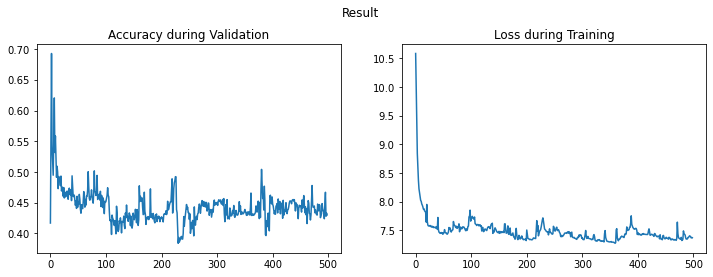

In [18]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

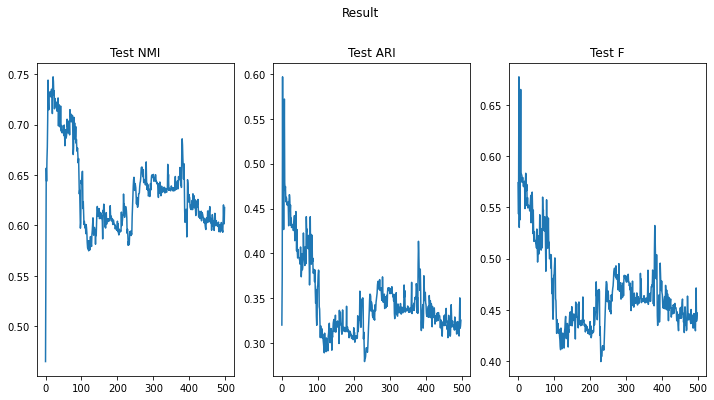

In [19]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()